In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

In [2]:
df = pd.read_csv('loan_data_2007_2014.csv')

In [3]:
df['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

# General preprocessing

## Removing Empty Features

In [4]:
data = df.copy()

empty_features = ['annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
                  'inq_fi','total_cu_tl','inq_last_12m']
data.drop(columns=empty_features, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 58 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

## Checking Data Types

**term and emp_length should be in integer type**.<br>
**earliest_cr_line, issue_d, last_pymnt_d, next_pymnt_d, and last_credit_pull_d should be in date type**

In [6]:
data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [7]:
data['emp_length_int'] = data['emp_length'].str.replace('\+ years','')
data['emp_length_int'] = data['emp_length_int'].str.replace('< 1 year',str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace('n/a',str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace(' years','')
data['emp_length_int'] = data['emp_length_int'].str.replace(' year','')

In [8]:
data['emp_length_int'] = pd.to_numeric(data['emp_length_int'])

In [9]:
data['emp_length_int'].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7., nan])

In [10]:
type(data['emp_length_int'][0])

numpy.float64

In [11]:
data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [12]:
data['term_int'] = data['term'].str.replace(' months', '')
data['term_int'] = pd.to_numeric(data['term_int'])

In [13]:
data['term_int'].unique()

array([36, 60], dtype=int64)

In [14]:
type(data['term_int'][0])

numpy.int64

In [15]:
d_str = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

data['earliest_cr_line_date'] = pd.to_datetime(data[d_str[0]], format='%b-%y')
data['issue_d_date'] = pd.to_datetime(data[d_str[1]], format='%b-%y')
data['last_pymnt_d_date'] = pd.to_datetime(data[d_str[2]], format='%b-%y')
data['next_pymnt_d_date'] = pd.to_datetime(data[d_str[3]], format='%b-%y')
data['last_credit_pull_d_date'] = pd.to_datetime(data[d_str[4]], format='%b-%y')

In [16]:
d_date = ['earliest_cr_line_date','issue_d_date','last_pymnt_d_date','next_pymnt_d_date','last_credit_pull_d_date']
for i in range(len(d_date)):
    print(type(data[d_date[i]][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.nattype.NaTType'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


**We should set a reference date to calculate the time that has passed**

**Calculate the present to the earliest_cr_line feature**

In [17]:
time_passed_days = pd.to_datetime('2023-06-01') - data['earliest_cr_line_date']
data['mths_since_earliest_cr_line'] = round(pd.to_numeric(time_passed_days/np.timedelta64(1,'M')))

In [18]:
data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        305.482430
std          93.974829
min        -546.000000
25%         249.000000
50%         291.000000
75%         351.000000
max         653.000000
Name: mths_since_earliest_cr_line, dtype: float64

**There is a negative value in the min section, which is impossible to have a negative value for months differences**

In [19]:
data.loc[:,['earliest_cr_line','earliest_cr_line_date','mths_since_earliest_cr_line']][data['mths_since_earliest_cr_line'] < 0]

earliest_cr_line earliest_cr_line_date  mths_since_earliest_cr_line
1580             Sep-62            2062-09-01                       -471.0
1770             Sep-68            2068-09-01                       -543.0
2799             Sep-64            2064-09-01                       -495.0
3282             Sep-67            2067-09-01                       -531.0
3359             Feb-65            2065-02-01                       -500.0
...                 ...                   ...                          ...
464003           Jan-68            2068-01-01                       -535.0
464260           Jul-66            2066-07-01                       -517.0
465100           Oct-67            2067-10-01                       -532.0
465500           Sep-67            2067-09-01                       -531.0
465655           Jan-56            2056-01-01                       -391.0

[1169 rows x 3 columns]

**Since we have 466.285 and only 1169 records with negative values, we can impute the value with other since it won't affect much to our analysis**

In [20]:
data['mths_since_earliest_cr_line'][data.mths_since_earliest_cr_line < 0] = data['mths_since_earliest_cr_line'].max()

In [21]:
data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        308.385374
std          86.460310
min         139.000000
25%         250.000000
50%         292.000000
75%         351.000000
max         653.000000
Name: mths_since_earliest_cr_line, dtype: float64

**Calculate the present to the issue_d_date feature**

In [22]:
issue_time_passed_days = pd.to_datetime('2023-06-01') - data['issue_d_date']
data['mths_since_issue_date'] = round(pd.to_numeric(time_passed_days/np.timedelta64(1,'M')))

In [23]:
data['mths_since_issue_date'].describe()

count    466256.000000
mean        305.482430
std          93.974829
min        -546.000000
25%         249.000000
50%         291.000000
75%         351.000000
max         653.000000
Name: mths_since_issue_date, dtype: float64

In [24]:
data.loc[:,['issue_d','issue_d_date','mths_since_issue_date']][data['mths_since_issue_date'] < 0]

issue_d issue_d_date  mths_since_issue_date
1580    Dec-11   2011-12-01                 -471.0
1770    Dec-11   2011-12-01                 -543.0
2799    Nov-11   2011-11-01                 -495.0
3282    Nov-11   2011-11-01                 -531.0
3359    Nov-11   2011-11-01                 -500.0
...        ...          ...                    ...
464003  Jan-14   2014-01-01                 -535.0
464260  Jan-14   2014-01-01                 -517.0
465100  Jan-14   2014-01-01                 -532.0
465500  Jan-14   2014-01-01                 -531.0
465655  Jan-14   2014-01-01                 -391.0

[1169 rows x 3 columns]

In [25]:
data['mths_since_issue_date'][data.mths_since_issue_date < 0] = data['mths_since_issue_date'].max()
data['mths_since_issue_date'].describe()

count    466256.000000
mean        308.385374
std          86.460310
min         139.000000
25%         250.000000
50%         292.000000
75%         351.000000
max         653.000000
Name: mths_since_issue_date, dtype: float64

## Encoding All Categorical Discreat Feature

In [26]:
data.sample(2)

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
260            260   1066191    1300547      18000        18000   
355682      355682  20308405   22571151      14000        14000   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
260             17975.0   36 months     12.42       601.48     B        B4   
355682          14000.0   60 months     12.49       314.90     B        B5   

                    emp_title emp_length home_ownership  annual_inc  \
260     National Park Service     1 year            OWN     75000.0   
355682                Teacher    6 years       MORTGAGE     52000.0   

       verification_status issue_d loan_status pymnt_plan  \
260               Verified  Dec-11  Fully Paid          n   
355682     Source Verified  Jul-14     Current          n   

                                                      url desc  \
260     https://www.lendingclub.com/browse/loanDetail....  NaN   
355682  https://www.lendingclub.com/browse/loanDetail....  NaN   

                 purpose             title zip_code addr_state    dti  \
260          credit_card   Paydown CC Loan    705xx         LA  12.51   
355682  home_improvement  Home improvement    488xx         MI  20.29   

        delinq_2yrs earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
260             0.0           Apr-91             2.0                     NaN   
355682          0.0           Jan-99             0.0                    25.0   

        mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  \
260                        NaN       9.0      0.0      14810        66.1   
355682                     NaN      19.0      0.0       4331        29.3   

        total_acc initial_list_status  out_prncp  out_prncp_inv  total_pymnt  \
260          27.0                   f       0.00           0.00  21629.24351   
355682       47.0                   f   10669.72       10669.72   5668.20000   

        total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
260            21599.23         18000.00        3629.24                 0.0   
355682          5668.20          3330.28        2337.92                 0.0   

        recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
260            0.0                      0.0       Oct-14          1805.88   
355682         0.0                      0.0       Jan-16           314.90   

       next_pymnt_d last_credit_pull_d  collections_12_mths_ex_med  \
260             NaN             Jan-16                         0.0   
355682       Feb-16             Jan-16                         0.0   

        mths_since_last_major_derog  policy_code application_type  \
260                             NaN            1       INDIVIDUAL   
355682                         25.0            1       INDIVIDUAL   

        acc_now_delinq  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  \
260                0.0           NaN          NaN               NaN   
355682             0.0           0.0      89610.0           14800.0   

        emp_length_int  term_int earliest_cr_line_date issue_d_date  \
260                1.0        36            1991-04-01   2011-12-01   
355682             6.0        60            1999-01-01   2014-07-01   

       last_pymnt_d_date next_pymnt_d_date last_credit_pull_d_date  \
260           2014-10-01               NaT              2016-01-01   
355682        2016-01-01        2016-02-01              2016-01-01   

        mths_since_earliest_cr_line  mths_since_issue_date  
260                           386.0                  386.0  
355682                        293.0                  293.0

In [27]:
data['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

In [28]:
cat_discreat = ['grade','sub_grade','home_ownership','verification_status','loan_status','purpose','addr_state', 'initial_list_status']

In [29]:
data_dummies = [pd.get_dummies(data[cat_discreat[0]], prefix='grade', prefix_sep=':'),
                pd.get_dummies(data[cat_discreat[1]], prefix='sub_grade', prefix_sep=':'),
                pd.get_dummies(data[cat_discreat[2]], prefix='ownership', prefix_sep=':'),
                pd.get_dummies(data[cat_discreat[3]], prefix='ver_status', prefix_sep=':'),
                pd.get_dummies(data[cat_discreat[4]], prefix='loan_status', prefix_sep=':'),
                pd.get_dummies(data[cat_discreat[5]], prefix='purpose', prefix_sep=':'),
                pd.get_dummies(data[cat_discreat[6]], prefix='addr', prefix_sep=':'),
                pd.get_dummies(data[cat_discreat[7]], prefix='list_status', prefix_sep=':')
               ]

In [30]:
#Convert into dataframe
data_dummies = pd.concat(data_dummies, axis=1)

In [31]:
#Merge the original dataframe with the dummies dataframe
data = pd.concat([data, data_dummies], axis=1)

In [32]:
data.sample(10)

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
16834        16834    722833     917700       3000         3000   
386000      386000  15569931   13977286      12000        12000   
112687      112687   6299756    7831079      21025        21025   
352588      352588  14488814   16551153       3950         3950   
38515        38515    353784     357576       3200         1375   
247198      247198  34733189   37426488       6500         6500   
198698      198698   1525205    1789326       3000         3000   
415370      415370  12947039   14979227      15000        15000   
114003      114003   1340951    1585508      20800        20800   
62538        62538   8915435   10707546      13475        13475   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
16834            3000.0   36 months      7.29        93.03     A        A4   
386000          12000.0   36 months     17.57       431.25     D        D4   
112687          21025.0   36 months     11.55       693.83     B        B3   
352588           3950.0   36 months     14.49       135.95     C        C4   
38515             579.2   36 months      9.70        44.18     B        B1   
247198           6500.0   36 months     17.86       234.54     D        D5   
198698           3000.0   36 months     13.11       101.25     B        B4   
415370          15000.0   36 months     11.99       498.15     B        B3   
114003          20800.0   36 months     12.35       694.34     B        B4   
62538           13475.0   36 months     17.76       485.54     D        D1   

                           emp_title emp_length home_ownership  annual_inc  \
16834                     State Farm    7 years       MORTGAGE     50400.0   
386000       Outside Sales Associate    5 years       MORTGAGE     72000.0   
112687    Southern California Edison    5 years           RENT    117000.0   
352588               Personal Banker     1 year       MORTGAGE     34000.0   
38515   Department of Motor Vehicles    5 years       MORTGAGE     39962.0   
247198                           NaN        NaN       MORTGAGE     22000.0   
198698         United Parcel Service    2 years           RENT     51000.0   
415370           Director of nursing    8 years       MORTGAGE    237510.0   
114003                       Us Army  10+ years       MORTGAGE    129485.0   
62538      Implementation Specialist  10+ years       MORTGAGE     50000.0   

       verification_status issue_d loan_status pymnt_plan  \
16834      Source Verified  Apr-11  Fully Paid          n   
386000        Not Verified  May-14  Fully Paid          n   
112687            Verified  Jul-13     Current          n   
352588        Not Verified  Jul-14     Current          n   
38515             Verified  Aug-08  Fully Paid          n   
247198            Verified  Nov-14     Current          n   
198698        Not Verified  Sep-12  Fully Paid          n   
415370            Verified  Apr-14     Current          n   
114003     Source Verified  Jul-13     Current          n   
62538      Source Verified  Nov-13  Fully Paid          n   

                                                      url  \
16834   https://www.lendingclub.com/browse/loanDetail....   
386000  https://www.lendingclub.com/browse/loanDetail....   
112687  https://www.lendingclub.com/browse/loanDetail....   
352588  https://www.lendingclub.com/browse/loanDetail....   
38515   https://www.lendingclub.com/browse/loanDetail....   
247198  https://www.lendingclub.com/browse/loanDetail....   
198698  https://www.lendingclub.com/browse/loanDetail....   
415370  https://www.lendingclub.com/browse/loanDetail....   
114003  https://www.lendingclub.com/browse/loanDetail....   
62538   https://www.lendingclub.com/browse/loanDetail....   

                                                     desc             purpose  \
16834                                                 NaN                 car   
386000                                        

## Check Missing Value

In [33]:
pd.options.display.max_rows=None

columns = [x for x in data.columns]
percent=[]
for kolom in columns:
    percent.append(round(data[kolom].isnull().sum()/data[kolom].shape[0]*100, 2))
    
explore = data.describe(percentiles = [], include = 'all').T 
explore['missing'] = len(df) - explore['count'] 
explore['%'] = percent
explore['type'] = data.dtypes
explore = explore[['missing','%','type']]

explore = explore.replace(np.nan, '-', regex=True)
explore

missing      %  \
Unnamed: 0                                               0.0   0.00   
id                                                       0.0   0.00   
member_id                                                0.0   0.00   
loan_amnt                                                0.0   0.00   
funded_amnt                                              0.0   0.00   
funded_amnt_inv                                          0.0   0.00   
term                                                       0   0.00   
int_rate                                                 0.0   0.00   
installment                                              0.0   0.00   
grade                                                      0   0.00   
sub_grade                                                  0   0.00   
emp_title                                              27588   5.92   
emp_length                                             21008   4.51   
home_ownership                                             0   0.00   
annual_inc                                               4.0   0.00   
verification_status                                        0   0.00   
issue_d                                                    0   0.00   
loan_status                                                0   0.00   
pymnt_plan                                                 0   0.00   
url                                                        0   0.00   
desc                                                  340302  72.98   
purpose                                                    0   0.00   
title                                                     20   0.00   
zip_code                                                   0   0.00   
addr_state                                                 0   0.00   
dti                                                      0.0   0.00   
delinq_2yrs                                             29.0   0.01   
earliest_cr_line                                          29   0.01   
inq_last_6mths                                          29.0   0.01   
mths_since_last_delinq                              250351.0  53.69   
mths_since_last_record                              403647.0  86.57   
open_acc                                                29.0   0.01   
pub_rec                                                 29.0   0.01   
revol_bal                                                0.0   0.00   
revol_util                                             340.0   0.07   
total_acc                                               29.0   0.01   
initial_list_status                                        0   0.00   
out_prncp                                                0.0   0.00   
out_prncp_inv                                            0.0   0.00   
total_pymnt                                              0.0   0.00   
total_pymnt_inv                                          0.0   0.00   
total_rec_prncp                                          0.0   0.00   
total_rec_int                                            0.0   0.00   
total_rec_late_fee                                       0.0   0.00   
recoveries                                               0.0   0.00   
collection_recovery_fee                                  0.0   0.00   
last_pymnt_d                                             376   0.08   
last_pymnt_amnt                                          0.0   0.00   
next_pymnt_d                                          227214  48.73   
last_credit_pull_d                                        42   0.01   
collections_12_mths_ex_med                             145.0   0.03   
mths_since_last_major_derog                         367311.0  78.77   
policy_code                                              0.0   0.00   
application_type                                           0   0.00   
acc_now_delinq                                          29.0   0.01   
tot_coll_amt                                         70276.0  15.07   
tot_cu

In [36]:
possible_knn_features = [
    'total_rev_hi_lim', 'annual_inc', 'revol_util','tot_cur_bal'
]

missing_nums_data = [
            'mths_since_earliest_cr_line','acc_now_delinq','total_acc', 
            'pub_rec', 'open_acc', 'inq_last_6mths', 'delinq_2yrs', 'emp_length_int', 
            'mths_since_last_delinq', 'collections_12_mths_ex_med', 'collections_12_mths_ex_med', 
            'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'mths_since_issue_date', 'mths_since_last_record'
            ]

In [37]:
data.shape

(466285, 193)

In [38]:
from sklearn.impute import KNNImputer

nums_data = data[possible_knn_features].copy()

KNNImputer = KNNImputer(n_neighbors=5)
impute_nums_data = pd.DataFrame(KNNImputer.fit_transform(nums_data), columns=nums_data.columns)

In [39]:
#Filling the rest missing value features with 0 value
for i in range(len(missing_nums_data)):
    data[missing_nums_data[i]].fillna(0, inplace=True)

In [40]:
missing_cats_data = ['emp_title', 'desc', 'title']

In [41]:
from sklearn.impute import SimpleImputer

cats_data = data[missing_cats_data].copy()

imputer = SimpleImputer(strategy='constant', fill_value='missing')
impute_cats_data = pd.DataFrame(imputer.fit_transform(cats_data), columns = cats_data.columns)

In [42]:
imputed_data = impute_nums_data.join(impute_cats_data)

In [43]:
imputed_data.head()

total_rev_hi_lim  annual_inc  revol_util  tot_cur_bal  \
0           11080.0     24000.0        83.7      17821.6   
1            4780.0     30000.0         9.4      38686.4   
2            8420.0     12252.0        98.5       5456.4   
3           33840.0     49200.0        21.0     112638.6   
4           33080.0     80000.0        53.9     151792.0   

                  emp_title  \
0                   missing   
1                     Ryder   
2                   missing   
3       AIR RESOURCES BOARD   
4  University Medical Group   

                                                desc                 title  
0    Borrower added on 12/22/11 > I need to upgra...              Computer  
1    Borrower added on 12/22/11 > I plan to use t...                  bike  
2                                            missing  real estate business  
3    Borrower added on 12/21/11 > to pay for prop...              personel  
4    Borrower added on 12/21/11 > I plan on combi...              Personal

In [44]:
# data.drop(columns=['total_rev_hi_lim', 'annual_inc', 'revol_util', 'tot_cur_bal', 'emp_title', 'desc', 'title'], inplace=True)

In [45]:
data = data.join(imputed_data)

In [46]:
data.isna().sum()

Unnamed: 0                                                              0
id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_length                                                          21008
home_ownership                                                          0
verification_status                   

## Export Cleaned Dataframe

In [47]:
data.to_csv(r'C:\Users\Ferdy-Aditya\Documents\GitHub\CreditRisk\cleaned_data.csv', index=False, header=True)

In [2]:
#Importing cleaned dataframe directly

data = pd.read_csv('cleaned_data.csv')

## Expected Credit Loss (EL) = Probability of Default (PD) x Loss Given Default (LGD) x Exposure at Default (EAD)

### PD - Data Preprocessing

In [3]:
data['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [4]:
# Determine which is the good and bad value from the loan_status
data['good_bad'] = np.where(data['loan_status'].isin(['Charged Off', 'Late (16-30 days)','Default',
                                                     'Does not meet the credit policy. Status:Charged Off']),0,1)

In [5]:
data.sample(2)

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
412247      412247  13967596   16019942      13500        13500   
408060      408060  14478617   16540941      35000        35000   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
412247          13500.0   36 months      8.90       428.67     A        A5   
408060          35000.0   36 months     17.57      1257.80     D        D2   

       emp_length home_ownership verification_status issue_d loan_status  \
412247  10+ years            OWN        Not Verified  Apr-14     Current   
408060  10+ years       MORTGAGE            Verified  Apr-14     Current   

       pymnt_plan                                                url  \
412247          n  https://www.lendingclub.com/browse/loanDetail....   
408060          n  https://www.lendingclub.com/browse/loanDetail....   

            purpose zip_code addr_state    dti  delinq_2yrs earliest_cr_line  \
412247  credit_card    023xx         MA  27.84          0.0           Nov-91   
408060      medical    980xx         WA  13.03          1.0           Dec-91   

        inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
412247             0.0                     0.0                     0.0   
408060             0.0                    16.0                     0.0   

        open_acc  pub_rec  revol_bal  total_acc initial_list_status  \
412247      17.0      0.0      30374       28.0                   f   
408060      13.0      0.0       9361       49.0                   f   

        out_prncp  out_prncp_inv  total_pymnt  total_pymnt_inv  \
412247    6063.99        6063.99      9002.07          9002.07   
408060   16828.84       16828.84     26413.80         26413.80   

        total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  \
412247          7436.01        1566.06                 0.0         0.0   
408060         18171.16        8242.64                 0.0         0.0   

        collection_recovery_fee last_pymnt_d  last_pymnt_amnt next_pymnt_d  \
412247                      0.0       Jan-16           428.67       Feb-16   
408060                      0.0       Jan-16          1257.80       Feb-16   

       last_credit_pull_d  collections_12_mths_ex_med  \
412247             Jan-16                         0.0   
408060             Jan-16                         0.0   

        mths_since_last_major_derog  policy_code application_type  \
412247                          0.0            1       INDIVIDUAL   
408060                          0.0            1       INDIVIDUAL   

        acc_now_delinq  tot_coll_amt  emp_length_int  term_int  \
412247             0.0           0.0            10.0        36   
408060             0.0           0.0            10.0        36   

       earliest_cr_line_date issue_d_date last_pymnt_d_date next_pymnt_d_date  \
412247            1991-11-01   2014-04-01        2016-01-01        2016-02-01   
408060            1991-12-01   2014-04-01        2016-01-01        2016-02-01   

       last_credit_pull_d_date  mths_since_earliest_cr_line  \
412247              2016-01-01                        379.0   
408060              2016-01-01                        378.0   

        mths_since_issue_date  grade:A  grade:B  grade:C  grade:D  grade:E  \
412247                  379.0        1        0        0        0        0   
408060                  378.0        0        0        0        1        0   

        grade:F  grade:G  sub_grade:A1  sub_grade:A2  sub_grade:A3  \
412247        0        0             0             0             0   
408060        0        0             0             0             0   

        sub_grade:A4  sub_grade:A5  sub_grade:B1  sub_grade:B2  sub_grade:B3  \
412247             0             1             0             0             0   
408060             0             0             0             0             0   

        sub_grade:B4  sub_grade:B5  sub_grade:C1  sub_grade:C2  sub_grade:C3  \
412247    

### Splitting Data

In [6]:
X = data.drop(columns=['good_bad'])
y = data['good_bad']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

### WoE and IV Calculation

In [8]:
def woe_discreat(X_train, discreat_var_name, y_train):
    df = pd.concat([X_train[discreat_var_name], y_train], axis=1)
    
    #Calculate the number of observations and the proportion of good values (which is 1)
    #Since the good_bad feature only range from 0-1, calculate the mean good_bad will gives us the same result of the proportion of the good values (1)
    n_obs = df.groupby(discreat_var_name, as_index = False).agg(n_obs = (discreat_var_name, 'count'))
    prop_good = df.groupby(discreat_var_name, as_index = False).agg(prop_good = (y_train.name,'mean'))
    
    df = pd.concat([n_obs, prop_good], axis=1)
    
    #Removing the duplicate feature (only return feature from index 0,1,and 3)
    df = df.iloc[:,[0,1,3]]
    
    #calculate the percentage of observations
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    
    #calculate the n_good and the n_bad using the following formula
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1-df['prop_good']) * df['n_obs']
    
    #calculate the percentage of the n_good and the n_bad
    df['prcnt_good'] = df['n_good']/df['n_good'].sum()
    df['prcnt_bad'] = df['n_bad']/df['n_bad'].sum()
    
    #calculate the WoE Score
    df['woe'] = np.log(df['prcnt_good'] / df['prcnt_bad'])
    
    #calculate Information Value (IV)
    df['IV'] = (df['prcnt_good'] - df['prcnt_bad'])*df['woe']
    df['IV'] = df['IV'].sum()
    
    #calculate the difference of good loan and the woe
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_woe'] = df['woe'].diff().abs()
    
    df = df.sort_values(by='woe')
    
    return df

In [9]:
#WoE by grade
woe_discreat(X_train, 'grade', y_train)

grade   n_obs  prop_good  prop_n_obs    n_good    n_bad  prcnt_good  \
6     G    2654   0.754333    0.007115    2002.0    652.0    0.005945   
5     F   10530   0.776923    0.028228    8181.0   2349.0    0.024293   
4     E   28612   0.826821    0.076702   23657.0   4955.0    0.070247   
3     D   61498   0.864272    0.164862   53151.0   8347.0    0.157826   
2     C  100245   0.899426    0.268733   90163.0  10082.0    0.267730   
1     B  109730   0.929199    0.294160  101961.0   7769.0    0.302762   
0     A   59759   0.964775    0.160200   57654.0   2105.0    0.171197   

   prcnt_bad       woe        IV  diff_prop_good  diff_woe  
6   0.017982 -1.106852  0.277898        0.022590  0.125967  
5   0.064784 -0.980885  0.277898        0.049898  0.315437  
4   0.136656 -0.665448  0.277898        0.037451  0.287973  
3   0.230205 -0.377475  0.277898        0.035154  0.339633  
2   0.278055 -0.037842  0.277898        0.029773  0.383581  
1   0.214264  0.345739  0.277898        0.035576  0.735695  
0   0.058055  1.081435  0.277898             NaN       NaN

### Visualize WoE

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_woe(df_woe, rotation_of_axis_labels=0):
    x = np.array(df_woe.iloc[:, 0].apply(str)) #retrieve the grade feature
    y = df_woe['woe']
    
    plt.figure(figsize=(18,6))
    plt.plot(x,y, marker = 'o', linestyle='--', color='k')
    plt.xlabel(df_woe.columns[0])
    plt.ylabel('Weight of Evidence')
    
    plt.title(str('Weight of Evidence by' + df_woe.columns[0]))
    plt.xticks(rotation = rotation_of_axis_labels)
    plt.grid()

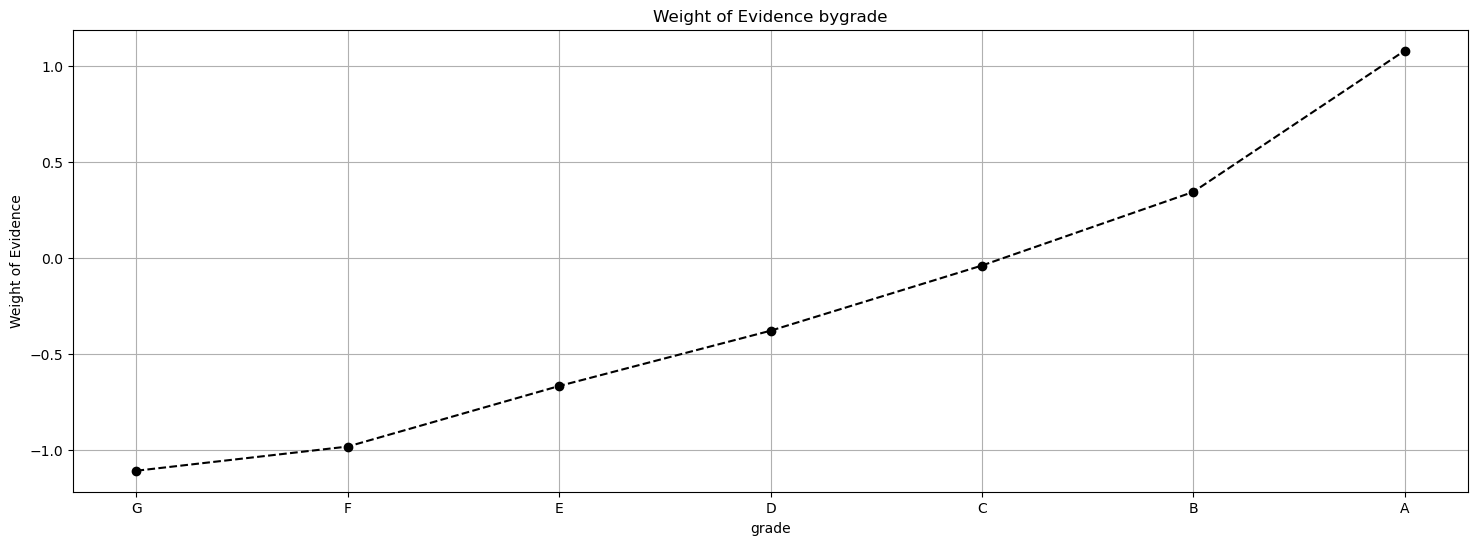

In [11]:
plot_woe((woe_discreat(X_train, 'grade', y_train)))

In [12]:
#Woe by home_ownership
woe_discreat(X_train,'home_ownership', y_train)

home_ownership   n_obs  prop_good  prop_n_obs    n_good    n_bad  \
3          OTHER     137   0.795620    0.000367     109.0     28.0   
2           NONE      40   0.850000    0.000107      34.0      6.0   
5           RENT  150599   0.887722    0.403720  133690.0  16909.0   
4            OWN   33295   0.905181    0.089256   30138.0   3157.0   
1       MORTGAGE  188956   0.914483    0.506546  172797.0  16159.0   
0            ANY       1   1.000000    0.000003       1.0      0.0   

   prcnt_good  prcnt_bad       woe   IV  diff_prop_good  diff_woe  
3    0.000324   0.000772 -0.869566  inf        0.054380  0.375458  
2    0.000101   0.000165 -0.494109  inf        0.064483  0.635039  
5    0.396978   0.466339 -0.161032  inf        0.017459  0.188487  
4    0.089492   0.087068  0.027455  inf        0.109561  0.897021  
1    0.513102   0.445655  0.140931  inf        0.085517       inf  
0    0.000003   0.000000       inf  inf             NaN       NaN

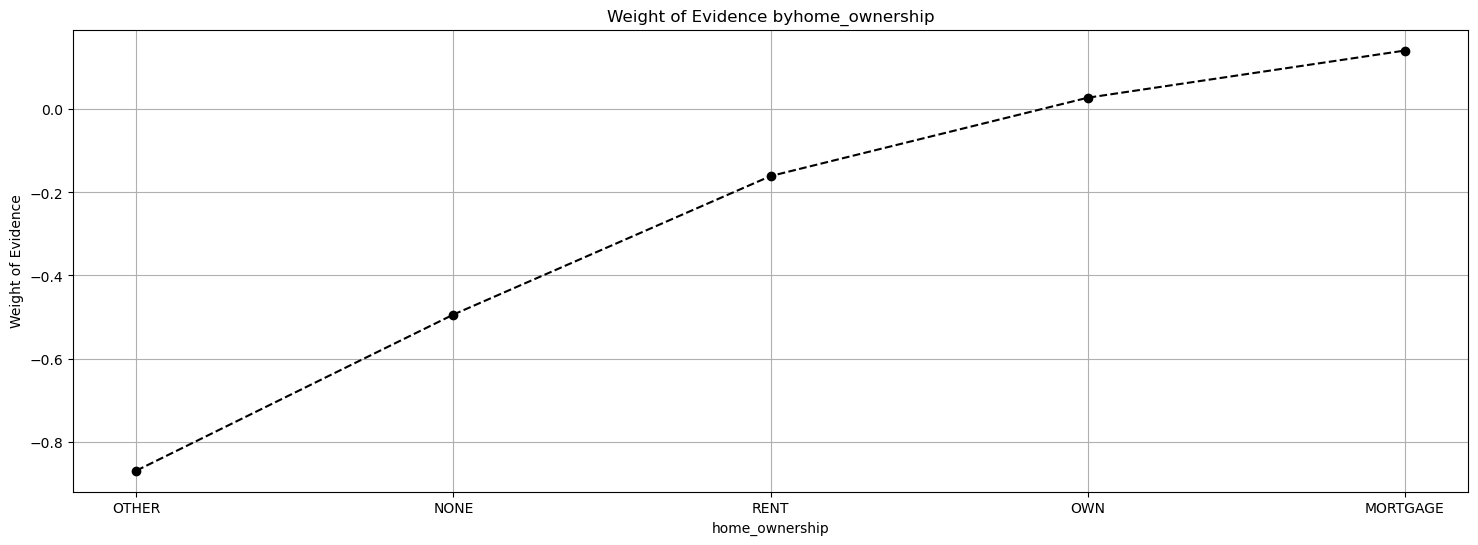

In [13]:
plot_woe(woe_discreat(X_train,'home_ownership', y_train))

### Grouping A Dummies Features

#### home_ownership

In [14]:
#Create a dummy variable to grouped the home_ownership values

X_train['home_ownership:RENT_OTHER_NONE_ANY'] = sum([
    X_train['ownership:RENT'], X_train['ownership:OTHER'],
    X_train['ownership:NONE'], X_train['ownership:ANY']
])

X_test['home_ownership:RENT_OTHER_NONE_ANY'] = sum([
    X_test['ownership:RENT'], X_test['ownership:OTHER'],
    X_test['ownership:NONE'], X_test['ownership:ANY']
])

In [15]:
X_train.sample(5)

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
447155      447155  11644666   13616816      27000        27000   
176189      176189   2838514    3421129      18000        18000   
383218      383218  17152875   19275413      10000        10000   
175881      175881   2874757    3476930       7500         7500   
448970      448970  11356694   13288873      13000        13000   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
447155          27000.0   36 months     13.53       916.65     B        B5   
176189          18000.0   36 months      7.90       563.23     A        A4   
383218          10000.0   36 months     11.67       330.57     B        B4   
175881           7500.0   36 months     13.11       253.11     B        B4   
448970          13000.0   60 months     15.61       313.45     C        C4   

       emp_length home_ownership verification_status issue_d  loan_status  \
447155  10+ years       MORTGAGE     Source Verified  Feb-14      Current   
176189    3 years       MORTGAGE            Verified  Jan-13  Charged Off   
383218  10+ years           RENT     Source Verified  May-14      Current   
175881        NaN       MORTGAGE            Verified  Jan-13   Fully Paid   
448970  10+ years           RENT            Verified  Feb-14      Current   

       pymnt_plan                                                url  \
447155          n  https://www.lendingclub.com/browse/loanDetail....   
176189          n  https://www.lendingclub.com/browse/loanDetail....   
383218          n  https://www.lendingclub.com/browse/loanDetail....   
175881          n  https://www.lendingclub.com/browse/loanDetail....   
448970          n  https://www.lendingclub.com/browse/loanDetail....   

                   purpose zip_code addr_state    dti  delinq_2yrs  \
447155  debt_consolidation    532xx         WI  21.06          0.0   
176189    home_improvement    430xx         OH   5.99          1.0   
383218  debt_consolidation    770xx         TX   7.75          1.0   
175881  debt_consolidation    344xx         FL   6.75          0.0   
448970         credit_card    598xx         MT  18.33          3.0   

       earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
447155           Dec-97             1.0                    66.0   
176189           Aug-99             2.0                    20.0   
383218           Mar-96             1.0                    17.0   
175881           Sep-81             1.0                    34.0   
448970           May-97             0.0                     7.0   

        mths_since_last_record  open_acc  pub_rec  revol_bal  total_acc  \
447155                     0.0      13.0      0.0      25343       33.0   
176189                     0.0       8.0      0.0       2987       35.0   
383218                     0.0       9.0      0.0        296       34.0   
175881                    27.0      11.0      1.0       5274       52.0   
448970                     0.0       5.0      0.0      11537       13.0   

       initial_list_status  out_prncp  out_prncp_inv   total_pymnt  \
447155                   f   11026.46       11026.46  21082.950000   
176189                   w       0.00           0.00  12746.150000   
383218                   w    5156.68        5156.68   6280.830000   
175881                   f       0.00           0.00   9111.617983   
448970                   f    9158.88        9158.88   7209.350000   

        total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
447155         21082.95         15973.54        5109.41                 0.0   
176189         12746.15         10747.24        1998.91                 0.0   
383218          6280.83          4843.32        1437.51                 0.0   
175881          9111.62          7500.00        1611.62                 0.0   
448970          7209.35          3841.12        3368.23                 0.0   

        recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_

#### addr_state

In [16]:
woe_discreat(X_train, 'addr_state',y_train)

addr_state  n_obs  prop_good  prop_n_obs   n_good   n_bad  prcnt_good  \
28         NE     13   0.461538    0.000035      6.0     7.0    0.000018   
12         IA     13   0.769231    0.000035     10.0     3.0    0.000030   
32         NV   5221   0.880483    0.013996   4597.0   624.0    0.013650   
9          FL  25211   0.889215    0.067585  22418.0  2793.0    0.066568   
1          AL   4671   0.890387    0.012522   4159.0   512.0    0.012350   
31         NM   2075   0.892530    0.005563   1852.0   223.0    0.005499   
11         HI   2001   0.894553    0.005364   1790.0   211.0    0.005315   
24         MO   6017   0.894632    0.016130   5383.0   634.0    0.015984   
4          CA  57199   0.896432    0.153337  51275.0  5924.0    0.152256   
17         KY   3587   0.896850    0.009616   3217.0   370.0    0.009553   
44         VA  11366   0.897501    0.030470  10201.0  1165.0    0.030291   
33         NY  32211   0.897923    0.086350  28923.0  3288.0    0.085884   
27         NC  10204   0.897981    0.027355   9163.0  1041.0    0.027209   
43         UT   2756   0.898403    0.007388   2476.0   280.0    0.007352   
20         MD   8771   0.899441    0.023513   7889.0   882.0    0.023426   
30         NJ  14385   0.899826    0.038563  12944.0  1441.0    0.038436   
18         LA   4359   0.900206    0.011685   3924.0   435.0    0.011652   
35         OK   3284   0.900731    0.008804   2958.0   326.0    0.008783   
22         MI   9191   0.901425    0.024639   8285.0   906.0    0.024601   
41         TN   4845   0.902167    0.012988   4371.0   474.0    0.012979   
23         MN   6526   0.902697    0.017495   5891.0   635.0    0.017493   
3          AZ   8645   0.902718    0.023175   7804.0   841.0    0.023173   
8          DE   1064   0.903195    0.002852    961.0   103.0    0.002854   
37         PA  13090   0.903361    0.035091  11825.0  1265.0    0.035113   
2          AR   2760   0.903623    0.007399   2494.0   266.0    0.007406   
34         OH  12135   0.903997    0.032531  10970.0  1165.0    0.032574   
46         WA   8372   0.905399    0.022443   7580.0   792.0    0.022508   
19         MA   8858   0.906525    0.023746   8030.0   828.0    0.023844   
15         IN   5210   0.906910    0.013967   4725.0   485.0    0.014030   
10         GA  11960   0.907692    0.032062  10856.0  1104.0    0.032236   
38         RI   1647   0.908318    0.004415   1496.0   151.0    0.004442   
36         OR   4814   0.909015    0.012905   4376.0   438.0    0.012994   
47         WI   4740   0.911181    0.012707   4319.0   421.0    0.012825   
40         SD    801   0.911361    0.002147    730.0    71.0    0.002168   
6          CT   5775   0.913766    0.015481   5277.0   498.0    0.015669   
42         TX  29158   0.915392    0.078166  26691.0  2467.0    0.079256   
16         KS   3360   0.915774    0.009007   3077.0   283.0    0.009137   
14         IL  14833   0.916470    0.039764  13594.0  1239.0    0.040366   
26         MT   1103   0.916591    0.002957   1011.0    92.0    0.003002   
5          CO   7823   0.919596    0.020972   7194.0   629.0    0.021362   
39         SC   4448   0.920638    0.011924   4095.0   353.0    0.012160   
45         VT    727   0.921596    0.001949    670.0    57.0    0.001989   
0          AK   1003   0.923230    0.002689    926.0    77.0    0.002750   
25         MS    980   0.927551    0.002627    909.0    71.0    0.002699   
29         NH   1830   0.930601    0.004906   1703.0   127.0    0.005057   
49         WY    919   0.931447    0.002464    856.0    63.0    0.002542   
48         WV   1926   0.931464    0.005163   1794.0   132.0    0.005327   
7          DC   1129   0.940655    0.003027   1062.0    67.0    0.003153   
21         ME      2   1.000000    0.000005      2.0     0.0    0.000006   
13         ID     10   1.000000    0.000027     10.0     0.0    0.000030   

    prcnt_bad       woe   IV  diff_prop_good  diff_woe  
28   0.000193 -2.382860  inf        0.436443  2.329143  
12   0.00008

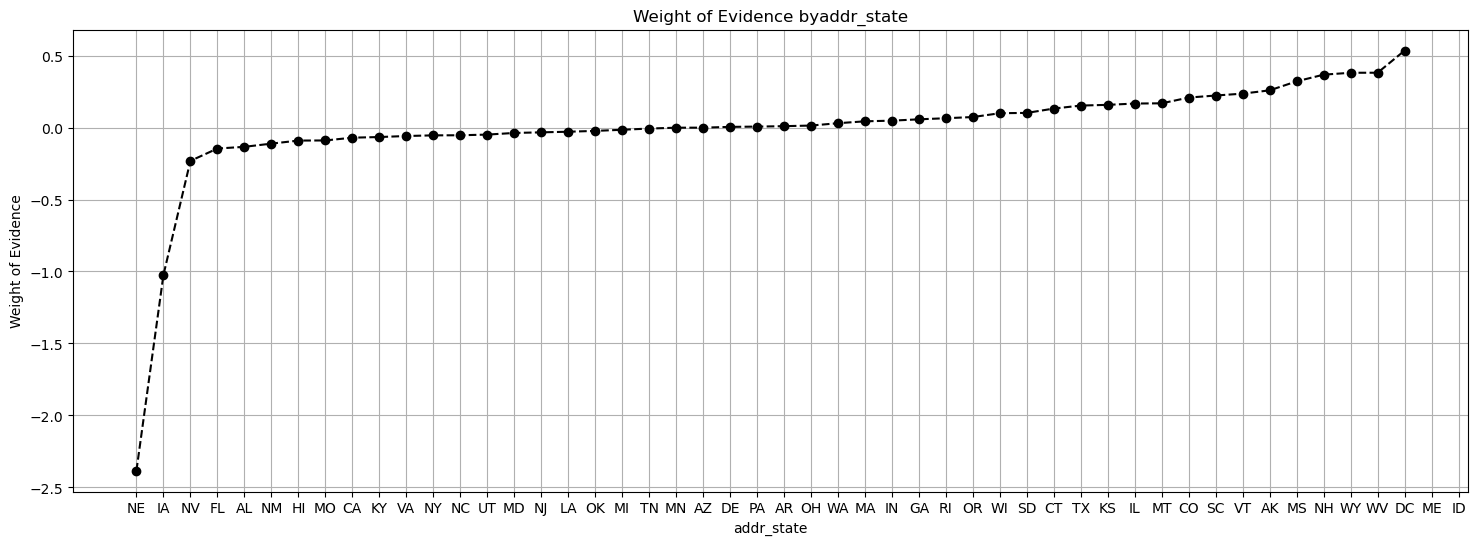

In [17]:
plot_woe(woe_discreat(X_train, 'addr_state',y_train))

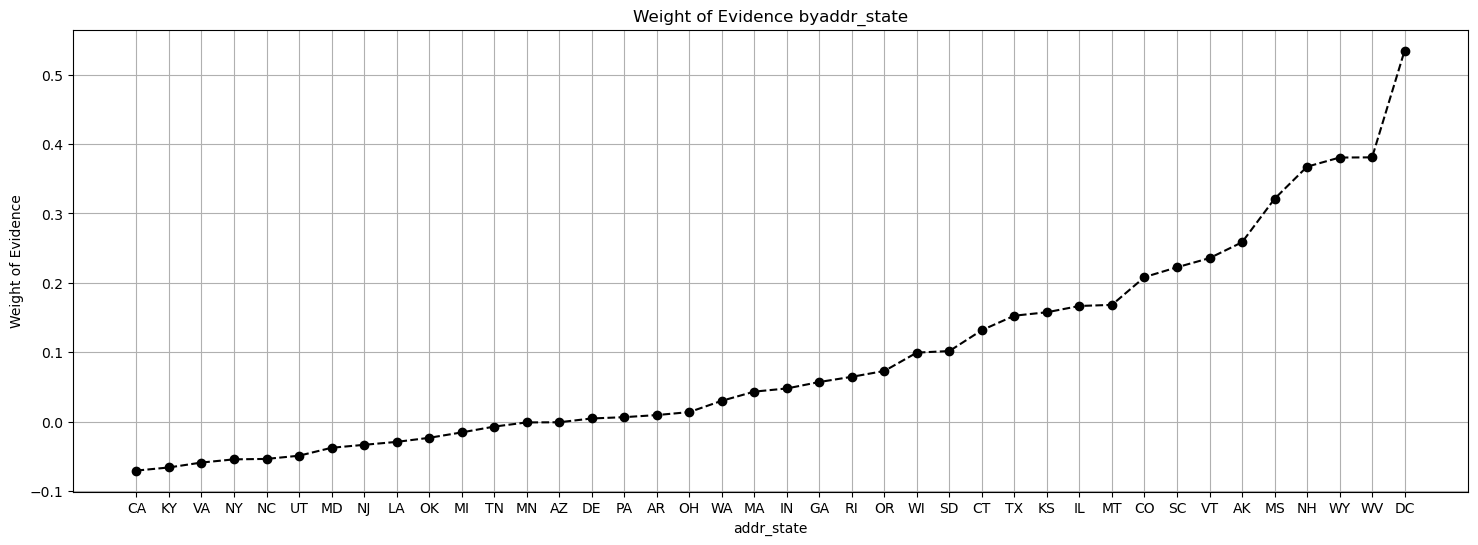

In [18]:
plot_woe(woe_discreat(X_train, 'addr_state',y_train).iloc[8:-2, :])

In [19]:
#Create a dummy variable to grouped the addr_state values
X_train['adrr_state:NE_IA_NV_FL_AL_NM_HI_MO'] = sum([
    X_train['addr:NE'], X_train['addr:IA'], X_train['addr:NV'], X_train['addr:FL'], X_train['addr:AL'],
    X_train['addr:NM'], X_train['addr:HI'], X_train['addr:MO']
])

X_train['adrr_state:CA'] = X_train['addr:CA']

X_train['adrr_state:KY_VA'] = sum([
    X_train['addr:KY'], X_train['addr:VA']
])

X_train['adrr_state:NY'] = X_train['addr:NY']

X_train['adrr_state:NC_UT'] = sum([
    X_train['addr:NC'], X_train['addr:UT']
])

X_train['adrr_state:MD_NJ_LA_OK_MI_TN'] = sum([
    X_train['addr:MD'], X_train['addr:NJ'], X_train['addr:LA'], X_train['addr:OK'], X_train['addr:MI'],
    X_train['addr:TN']
])

X_train['adrr_state:MN_AZ_DE_PA_AR_OH'] = sum([
    X_train['addr:MN'], X_train['addr:AZ'], X_train['addr:DE'], X_train['addr:PA'], X_train['addr:AR'],
    X_train['addr:OH']
])

X_train['adrr_state:WA_MA_IN_GA_RI_OR'] = sum([
    X_train['addr:WA'], X_train['addr:MA'], X_train['addr:IN'], X_train['addr:GA'], X_train['addr:RI'],
    X_train['addr:OR']
])

X_train['adrr_state:WI_SD_CT'] = sum([
    X_train['addr:WI'], X_train['addr:SD'], X_train['addr:CT']
])

X_train['adrr_state:TX'] = X_train['addr:TX']

X_train['adrr_state:KS_IL_MT'] = sum([
    X_train['addr:KS'], X_train['addr:IL'], X_train['addr:MT']
])

X_train['adrr_state:CO_SC_VT_AK'] = sum([
    X_train['addr:CO'], X_train['addr:SC'], X_train['addr:VT'], X_train['addr:AK']
])

X_train['adrr_state:MS_NH_WY_WV_DC_ME_ID'] = sum([
    X_train['addr:MS'], X_train['addr:NH'], X_train['addr:WY'], X_train['addr:WV'], X_train['addr:DC'],
    X_train['addr:ME'], X_train['addr:ID']
])

In [20]:
#Create a dummy variable to grouped the addr_state values
X_test['adrr_state:NE_IA_NV_FL_AL_NM_HI_MO'] = sum([
    X_test['addr:NE'], X_test['addr:IA'], X_test['addr:NV'], X_test['addr:FL'], X_test['addr:AL'],
    X_test['addr:NM'], X_test['addr:HI'], X_test['addr:MO']
])

X_test['adrr_state:CA'] = X_test['addr:CA']

X_test['adrr_state:KY_VA'] = sum([
    X_test['addr:KY'], X_test['addr:VA']
])

X_test['adrr_state:NY'] = X_test['addr:NY']

X_test['adrr_state:NC_UT'] = sum([
    X_test['addr:NC'], X_test['addr:UT']
])

X_test['adrr_state:MD_NJ_LA_OK_MI_TN'] = sum([
    X_test['addr:MD'], X_test['addr:NJ'], X_test['addr:LA'], X_test['addr:OK'], X_test['addr:MI'],
    X_test['addr:TN']
])

X_test['adrr_state:MN_AZ_DE_PA_AR_OH'] = sum([
    X_test['addr:MN'], X_test['addr:AZ'], X_test['addr:DE'], X_test['addr:PA'], X_test['addr:AR'],
    X_test['addr:OH']
])

X_test['adrr_state:WA_MA_IN_GA_RI_OR'] = sum([
    X_test['addr:WA'], X_test['addr:MA'], X_test['addr:IN'], X_test['addr:GA'], X_test['addr:RI'],
    X_test['addr:OR']
])

X_test['adrr_state:WI_SD_CT'] = sum([
    X_test['addr:WI'], X_test['addr:SD'], X_test['addr:CT']
])

X_test['adrr_state:TX'] = X_test['addr:TX']

X_test['adrr_state:KS_IL_MT'] = sum([
    X_test['addr:KS'], X_test['addr:IL'], X_test['addr:MT']
])

X_test['adrr_state:CO_SC_VT_AK'] = sum([
    X_test['addr:CO'], X_test['addr:SC'], X_test['addr:VT'], X_test['addr:AK']
])

X_test['adrr_state:MS_NH_WY_WV_DC_ME_ID'] = sum([
    X_test['addr:MS'], X_test['addr:NH'], X_test['addr:WY'], X_test['addr:WV'], X_test['addr:DC'],
    X_test['addr:ME'], X_test['addr:ID']
])

In [21]:
X_train.sample(5)

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
210079      210079   1393904    1640872      10000        10000   
209242      209242   1403094    1651930       6200         6200   
242975      242975  36178248   38879774      15000        15000   
105720      105720   6570527    8122544       2500         2500   
110992      110992   6386381    7918475      11325        11325   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
210079           9975.0   36 months     14.33       343.39     C        C1   
209242           6200.0   36 months     12.12       206.29     B        B3   
242975          15000.0   36 months      6.03       456.54     A        A1   
105720           2500.0   36 months     15.88        87.75     C        C4   
110992          11325.0   60 months     15.88       274.69     C        C4   

       emp_length home_ownership verification_status issue_d loan_status  \
210079    6 years       MORTGAGE            Verified  Jul-12  Fully Paid   
209242  10+ years       MORTGAGE        Not Verified  Jul-12  Fully Paid   
242975  10+ years       MORTGAGE        Not Verified  Nov-14     Current   
105720    2 years            OWN            Verified  Aug-13  Fully Paid   
110992  10+ years       MORTGAGE            Verified  Aug-13     Current   

       pymnt_plan                                                url  \
210079          n  https://www.lendingclub.com/browse/loanDetail....   
209242          n  https://www.lendingclub.com/browse/loanDetail....   
242975          n  https://www.lendingclub.com/browse/loanDetail....   
105720          n  https://www.lendingclub.com/browse/loanDetail....   
110992          n  https://www.lendingclub.com/browse/loanDetail....   

                   purpose zip_code addr_state    dti  delinq_2yrs  \
210079  debt_consolidation    760xx         TX  33.15          0.0   
209242         credit_card    708xx         LA  25.38          1.0   
242975         credit_card    923xx         CA  12.92          0.0   
105720  debt_consolidation    335xx         FL  19.24          0.0   
110992  debt_consolidation    336xx         FL  24.03          0.0   

       earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
210079           Dec-05             1.0                     0.0   
209242           Oct-96             0.0                     2.0   
242975           Dec-93             0.0                    35.0   
105720           Apr-89             0.0                    61.0   
110992           Oct-00             0.0                    43.0   

        mths_since_last_record  open_acc  pub_rec  revol_bal  total_acc  \
210079                     0.0      14.0      0.0       9666       22.0   
209242                     0.0      16.0      0.0      51986       45.0   
242975                     0.0      10.0      0.0      15466       26.0   
105720                    36.0      11.0      1.0       3080       31.0   
110992                     0.0       9.0      0.0      13695       12.0   

       initial_list_status  out_prncp  out_prncp_inv   total_pymnt  \
210079                   f       0.00           0.00  11952.754200   
209242                   f       0.00           0.00   7446.117221   
242975                   f    9892.67        9892.67   5924.970000   
105720                   f       0.00           0.00   3072.225503   
110992                   f    6949.15        6949.15   7962.050000   

        total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
210079         11922.91         10000.00        1952.75            0.000000   
209242          7446.12          6200.00        1231.13           14.982549   
242975          5924.97          5107.33         817.64            0.000000   
105720          3072.23          2500.00         572.23            0.000000   
110992          7962.05          4375.85        3586.20            0.000000   

        recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  

#### purpose

In [22]:
#WoE by purpose
woe_discreat(X_train, 'purpose', y_train)

purpose   n_obs  prop_good  prop_n_obs    n_good    n_bad  \
11      small_business    5582   0.795951    0.014964    4443.0   1139.0   
3          educational     333   0.801802    0.000893     267.0     66.0   
8               moving    2392   0.852425    0.006412    2039.0    353.0   
10    renewable_energy     281   0.871886    0.000753     245.0     36.0   
9                other   18884   0.873279    0.050624   16491.0   2393.0   
5                house    1830   0.873770    0.004906    1599.0    231.0   
7              medical    3684   0.881650    0.009876    3248.0    436.0   
13             wedding    1887   0.882883    0.005059    1666.0    221.0   
12            vacation    1991   0.890005    0.005337    1772.0    219.0   
2   debt_consolidation  219183   0.899997    0.587578  197264.0  21919.0   
4     home_improvement   21238   0.912562    0.056934   19381.0   1857.0   
6       major_purchase    7837   0.912594    0.021009    7152.0    685.0   
0                  car    4325   0.914451    0.011594    3955.0    370.0   
1          credit_card   83581   0.924217    0.224061   77247.0   6334.0   

    prcnt_good  prcnt_bad       woe        IV  diff_prop_good  diff_woe  
11    0.013193   0.031413 -0.867530  0.041638        0.075935  0.556560  
3     0.000793   0.001820 -0.831116  0.041638        0.098195  0.799595  
8     0.006055   0.009736 -0.474963  0.041638        0.029226  0.254406  
10    0.000728   0.000993 -0.310970  0.041638        0.001393  0.012528  
9     0.048968   0.065997 -0.298443  0.041638        0.020854  0.176520  
5     0.004748   0.006371 -0.293994  0.041638        0.038792  0.410615  
7     0.009645   0.012025 -0.220557  0.041638        0.030944  0.337576  
13    0.004947   0.006095 -0.208691  0.041638        0.007122  0.070774  
12    0.005262   0.006040 -0.137917  0.041638        0.094054  0.729613  
2     0.585755   0.604512 -0.031521  0.041638        0.024220  0.303887  
4     0.057550   0.051215  0.116621  0.041638        0.110761  0.947737  
6     0.021237   0.018892  0.117019  0.041638        0.038824  0.411012  
0     0.011744   0.010204  0.140523  0.041638             NaN       NaN  
1     0.229377   0.174688  0.272367  0.041638        0.009766  0.131843

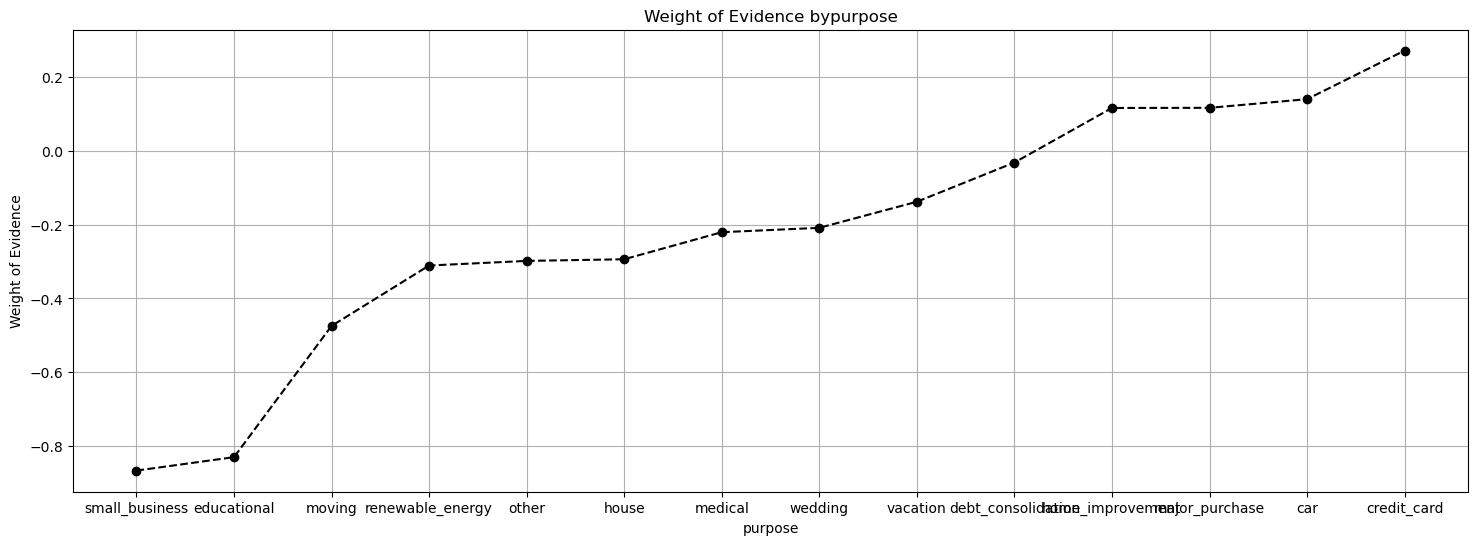

In [23]:
plot_woe(woe_discreat(X_train, 'purpose', y_train))

In [24]:
X_train['purpose:small_business_educational_moving'] = sum([
    X_train['purpose:small_business'], X_train['purpose:educational'], X_train['purpose:moving']
])

X_train['purpose:renewable_energy_other_house'] = sum([
    X_train['purpose:renewable_energy'], X_train['purpose:other'], X_train['purpose:house']
])

X_train['purpose:medical_wedding_vacation'] = sum([
    X_train['purpose:medical'], X_train['purpose:wedding'], X_train['purpose:vacation']
])

X_train['purpose:debt_consolidation'] = X_train['purpose:debt_consolidation']

X_train['purpose:home_improvement_major_purchase_car'] = sum([
    X_train['purpose:home_improvement'], X_train['purpose:major_purchase'], X_train['purpose:car']
])

X_train['purpose:credit_card'] = X_train['purpose:credit_card']

In [25]:
X_test['purpose:small_business_educational_moving'] = sum([
    X_test['purpose:small_business'], X_test['purpose:educational'], X_test['purpose:moving']
])

X_test['purpose:renewable_energy_other_house'] = sum([
    X_test['purpose:renewable_energy'], X_test['purpose:other'], X_test['purpose:house']
])

X_test['purpose:medical_wedding_vacation'] = sum([
    X_test['purpose:medical'], X_test['purpose:wedding'], X_test['purpose:vacation']
])

X_test['purpose:debt_consolidation'] = X_test['purpose:debt_consolidation']

X_test['purpose:home_improvement_major_purchase_car'] = sum([
    X_test['purpose:home_improvement'], X_test['purpose:major_purchase'], X_test['purpose:car']
])

X_test['purpose:credit_card'] = X_test['purpose:credit_card']

In [26]:
X_train.sample(5)

Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
82299        82299  7668177    9350166      30000        30000   
79809        79809  7727715    9429361       3500         3500   
190038      190038  1623983    1896036      32000        32000   
209725      209725  1398333    1645795      15000        15000   
97893        97893  6937001    8579024      31300        31300   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
82299           30000.0   60 months     23.40       852.63     E        E5   
79809            3500.0   36 months     15.61       122.38     C        C3   
190038          31750.0   60 months     21.98       883.45     E        E4   
209725          15000.0   36 months     13.11       506.21     B        B4   
97893           31300.0   36 months     14.33      1074.79     C        C2   

       emp_length home_ownership verification_status issue_d  \
82299   10+ years       MORTGAGE            Verified  Oct-13   
79809         NaN           RENT            Verified  Oct-13   
190038    2 years       MORTGAGE            Verified  Oct-12   
209725    5 years       MORTGAGE     Source Verified  Jul-12   
97893     6 years       MORTGAGE            Verified  Aug-13   

               loan_status pymnt_plan  \
82299   Late (31-120 days)          n   
79809              Current          n   
190038         Charged Off          n   
209725          Fully Paid          n   
97893              Current          n   

                                                      url             purpose  \
82299   https://www.lendingclub.com/browse/loanDetail....  debt_consolidation   
79809   https://www.lendingclub.com/browse/loanDetail....  debt_consolidation   
190038  https://www.lendingclub.com/browse/loanDetail....         credit_card   
209725  https://www.lendingclub.com/browse/loanDetail....  debt_consolidation   
97893   https://www.lendingclub.com/browse/loanDetail....  debt_consolidation   

       zip_code addr_state    dti  delinq_2yrs earliest_cr_line  \
82299     604xx         IL  24.51          0.0           Jun-94   
79809     945xx         CA  11.03          0.0           Mar-05   
190038    290xx         SC  28.88          0.0           Dec-97   
209725    339xx         FL   7.40          0.0           Jun-99   
97893     758xx         TX  24.77          0.0           Feb-01   

        inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
82299              1.0                     0.0                     0.0   
79809              0.0                    81.0                   110.0   
190038             0.0                     0.0                     0.0   
209725             0.0                     0.0                     0.0   
97893              1.0                     0.0                     0.0   

        open_acc  pub_rec  revol_bal  total_acc initial_list_status  \
82299       25.0      0.0      27019       55.0                   f   
79809        6.0      2.0       3770       10.0                   f   
190038      13.0      0.0      20557       30.0                   f   
209725       7.0      0.0      12614       11.0                   f   
97893       12.0      0.0      19498       45.0                   f   

        out_prncp  out_prncp_inv  total_pymnt  total_pymnt_inv  \
82299    21910.14       21910.14  20553.88000         20553.88   
79809     1140.92        1140.92   3181.20000          3181.20   
190038       0.00           0.00  16784.59000         16653.48   
209725       0.00           0.00  18241.23188         18241.23   
97893     8154.47        8154.47  30093.12000         30093.12   

        total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  \
82299           8089.86       12464.02                 0.0         0.0   
79809           2359.08         822.12                 0.0         0.0   
190038          6684.03       10100.56                 0.0         0.0   
209725         15000.00        3241.23                 

#### verification status

In [27]:
woe_discreat(X_train, 'verification_status', y_train)

verification_status   n_obs  prop_good  prop_n_obs    n_good    n_bad  \
2            Verified  134414   0.885086    0.360332  118968.0  15446.0   
1     Source Verified  120030   0.910514    0.321772  109289.0  10741.0   
0        Not Verified  118584   0.915064    0.317896  108512.0  10072.0   

   prcnt_good  prcnt_bad       woe       IV  diff_prop_good  diff_woe  
2    0.353263   0.425991 -0.187205  0.02279        0.025428  0.278423  
1    0.324522   0.296230  0.091218  0.02279        0.004550  0.057174  
0    0.322215   0.277779  0.148392  0.02279             NaN       NaN

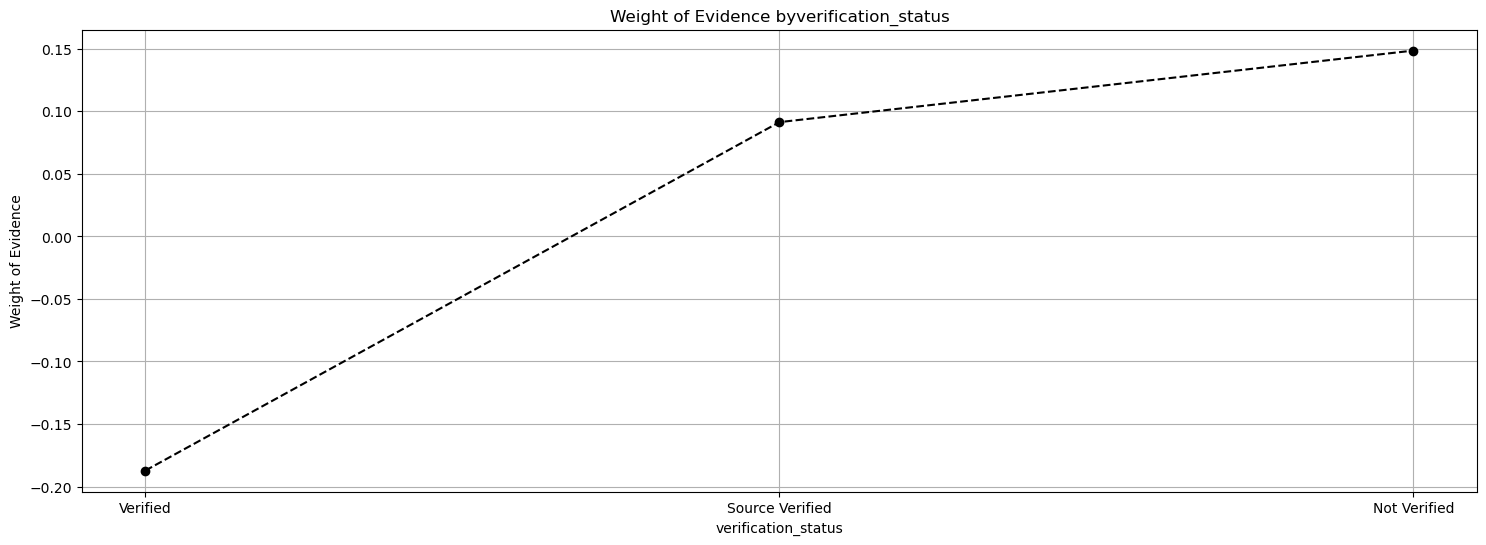

In [28]:
plot_woe(woe_discreat(X_train, 'verification_status', y_train))

*Since the verification status only consist of three values, there is no need to plot them into a seperate group*

#### initial_list_status

In [29]:
X_train['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

In [30]:
woe_discreat(X_train, 'initial_list_status', y_train)

initial_list_status   n_obs  prop_good  prop_n_obs    n_good    n_bad  \
0                   f  242514   0.890213    0.650123  215889.0  26625.0   
1                   w  130514   0.926184    0.349877  120880.0   9634.0   

   prcnt_good  prcnt_bad       woe        IV  diff_prop_good  diff_woe  
0     0.64106     0.7343 -0.135796  0.040708             NaN       NaN  
1     0.35894     0.2657  0.300790  0.040708        0.035972  0.436586

### Calculate WoE for Continuous Feature

*Since we want to keep the order of the continuous feature in the natural order (not by woe), we just simply remove the sort_value order from the previous woe calculation function.*

In [31]:
def woe_ordered_continuous(X_train, cont_var_name, y_train):
    df = pd.concat([X_train[cont_var_name], y_train], axis=1)
    
    #Calculate the number of observations and the proportion of good values (which is 1)
    #Since the good_bad feature only range from 0-1, calculate the mean good_bad will gives us the same result of the proportion of the good values (1)
    n_obs = df.groupby(cont_var_name, as_index = False).agg(n_obs = (cont_var_name, 'count'))
    prop_good = df.groupby(cont_var_name, as_index = False).agg(prop_good = (y_train.name,'mean'))
    
    df = pd.concat([n_obs, prop_good], axis=1)
    
    #Removing the duplicate feature (only return feature from index 0,1,and 3)
    df = df.iloc[:,[0,1,3]]
    
    #calculate the percentage of observations
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    
    #calculate the n_good and the n_bad using the following formula
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1-df['prop_good']) * df['n_obs']
    
    #calculate the percentage of the n_good and the n_bad
    df['prcnt_good'] = df['n_good']/df['n_good'].sum()
    df['prcnt_bad'] = df['n_bad']/df['n_bad'].sum()
    
    #calculate the WoE Score
    df['woe'] = np.log(df['prcnt_good'] / df['prcnt_bad'])
    
    #calculate Information Value (IV)
    df['IV'] = (df['prcnt_good'] - df['prcnt_bad'])*df['woe']
    df['IV'] = df['IV'].sum()
    
    #calculate the difference of good loan and the woe
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_woe'] = df['woe'].diff().abs()
    
    return df

### Creating Dummies Feature for Continuous Feature (Encoding numeric features)

#### term

In [32]:
X_train['term:36'] = np.where((X_train.term_int == 36), 1, 0)
X_train['term:60'] = np.where((X_train.term_int == 60), 1, 0)

X_test['term:36'] = np.where((X_test.term_int == 36), 1, 0)
X_test['term:60'] = np.where((X_test.term_int == 60), 1, 0)

#### emp_length_int

In [33]:
X_train.head(3)

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
427211      427211  12796369   14818505      24000        24000   
206088      206088   1439740    1691948      10000        10000   
136020      136020   5214749    6556909      20425        20425   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
427211          24000.0   36 months      8.90       762.08     A        A5   
206088          10000.0   36 months     14.33       343.39     C        C1   
136020          20425.0   36 months      8.90       648.56     A        A5   

       emp_length home_ownership verification_status issue_d loan_status  \
427211    3 years       MORTGAGE     Source Verified  Mar-14     Current   
206088    6 years       MORTGAGE        Not Verified  Aug-12  Fully Paid   
136020  10+ years       MORTGAGE            Verified  Jun-13     Current   

       pymnt_plan                                                url  \
427211          n  https://www.lendingclub.com/browse/loanDetail....   
206088          n  https://www.lendingclub.com/browse/loanDetail....   
136020          n  https://www.lendingclub.com/browse/loanDetail....   

                   purpose zip_code addr_state    dti  delinq_2yrs  \
427211  debt_consolidation    295xx         SC  21.91          0.0   
206088  debt_consolidation    070xx         NJ   7.49          1.0   
136020  debt_consolidation    302xx         GA  14.83          0.0   

       earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
427211           Dec-86             1.0                     0.0   
206088           Dec-97             2.0                    18.0   
136020           Jul-91             1.0                    46.0   

        mths_since_last_record  open_acc  pub_rec  revol_bal  total_acc  \
427211                     0.0      20.0      0.0      30489       32.0   
206088                     0.0      15.0      0.0      15836       38.0   
136020                     0.0       9.0      0.0      29813       20.0   

       initial_list_status  out_prncp  out_prncp_inv  total_pymnt  \
427211                   f   10098.30       10098.30  16765.76000   
206088                   f       0.00           0.00  12357.02066   
136020                   f    3183.62        3183.62  20090.40000   

        total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
427211         16765.76         13901.70        2864.06                 0.0   
206088         12357.02         10000.00        2357.02                 0.0   
136020         20090.40         17241.38        2849.02                 0.0   

        recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
427211         0.0                      0.0       Jan-16           762.08   
206088         0.0                      0.0       Aug-15           355.11   
136020         0.0                      0.0       Jan-16           648.56   

       next_pymnt_d last_credit_pull_d  collections_12_mths_ex_med  \
427211       Feb-16             Jan-16                         0.0   
206088          NaN             Jul-15                         0.0   
136020       Feb-16             Jan-16                         0.0   

        mths_since_last_major_derog  policy_code application_type  \
427211                          0.0            1       INDIVIDUAL   
206088                          0.0            1       INDIVIDUAL   
136020                          0.0            1       INDIVIDUAL   

        acc_now_delinq  tot_coll_amt  emp_length_int  term_int  \
427211             0.0           0.0             3.0        36   
206088             0.0           0.0             6.0        36   
136020             0.0           0.0            10.0        36   

       earliest_cr_line_date issue_d_date last_pymnt_d_date next_pymnt_d_date  \
427211            1986-12-01   2014-03-01        2016-01-01        2016-02-01   
206088            1997-12-01   2012-08-01        2015-08-01               NaN   
136020      

In [34]:
woe_ordered_continuous(X_train, 'emp_length_int', y_train)

emp_length_int   n_obs  prop_good  prop_n_obs    n_good    n_bad  \
0              0.0   45720   0.889764    0.122565   40680.0   5040.0   
1              1.0   23654   0.898875    0.063411   21262.0   2392.0   
2              2.0   33078   0.902594    0.088674   29856.0   3222.0   
3              3.0   29205   0.902688    0.078292   26363.0   2842.0   
4              4.0   22468   0.900614    0.060231   20235.0   2233.0   
5              5.0   24602   0.895496    0.065952   22031.0   2571.0   
6              6.0   20887   0.896922    0.055993   18734.0   2153.0   
7              7.0   21049   0.899520    0.056427   18934.0   2115.0   
8              8.0   17853   0.903322    0.047860   16127.0   1726.0   
9              9.0   14267   0.900680    0.038246   12850.0   1417.0   
10            10.0  120245   0.912279    0.322348  109697.0  10548.0   

    prcnt_good  prcnt_bad       woe        IV  diff_prop_good  diff_woe  
0     0.120795   0.139000 -0.140379  0.007444             NaN       NaN  
1     0.063135   0.065970 -0.043918  0.007444        0.009112  0.096461  
2     0.088654   0.088861 -0.002326  0.007444        0.003718  0.041592  
3     0.078282   0.078381 -0.001256  0.007444        0.000094  0.001070  
4     0.060086   0.061585 -0.024642  0.007444        0.002074  0.023386  
5     0.065419   0.070907 -0.080554  0.007444        0.005118  0.055912  
6     0.055629   0.059378 -0.065232  0.007444        0.001425  0.015322  
7     0.056223   0.058330 -0.036805  0.007444        0.002599  0.028427  
8     0.047887   0.047602  0.005979  0.007444        0.003801  0.042784  
9     0.038157   0.039080 -0.023908  0.007444        0.002642  0.029886  
10    0.325734   0.290907  0.113076  0.007444        0.011599  0.136984

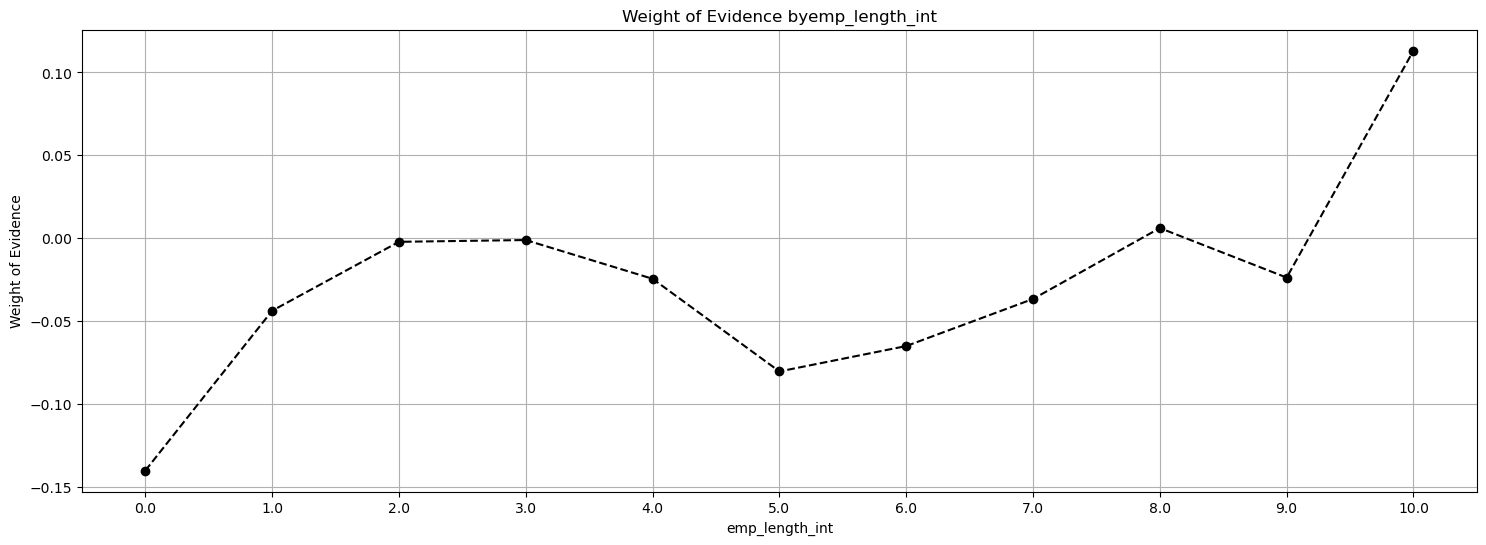

In [35]:
plot_woe(woe_ordered_continuous(X_train, 'emp_length_int', y_train))

*Since there is no clear pattern on the WoE by emp_length_int and all the IV score is < 0.02, we can decide NOT TO USE emp_length_int feature as independent/predictor variable*

#### mths_since_issue_d (weak--> IV = 0.017)

In [36]:
#Since we have many records on the mths_since_issue_date, we need to conduct a 
#Fine Classing to clasify the values into smaller group

"""
...factor = a terms used to say that a variable is categorical
pd.cut(Series, num_of_categories) = create a new series which is categorical variables with as many number of categories
as specified, indicating the interval where each observation from the series lies.
"""

X_train['mths_since_issue_date_factor'] = pd.cut(X_train['mths_since_issue_date'], 50)

In [37]:
"""
How to read the result?

(Total Records)      (Categorical Range)
427211                (>437.12 - <= 447.4)
....
"""

X_train['mths_since_issue_date_factor']

427211    (430.98, 444.04]
206088    (300.38, 313.44]
136020     (378.74, 391.8]
412305    (287.32, 300.38]
36159     (287.32, 300.38]
                ...       
259178     (326.5, 339.56]
365838    (222.02, 235.08]
131932    (222.02, 235.08]
146867     (313.44, 326.5]
121958    (430.98, 444.04]
Name: mths_since_issue_date_factor, Length: 373028, dtype: category
Categories (50, interval[float64, right]): [(-0.653, 13.06] < (13.06, 26.12] < (26.12, 39.18] < (39.18, 52.24] ... (600.76, 613.82] < (613.82, 626.88] < (626.88, 639.94] < (639.94, 653.0]]

In [38]:
woe_ordered_continuous(X_train, 'mths_since_issue_date_factor', y_train)

mths_since_issue_date_factor  n_obs  prop_good  prop_n_obs   n_good  \
0               (-0.653, 13.06]     24   0.875000    0.000064     21.0   
1                (13.06, 26.12]      0        NaN    0.000000      NaN   
2                (26.12, 39.18]      0        NaN    0.000000      NaN   
3                (39.18, 52.24]      0        NaN    0.000000      NaN   
4                 (52.24, 65.3]      0        NaN    0.000000      NaN   
5                 (65.3, 78.36]      0        NaN    0.000000      NaN   
6                (78.36, 91.42]      0        NaN    0.000000      NaN   
7               (91.42, 104.48]      0        NaN    0.000000      NaN   
8              (104.48, 117.54]      0        NaN    0.000000      NaN   
9               (117.54, 130.6]      0        NaN    0.000000      NaN   
10              (130.6, 143.66]    210   0.914286    0.000563    192.0   
11             (143.66, 156.72]   1938   0.915893    0.005195   1775.0   
12             (156.72, 169.78]   2887   0.878074    0.007739   2535.0   
13             (169.78, 182.84]   4985   0.891073    0.013364   4442.0   
14              (182.84, 195.9]   9757   0.878344    0.026156   8570.0   
15              (195.9, 208.96]  13623   0.881597    0.036520  12010.0   
16             (208.96, 222.02]  16062   0.886876    0.043058  14245.0   
17             (222.02, 235.08]  18864   0.894455    0.050570  16873.0   
18             (235.08, 248.14]  22774   0.900413    0.061052  20506.0   
19              (248.14, 261.2]  26695   0.897434    0.071563  23957.0   
20              (261.2, 274.26]  31214   0.898379    0.083677  28042.0   
21             (274.26, 287.32]  29857   0.897612    0.080040  26800.0   
22             (287.32, 300.38]  25716   0.898429    0.068939  23104.0   
23             (300.38, 313.44]  20979   0.901044    0.056240  18903.0   
24              (313.44, 326.5]  19473   0.906126    0.052203  17645.0   
25              (326.5, 339.56]  19021   0.907839    0.050991  17268.0   
26             (339.56, 352.62]  17054   0.912337    0.045718  15559.0   
27             (352.62, 365.68]  13630   0.914087    0.036539  12459.0   
28             (365.68, 378.74]   9573   0.917372    0.025663   8782.0   
29              (378.74, 391.8]   9129   0.917406    0.024473   8375.0   
30              (391.8, 404.86]   9409   0.916994    0.025223   8628.0   
31             (404.86, 417.92]   7981   0.913043    0.021395   7287.0   
32             (417.92, 430.98]   6570   0.920548    0.017613   6048.0   
33             (430.98, 444.04]   6249   0.918067    0.016752   5737.0   
34              (444.04, 457.1]   4780   0.923013    0.012814   4412.0   
35              (457.1, 470.16]   4546   0.917070    0.012187   4169.0   
36             (470.16, 483.22]   3663   0.918919    0.009820   3366.0   
37             (483.22, 496.28]   2773   0.917779    0.007434   2545.0   
38             (496.28, 509.34]   2030   0.936453    0.005442   1901.0   
39              (509.34, 522.4]   1747   0.922725    0.004683   1612.0   
40              (522.4, 535.46]   1765   0.918414    0.004732   1621.0   
41             (535.46, 548.52]   1691   0.922531    0.004533   1560.0   
42             (548.52, 561.58]   1311   0.919908    0.003514   1206.0   
43             (561.58, 574.64]    935   0.926203    0.002507    866.0   
44              (574.64, 587.7]    808   0.918317    0.002166    742.0   
45              (587.7, 600.76]    629   0.926868    0.001686    583.0   
46             (600.76, 613.82]    597   0.911223    0.001600    544.0   
47             (613.82, 626.88]    422   0.928910    0.001131    392.0   
48             (626.88, 639.94]    360   0.900000    0.000965    324.0   
49              (639.94, 653.0]   1297   0.896685    0.003477   1163.0   

     n_bad  prcnt_good  prcnt_bad       woe        IV  diff_prop_good  \
0      3.0    0.000062   0.000083 -0.282799  0.016789             NaN   
1      NaN         NaN        NaN       NaN  0.016789             NaN   
2      Na

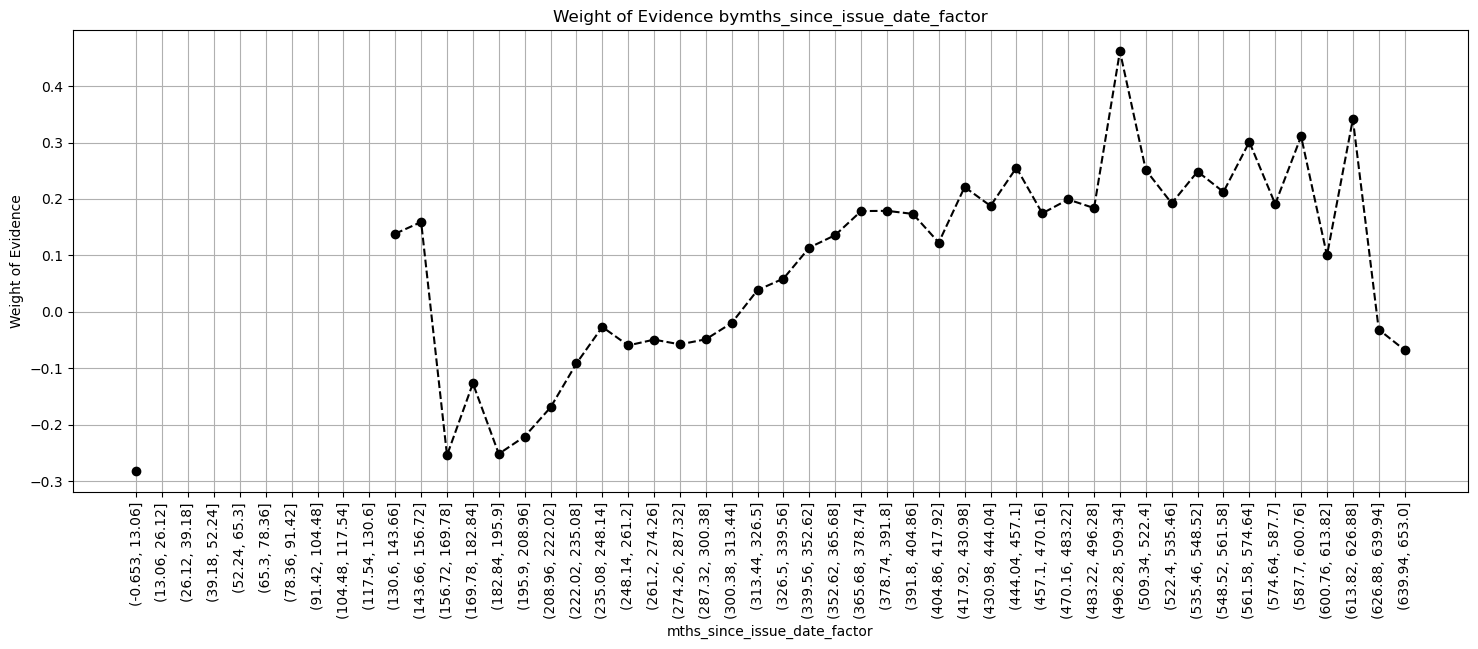

In [39]:
plot_woe(woe_ordered_continuous(X_train, 'mths_since_issue_date_factor', y_train), 90)

**The group of mths_since_issue_date will be created based on the WoE score and the n_obs**<br>

In [40]:
X_train['mths_since_issue_date:<=200'] = np.where(X_train['mths_since_issue_date'] <= 200, 1,0)

X_train['mths_since_issue_date:200-240'] = np.where(
    ((X_train['mths_since_issue_date'] >= 200) & (X_train['mths_since_issue_date'] <= 240)) , 1,0
)

X_train['mths_since_issue_date:240-282'] = np.where(
    ((X_train['mths_since_issue_date'] >= 240) & (X_train['mths_since_issue_date'] <= 282)) , 1,0
)

X_train['mths_since_issue_date:282-314'] = np.where(
    ((X_train['mths_since_issue_date'] >= 282) & (X_train['mths_since_issue_date'] <= 314)) , 1,0
)

X_train['mths_since_issue_date:314-334'] = np.where(
    ((X_train['mths_since_issue_date'] >= 314) & (X_train['mths_since_issue_date'] <= 334)) , 1,0
)

X_train['mths_since_issue_date:334-488'] = np.where(
    ((X_train['mths_since_issue_date'] >= 334) & (X_train['mths_since_issue_date'] <= 488)) , 1,0
)

X_train['mths_since_issue_date:>=488'] = np.where(
    X_train['mths_since_issue_date'] >= 488 , 1,0
)

In [41]:
X_test['mths_since_issue_date:<=200'] = np.where(X_test['mths_since_issue_date'] <= 200, 1,0)

X_test['mths_since_issue_date:200-240'] = np.where(
    ((X_test['mths_since_issue_date'] >= 200) & (X_test['mths_since_issue_date'] <= 240)) , 1,0
)

X_test['mths_since_issue_date:240-282'] = np.where(
    ((X_test['mths_since_issue_date'] >= 240) & (X_test['mths_since_issue_date'] <= 282)) , 1,0
)

X_test['mths_since_issue_date:282-314'] = np.where(
    ((X_test['mths_since_issue_date'] >= 282) & (X_test['mths_since_issue_date'] <= 314)) , 1,0
)

X_test['mths_since_issue_date:314-334'] = np.where(
    ((X_test['mths_since_issue_date'] >= 314) & (X_test['mths_since_issue_date'] <= 334)) , 1,0
)

X_test['mths_since_issue_date:334-488'] = np.where(
    ((X_test['mths_since_issue_date'] >= 334) & (X_test['mths_since_issue_date'] <= 488)) , 1,0
)

X_test['mths_since_issue_date:>=488'] = np.where(
    X_test['mths_since_issue_date'] >= 488 , 1,0
)

In [42]:
X_train.sample(5)

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
464817      464817  10077170   11929086      15850        15850   
348700      348700  20909443   23182300      10000        10000   
169873      169873   3188745    3921767      23000        23000   
168335      168335   3240797    3983705      15000        15000   
244693      244693  35883444   38578878       7000         7000   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
464817          15850.0   60 months     23.40       450.47     E        E5   
348700          10000.0   36 months     14.49       344.17     C        C4   
169873          22975.0   36 months      6.62       706.19     A        A2   
168335          15000.0   36 months     11.14       492.08     B        B2   
244693           7000.0   36 months     13.66       238.09     C        C3   

       emp_length home_ownership verification_status issue_d loan_status  \
464817    8 years       MORTGAGE            Verified  Jan-14     Current   
348700    3 years       MORTGAGE     Source Verified  Jul-14     Current   
169873  10+ years       MORTGAGE            Verified  Feb-13  Fully Paid   
168335    5 years       MORTGAGE            Verified  Feb-13  Fully Paid   
244693  10+ years           RENT     Source Verified  Nov-14     Current   

       pymnt_plan                                                url  \
464817          n  https://www.lendingclub.com/browse/loanDetail....   
348700          n  https://www.lendingclub.com/browse/loanDetail....   
169873          n  https://www.lendingclub.com/browse/loanDetail....   
168335          n  https://www.lendingclub.com/browse/loanDetail....   
244693          n  https://www.lendingclub.com/browse/loanDetail....   

                   purpose zip_code addr_state    dti  delinq_2yrs  \
464817      small_business    370xx         TN  27.47          0.0   
348700         credit_card    333xx         FL   2.73          0.0   
169873         credit_card    490xx         MI   7.19          0.0   
168335              moving    945xx         CA   5.44          0.0   
244693  debt_consolidation    995xx         AK  19.44          0.0   

       earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
464817           Nov-00             1.0                     0.0   
348700           May-07             3.0                    80.0   
169873           Aug-02             0.0                     0.0   
168335           Jan-98             3.0                     0.0   
244693           Oct-99             0.0                    25.0   

        mths_since_last_record  open_acc  pub_rec  revol_bal  total_acc  \
464817                     0.0      10.0      0.0      17316       41.0   
348700                     0.0      12.0      0.0       5550       22.0   
169873                     0.0      10.0      0.0      26566       13.0   
168335                     0.0      13.0      0.0      19665       36.0   
244693                     0.0       7.0      0.0       7859       25.0   

       initial_list_status  out_prncp  out_prncp_inv  total_pymnt  \
464817                   f   11574.65       11574.65   10811.2500   
348700                   w    5537.85        5537.85    6195.0600   
169873                   f       0.00           0.00   25140.1352   
168335                   w       0.00           0.00   16618.1700   
244693                   f    4610.50        4610.50    3327.9500   

        total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
464817         10811.25          4275.35        6535.90                 0.0   
348700          6195.06          4462.15        1732.91                 0.0   
169873         25112.82         23000.00        2140.14                 0.0   
168335         16618.17         15000.00        1618.17                 0.0   
244693          3327.95          2389.50         938.45                 0.0   

        recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
4648

#### int_rate

In [43]:
X_train['int_rate'].value_counts()

12.99    12622
10.99    11893
15.61    10389
8.90      9135
16.29     8471
         ...  
24.59        1
17.78        1
17.46        1
22.64        1
13.84        1
Name: int_rate, Length: 504, dtype: int64

In [44]:
X_train['int_rate_factor'] = pd.cut(X_train['int_rate'], 50)

In [45]:
woe_ordered_continuous(X_train, 'int_rate_factor', y_train)

int_rate_factor  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0     (5.399, 5.833]    785   0.961783    0.002104    755.0    30.0   
1     (5.833, 6.246]   8459   0.982149    0.022677   8308.0   151.0   
2     (6.246, 6.658]   7826   0.974572    0.020980   7627.0   199.0   
3     (6.658, 7.071]   1816   0.974119    0.004868   1769.0    47.0   
4     (7.071, 7.484]   3143   0.980274    0.008426   3081.0    62.0   
5     (7.484, 7.897]  12581   0.966219    0.033727  12156.0   425.0   
6      (7.897, 8.31]   9687   0.954062    0.025969   9242.0   445.0   
7      (8.31, 8.722]   6594   0.973612    0.017677   6420.0   174.0   
8     (8.722, 9.135]   9539   0.940979    0.025572   8976.0   563.0   
9     (9.135, 9.548]   6681   0.971711    0.017910   6492.0   189.0   
10    (9.548, 9.961]   7588   0.937533    0.020342   7114.0   474.0   
11   (9.961, 10.374]  10941   0.940408    0.029330  10289.0   652.0   
12  (10.374, 10.786]   5857   0.918730    0.015701   5381.0   476.0   
13  (10.786, 11.199]  17851   0.937370    0.047854  16733.0  1118.0   
14  (11.199, 11.612]   4876   0.923298    0.013071   4502.0   374.0   
15  (11.612, 12.025]  15597   0.942297    0.041812  14697.0   900.0   
16  (12.025, 12.438]  12336   0.899481    0.033070  11096.0  1240.0   
17   (12.438, 12.85]  11065   0.934659    0.029663  10342.0   723.0   
18   (12.85, 13.263]  21329   0.915092    0.057178  19518.0  1811.0   
19  (13.263, 13.676]  15392   0.922297    0.041262  14196.0  1196.0   
20  (13.676, 14.089]  10991   0.911109    0.029464  10014.0   977.0   
21  (14.089, 14.502]  23436   0.900282    0.062826  21099.0  2337.0   
22  (14.502, 14.914]   4333   0.872606    0.011616   3781.0   552.0   
23  (14.914, 15.327]  18932   0.895151    0.050752  16947.0  1985.0   
24   (15.327, 15.74]  12327   0.906952    0.033046  11180.0  1147.0   
25   (15.74, 16.153]   7477   0.849271    0.020044   6350.0  1127.0   
26  (16.153, 16.566]  12991   0.876684    0.034826  11389.0  1602.0   
27  (16.566, 16.978]   4237   0.857682    0.011358   3634.0   603.0   
28  (16.978, 17.391]  11396   0.869252    0.030550   9906.0  1490.0   
29  (17.391, 17.804]  12288   0.858724    0.032941  10552.0  1736.0   
30  (17.804, 18.217]   1306   0.839204    0.003501   1096.0   210.0   
31   (18.217, 18.63]  11036   0.852664    0.029585   9410.0  1626.0   
32   (18.63, 19.042]   6808   0.837397    0.018251   5701.0  1107.0   
33  (19.042, 19.455]   4425   0.817401    0.011862   3617.0   808.0   
34  (19.455, 19.868]   6763   0.844004    0.018130   5708.0  1055.0   
35  (19.868, 20.281]   4899   0.854052    0.013133   4184.0   715.0   
36  (20.281, 20.694]   3221   0.814964    0.008635   2625.0   596.0   
37  (20.694, 21.106]   4016   0.824203    0.010766   3310.0   706.0   
38  (21.106, 21.519]   2729   0.799560    0.007316   2182.0   547.0   
39  (21.519, 21.932]    989   0.775531    0.002651    767.0   222.0   
40  (21.932, 22.345]   3476   0.815305    0.009318   2834.0   642.0   
41  (22.345, 22.758]   2251   0.779653    0.006034   1755.0   496.0   
42   (22.758, 23.17]   1535   0.788274    0.004115   1210.0   325.0   
43   (23.17, 23.583]   2652   0.804676    0.007109   2134.0   518.0   
44  (23.583, 23.996]   1573   0.742530    0.004217   1168.0   405.0   
45  (23.996, 24.409]   1455   0.795189    0.003901   1157.0   298.0   
46  (24.409, 24.822]   1664   0.787861    0.004461   1311.0   353.0   
47  (24.822, 25.234]   1315   0.790114    0.003525   1039.0   276.0   
48  (25.234, 25.647]    778   0.775064    0.002086    603.0   175.0   
49   (25.647, 26.06]   1786   0.790594    0.004788   1412.0   374.0   

    prcnt_good  prcnt_bad       woe        IV  diff_prop_good  diff_woe  
0     0.002242   0.000827  0.996811  0.345435             NaN       NaN  
1     0.024670   0.004164  1.778985  0.345435        0.020366  0.782174  
2     0.022648   0.005488  1.417435  0.345435        0.007577  0.361549  
3     0.005253   0.001296  1.399312  0.345435        0.000453  0.018123  
4     0.00914

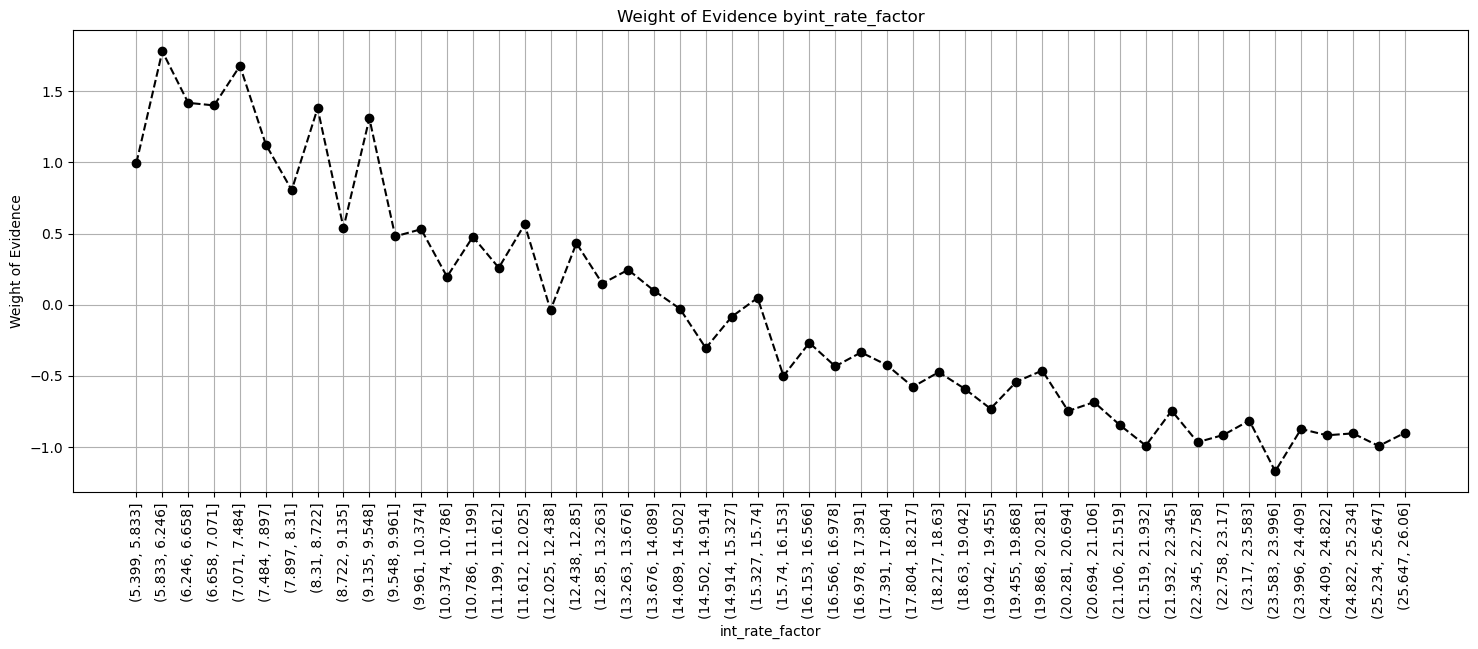

In [46]:
plot_woe(woe_ordered_continuous(X_train, 'int_rate_factor', y_train), 90)

In [47]:
X_train['int_rate:<=8'] = np.where(X_train['int_rate'] <= 8, 1,0)
X_train['int_rate:8-10'] = np.where(((X_train['int_rate'] >=8 ) & (X_train['int_rate'] <= 10)) , 1,0)
X_train['int_rate:10-14'] = np.where(((X_train['int_rate'] >=10 ) & (X_train['int_rate'] <= 14)) , 1,0)
X_train['int_rate:14-19'] = np.where(((X_train['int_rate'] >=14 ) & (X_train['int_rate'] <= 19)) , 1,0)
X_train['int_rate:>=19'] = np.where(X_train['int_rate'] >=19, 1,0)

In [48]:
X_test['int_rate:<=8'] = np.where(X_test['int_rate'] <= 8, 1,0)
X_test['int_rate:8-10'] = np.where(((X_test['int_rate'] >=8 ) & (X_test['int_rate'] <= 10)) , 1,0)
X_test['int_rate:10-14'] = np.where(((X_test['int_rate'] >=10 ) & (X_test['int_rate'] <= 14)) , 1,0)
X_test['int_rate:14-19'] = np.where(((X_test['int_rate'] >=14 ) & (X_test['int_rate'] <= 19)) , 1,0)
X_test['int_rate:>=19'] = np.where(X_test['int_rate'] >=19, 1,0)

#### funded_amnt

In [49]:
X_train['funded_amnt_factor'] = pd.cut(X_train['funded_amnt'], 50)

In [50]:
woe_ordered_continuous(X_train, 'funded_amnt_factor', y_train)

funded_amnt_factor  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0      (465.5, 1190.0]   1224   0.913399    0.003281   1118.0   106.0   
1     (1190.0, 1880.0]   3028   0.908520    0.008117   2751.0   277.0   
2     (1880.0, 2570.0]   6018   0.899634    0.016133   5414.0   604.0   
3     (2570.0, 3260.0]   7248   0.895695    0.019430   6492.0   756.0   
4     (3260.0, 3950.0]   4751   0.896864    0.012736   4261.0   490.0   
5     (3950.0, 4640.0]   9023   0.898703    0.024189   8109.0   914.0   
6     (4640.0, 5330.0]  15903   0.902471    0.042632  14352.0  1551.0   
7     (5330.0, 6020.0]  17236   0.914307    0.046206  15759.0  1477.0   
8     (6020.0, 6710.0]   6914   0.896731    0.018535   6200.0   714.0   
9     (6710.0, 7400.0]  11806   0.910300    0.031649  10747.0  1059.0   
10    (7400.0, 8090.0]  17692   0.907981    0.047428  16064.0  1628.0   
11    (8090.0, 8780.0]   6316   0.895028    0.016932   5653.0   663.0   
12    (8780.0, 9470.0]   9168   0.892343    0.024577   8181.0   987.0   
13   (9470.0, 10160.0]  33410   0.907902    0.089564  30333.0  3077.0   
14  (10160.0, 10850.0]   6755   0.890303    0.018109   6014.0   741.0   
15  (10850.0, 11540.0]   8559   0.893679    0.022945   7649.0   910.0   
16  (11540.0, 12230.0]  23506   0.914745    0.063014  21502.0  2004.0   
17  (12230.0, 12920.0]   4802   0.889213    0.012873   4270.0   532.0   
18  (12920.0, 13610.0]   7247   0.908928    0.019427   6587.0   660.0   
19  (13610.0, 14300.0]   8123   0.907423    0.021776   7371.0   752.0   
20  (14300.0, 14990.0]   5183   0.889639    0.013894   4611.0   572.0   
21  (14990.0, 15680.0]  21757   0.911569    0.058325  19833.0  1924.0   
22  (15680.0, 16370.0]  11788   0.896166    0.031601  10564.0  1224.0   
23  (16370.0, 17060.0]   6538   0.886968    0.017527   5799.0   739.0   
24  (17060.0, 17750.0]   3422   0.880187    0.009174   3012.0   410.0   
25  (17750.0, 18440.0]  11441   0.896862    0.030671  10261.0  1180.0   
26  (18440.0, 19130.0]   3919   0.882368    0.010506   3458.0   461.0   
27  (19130.0, 19820.0]   4004   0.875624    0.010734   3506.0   498.0   
28  (19820.0, 20510.0]  20287   0.912801    0.054385  18518.0  1769.0   
29  (20510.0, 21200.0]   6712   0.907628    0.017993   6092.0   620.0   
30  (21200.0, 21890.0]   2081   0.864969    0.005579   1800.0   281.0   
31  (21890.0, 22580.0]   4114   0.903500    0.011029   3717.0   397.0   
32  (22580.0, 23270.0]   2445   0.894888    0.006554   2188.0   257.0   
33  (23270.0, 23960.0]   1825   0.865205    0.004892   1579.0   246.0   
34  (23960.0, 24650.0]   9836   0.915819    0.026368   9008.0   828.0   
35  (24650.0, 25340.0]  10074   0.902224    0.027006   9089.0   985.0   
36  (25340.0, 26030.0]   1832   0.884825    0.004911   1621.0   211.0   
37  (26030.0, 26720.0]   1252   0.853834    0.003356   1069.0   183.0   
38  (26720.0, 27410.0]   1510   0.882781    0.004048   1333.0   177.0   
39  (27410.0, 28100.0]   6457   0.920861    0.017310   5946.0   511.0   
40  (28100.0, 28790.0]    795   0.876730    0.002131    697.0    98.0   
41  (28790.0, 29480.0]   1176   0.880952    0.003153   1036.0   140.0   
42  (29480.0, 30170.0]   7308   0.900794    0.019591   6583.0   725.0   
43  (30170.0, 30860.0]    567   0.848325    0.001520    481.0    86.0   
44  (30860.0, 31550.0]    884   0.900452    0.002370    796.0    88.0   
45  (31550.0, 32240.0]   1326   0.893665    0.003555   1185.0   141.0   
46  (32240.0, 32930.0]    631   0.893819    0.001692    564.0    67.0   
47  (32930.0, 33620.0]   1090   0.909174    0.002922    991.0    99.0   
48  (33620.0, 34310.0]    492   0.904472    0.001319    445.0    47.0   
49  (34310.0, 35000.0]  13553   0.897218    0.036332  12160.0  1393.0   

    prcnt_good  prcnt_bad       woe        IV  diff_prop_good  diff_woe  
0     0.003320   0.002923  0.127148  0.014711             NaN       NaN  
1     0.008169   0.007639  0.066993  0.014711        0.004878  0.060155  
2     0.016076   0.016658 -0.035540  0.014711        0.008

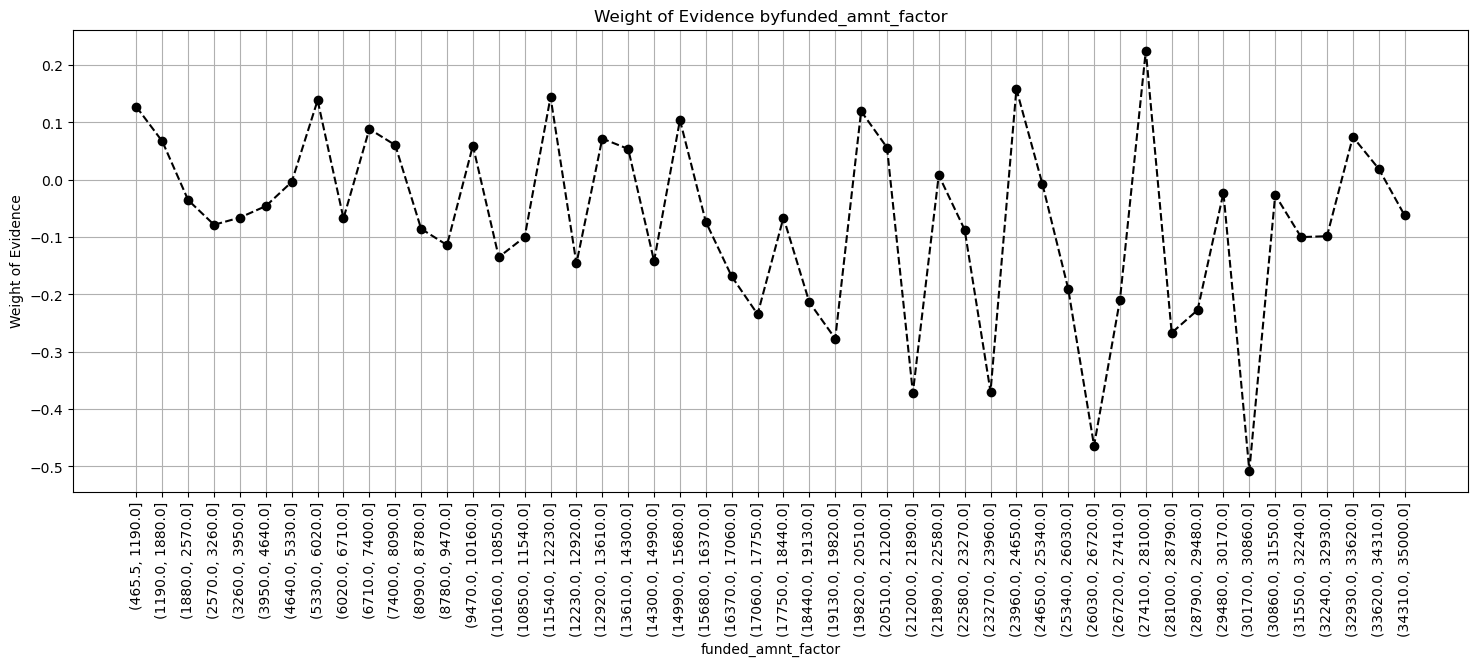

In [51]:
plot_woe(woe_ordered_continuous(X_train, 'funded_amnt_factor', y_train), 90)

*Since there is no clear pattern on the WoE by funded_amnt, we can decide NOT TO USE funded_amnt feature as independent/predictor variable*

#### mths_since_earliest_cr_line (weak --> IV = 0.017)

In [52]:
X_train['mths_since_earliest_cr_line_factor'] = pd.cut(X_train['mths_since_earliest_cr_line'], 50)

In [53]:
woe_ordered_continuous(X_train, 'mths_since_earliest_cr_line_factor', y_train)

mths_since_earliest_cr_line_factor  n_obs  prop_good  prop_n_obs   n_good  \
0                     (-0.653, 13.06]     24   0.875000    0.000064     21.0   
1                      (13.06, 26.12]      0        NaN    0.000000      NaN   
2                      (26.12, 39.18]      0        NaN    0.000000      NaN   
3                      (39.18, 52.24]      0        NaN    0.000000      NaN   
4                       (52.24, 65.3]      0        NaN    0.000000      NaN   
5                       (65.3, 78.36]      0        NaN    0.000000      NaN   
6                      (78.36, 91.42]      0        NaN    0.000000      NaN   
7                     (91.42, 104.48]      0        NaN    0.000000      NaN   
8                    (104.48, 117.54]      0        NaN    0.000000      NaN   
9                     (117.54, 130.6]      0        NaN    0.000000      NaN   
10                    (130.6, 143.66]    210   0.914286    0.000563    192.0   
11                   (143.66, 156.72]   1938   0.915893    0.005195   1775.0   
12                   (156.72, 169.78]   2887   0.878074    0.007739   2535.0   
13                   (169.78, 182.84]   4985   0.891073    0.013364   4442.0   
14                    (182.84, 195.9]   9757   0.878344    0.026156   8570.0   
15                    (195.9, 208.96]  13623   0.881597    0.036520  12010.0   
16                   (208.96, 222.02]  16062   0.886876    0.043058  14245.0   
17                   (222.02, 235.08]  18864   0.894455    0.050570  16873.0   
18                   (235.08, 248.14]  22774   0.900413    0.061052  20506.0   
19                    (248.14, 261.2]  26695   0.897434    0.071563  23957.0   
20                    (261.2, 274.26]  31214   0.898379    0.083677  28042.0   
21                   (274.26, 287.32]  29857   0.897612    0.080040  26800.0   
22                   (287.32, 300.38]  25716   0.898429    0.068939  23104.0   
23                   (300.38, 313.44]  20979   0.901044    0.056240  18903.0   
24                    (313.44, 326.5]  19473   0.906126    0.052203  17645.0   
25                    (326.5, 339.56]  19021   0.907839    0.050991  17268.0   
26                   (339.56, 352.62]  17054   0.912337    0.045718  15559.0   
27                   (352.62, 365.68]  13630   0.914087    0.036539  12459.0   
28                   (365.68, 378.74]   9573   0.917372    0.025663   8782.0   
29                    (378.74, 391.8]   9129   0.917406    0.024473   8375.0   
30                    (391.8, 404.86]   9409   0.916994    0.025223   8628.0   
31                   (404.86, 417.92]   7981   0.913043    0.021395   7287.0   
32                   (417.92, 430.98]   6570   0.920548    0.017613   6048.0   
33                   (430.98, 444.04]   6249   0.918067    0.016752   5737.0   
34                    (444.04, 457.1]   4780   0.923013    0.012814   4412.0   
35                    (457.1, 470.16]   4546   0.917070    0.012187   4169.0   
36                   (470.16, 483.22]   3663   0.918919    0.009820   3366.0   
37                   (483.22, 496.28]   2773   0.917779    0.007434   2545.0   
38                   (496.28, 509.34]   2030   0.936453    0.005442   1901.0   
39                    (509.34, 522.4]   1747   0.922725    0.004683   1612.0   
40                    (522.4, 535.46]   1765   0.918414    0.004732   1621.0   
41                   (535.46, 548.52]   1691   0.922531    0.004533   1560.0   
42                   (548.52, 561.58]   1311   0.919908    0.003514   1206.0   
43                   (561.58, 574.64]    935   0.926203    0.002507    866.0   
44                    (574.64, 587.7]    808   0.918317    0.002166    742.0   
45                    (587.7, 600.76]    629   0.926868    0.001686    583.0   
46                   (600.76, 613.82]    597   0.911223    0.001600    544.0   
47                   (613.82, 626.88]    422   0.928910    0.001131    392.0   
48                   (626.88, 639.94]    360   0.900000    0.000965    324.0   
49 

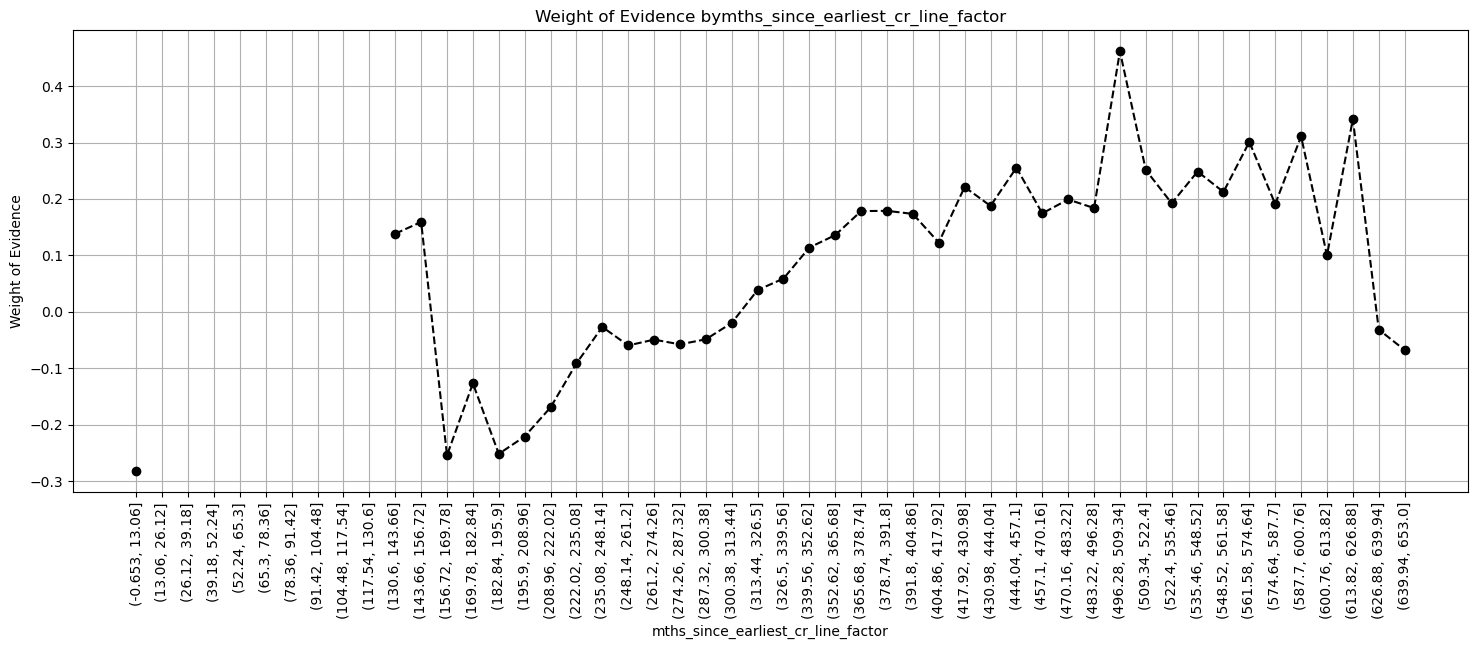

In [54]:
plot_woe(woe_ordered_continuous(X_train, 'mths_since_earliest_cr_line_factor', y_train), 90)

In [55]:
X_train['mths_since_earliest_cr_line:<=190'] = np.where(
    X_train['mths_since_earliest_cr_line'] <= 190 ,1, 0
)

X_train['mths_since_earliest_cr_line:190-293'] = np.where(
    ((X_train['mths_since_earliest_cr_line'] >= 190) & (X_train['mths_since_earliest_cr_line'] <= 293)),1, 0
)

X_train['mths_since_earliest_cr_line:293-344'] = np.where(
    ((X_train['mths_since_earliest_cr_line'] >= 293) & (X_train['mths_since_earliest_cr_line'] <= 344)),1, 0
)

X_train['mths_since_earliest_cr_line:344-498'] = np.where(
    ((X_train['mths_since_earliest_cr_line'] >= 344) & (X_train['mths_since_earliest_cr_line'] <= 498)),1, 0
)

X_train['mths_since_earliest_cr_line:>=498'] = np.where(
    X_train['mths_since_earliest_cr_line'] >= 498 ,1, 0
)

In [56]:
X_test['mths_since_earliest_cr_line:<=190'] = np.where(
    X_test['mths_since_earliest_cr_line'] <= 190 ,1, 0
)

X_test['mths_since_earliest_cr_line:190-293'] = np.where(
    ((X_test['mths_since_earliest_cr_line'] >= 190) & (X_test['mths_since_earliest_cr_line'] <= 293)),1, 0
)

X_test['mths_since_earliest_cr_line:293-344'] = np.where(
    ((X_test['mths_since_earliest_cr_line'] >= 293) & (X_test['mths_since_earliest_cr_line'] <= 344)),1, 0
)

X_test['mths_since_earliest_cr_line:344-498'] = np.where(
    ((X_test['mths_since_earliest_cr_line'] >= 344) & (X_test['mths_since_earliest_cr_line'] <= 498)),1, 0
)

X_test['mths_since_earliest_cr_line:>=498'] = np.where(
    X_test['mths_since_earliest_cr_line'] >= 498 ,1, 0
)

#### installment

In [57]:
X_train['installment_factor'] = pd.cut(X_train['installment'], 50)

In [58]:
woe_ordered_continuous(X_train, 'installment_factor', y_train)

installment_factor  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0       (14.276, 43.556]   1812   0.911700    0.004858   1652.0   160.0   
1       (43.556, 71.443]   4841   0.902913    0.012978   4371.0   470.0   
2       (71.443, 99.329]   6824   0.898007    0.018294   6128.0   696.0   
3      (99.329, 127.216]   9138   0.895820    0.024497   8186.0   952.0   
4     (127.216, 155.102]  10040   0.902789    0.026915   9064.0   976.0   
5     (155.102, 182.988]  16816   0.904912    0.045080  15217.0  1599.0   
6     (182.988, 210.875]  17216   0.912465    0.046152  15709.0  1507.0   
7     (210.875, 238.761]  15090   0.910338    0.040453  13737.0  1353.0   
8     (238.761, 266.648]  18842   0.913650    0.050511  17215.0  1627.0   
9     (266.648, 294.534]  20100   0.905075    0.053883  18192.0  1908.0   
10     (294.534, 322.42]  20364   0.910430    0.054591  18540.0  1824.0   
11     (322.42, 350.307]  25521   0.903256    0.068416  23052.0  2469.0   
12    (350.307, 378.193]  19006   0.898874    0.050951  17084.0  1922.0   
13     (378.193, 406.08]  18079   0.906355    0.048466  16386.0  1693.0   
14     (406.08, 433.966]  13345   0.891120    0.035775  11892.0  1453.0   
15    (433.966, 461.852]  12574   0.897487    0.033708  11285.0  1289.0   
16    (461.852, 489.739]  15685   0.905834    0.042048  14208.0  1477.0   
17    (489.739, 517.625]  15648   0.903438    0.041949  14137.0  1511.0   
18    (517.625, 545.512]  10775   0.881299    0.028885   9496.0  1279.0   
19    (545.512, 573.398]  10558   0.890699    0.028304   9404.0  1154.0   
20    (573.398, 601.284]   9464   0.891801    0.025371   8440.0  1024.0   
21    (601.284, 629.171]   9341   0.914463    0.025041   8542.0   799.0   
22    (629.171, 657.057]   8357   0.908939    0.022403   7596.0   761.0   
23    (657.057, 684.944]   9171   0.905899    0.024585   8308.0   863.0   
24     (684.944, 712.83]   6171   0.894831    0.016543   5522.0   649.0   
25     (712.83, 740.716]   4841   0.897335    0.012978   4344.0   497.0   
26    (740.716, 768.603]   5231   0.908431    0.014023   4752.0   479.0   
27    (768.603, 796.489]   4926   0.917783    0.013205   4521.0   405.0   
28    (796.489, 824.376]   4050   0.901728    0.010857   3652.0   398.0   
29    (824.376, 852.262]   3643   0.901729    0.009766   3285.0   358.0   
30    (852.262, 880.148]   4260   0.903991    0.011420   3851.0   409.0   
31    (880.148, 908.035]   3247   0.890976    0.008704   2893.0   354.0   
32    (908.035, 935.921]   2189   0.892188    0.005868   1953.0   236.0   
33    (935.921, 963.808]   2440   0.888525    0.006541   2168.0   272.0   
34    (963.808, 991.694]   1787   0.849468    0.004791   1518.0   269.0   
35    (991.694, 1019.58]   1617   0.874459    0.004335   1414.0   203.0   
36   (1019.58, 1047.467]   1267   0.887924    0.003397   1125.0   142.0   
37  (1047.467, 1075.353]    898   0.905345    0.002407    813.0    85.0   
38   (1075.353, 1103.24]   1035   0.937198    0.002775    970.0    65.0   
39   (1103.24, 1131.126]    832   0.930288    0.002230    774.0    58.0   
40  (1131.126, 1159.012]    972   0.932099    0.002606    906.0    66.0   
41  (1159.012, 1186.899]   1181   0.927180    0.003166   1095.0    86.0   
42  (1186.899, 1214.785]   1252   0.912939    0.003356   1143.0   109.0   
43  (1214.785, 1242.672]   1019   0.900883    0.002732    918.0   101.0   
44  (1242.672, 1270.558]    711   0.867792    0.001906    617.0    94.0   
45  (1270.558, 1298.444]    457   0.838074    0.001225    383.0    74.0   
46  (1298.444, 1326.331]    197   0.796954    0.000528    157.0    40.0   
47  (1326.331, 1354.217]    121   0.776860    0.000324     94.0    27.0   
48  (1354.217, 1382.104]     41   0.731707    0.000110     30.0    11.0   
49   (1382.104, 1409.99]     36   0.833333    0.000097     30.0     6.0   

    prcnt_good  prcnt_bad       woe        IV  diff_prop_good  diff_woe  
0     0.004905   0.004413  0.105859  0.013047             NaN       NaN  
1     0.012979   0.012962  0.001

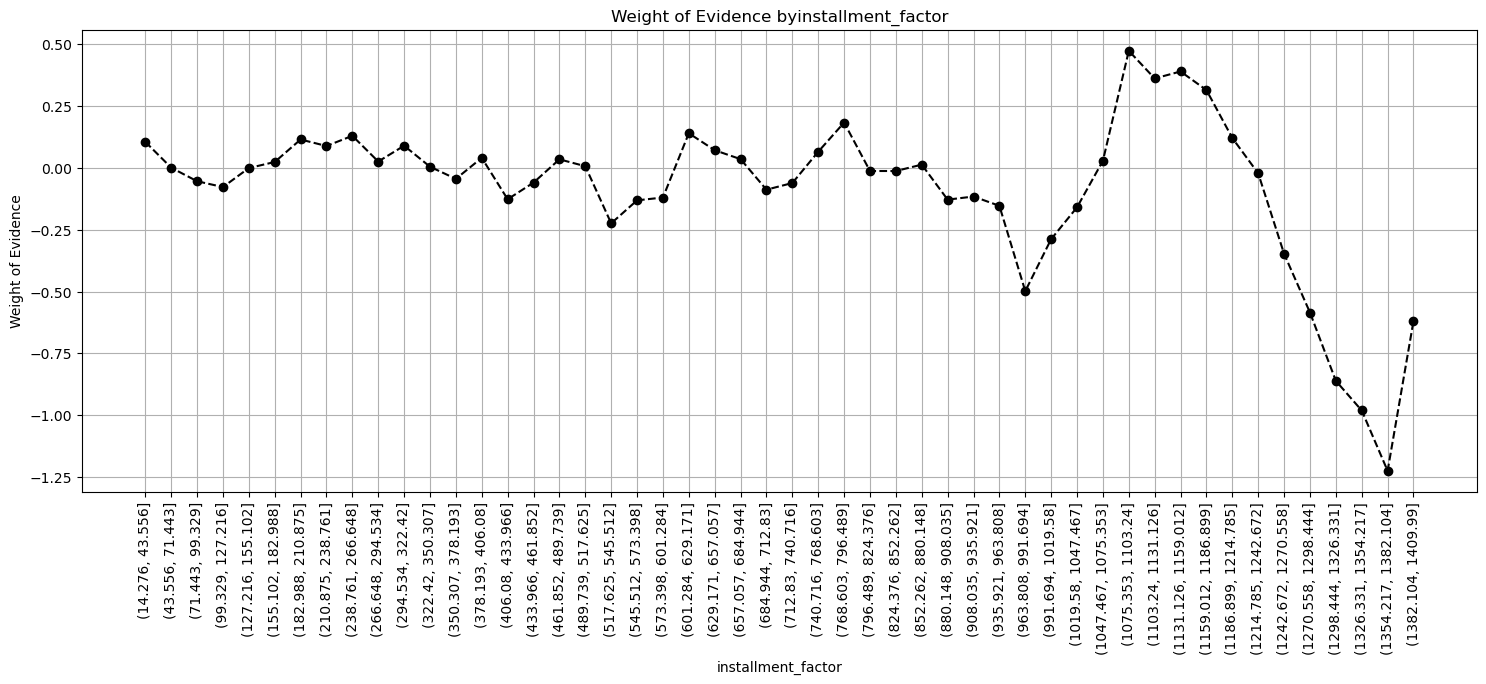

In [59]:
plot_woe(woe_ordered_continuous(X_train, 'installment_factor', y_train),90)

*Since there is no clear pattern on the WoE by funded_amnt, we can decide NOT TO USE installment feature as independent/predictor variable*

#### delinq_2yrs

In [60]:
X_train['delinq_2yrs'] = pd.cut(X_train['delinq_2yrs'], 50)

In [61]:
woe_ordered_continuous(X_train, 'delinq_2yrs', y_train)

delinq_2yrs   n_obs  prop_good  prop_n_obs    n_good    n_bad  \
0   (-0.029, 0.58]  306417   0.902120    0.821432  276425.0  29992.0   
1     (0.58, 1.16]   44927   0.906693    0.120439   40735.0   4192.0   
2     (1.16, 1.74]       0        NaN    0.000000       NaN      NaN   
3     (1.74, 2.32]   13118   0.904787    0.035166   11869.0   1249.0   
4      (2.32, 2.9]       0        NaN    0.000000       NaN      NaN   
5      (2.9, 3.48]    4550   0.901758    0.012197    4103.0    447.0   
6     (3.48, 4.06]    1868   0.910600    0.005008    1701.0    167.0   
7     (4.06, 4.64]       0        NaN    0.000000       NaN      NaN   
8     (4.64, 5.22]     966   0.894410    0.002590     864.0    102.0   
9      (5.22, 5.8]       0        NaN    0.000000       NaN      NaN   
10     (5.8, 6.38]     501   0.922156    0.001343     462.0     39.0   
11    (6.38, 6.96]       0        NaN    0.000000       NaN      NaN   
12    (6.96, 7.54]     279   0.885305    0.000748     247.0     32.0   
13    (7.54, 8.12]     148   0.932432    0.000397     138.0     10.0   
14     (8.12, 8.7]       0        NaN    0.000000       NaN      NaN   
15     (8.7, 9.28]      89   0.898876    0.000239      80.0      9.0   
16    (9.28, 9.86]       0        NaN    0.000000       NaN      NaN   
17   (9.86, 10.44]      56   0.910714    0.000150      51.0      5.0   
18  (10.44, 11.02]      31   0.903226    0.000083      28.0      3.0   
19   (11.02, 11.6]       0        NaN    0.000000       NaN      NaN   
20   (11.6, 12.18]      30   0.766667    0.000080      23.0      7.0   
21  (12.18, 12.76]       0        NaN    0.000000       NaN      NaN   
22  (12.76, 13.34]      18   0.944444    0.000048      17.0      1.0   
23  (13.34, 13.92]       0        NaN    0.000000       NaN      NaN   
24   (13.92, 14.5]       6   0.833333    0.000016       5.0      1.0   
25   (14.5, 15.08]       6   0.833333    0.000016       5.0      1.0   
26  (15.08, 15.66]       0        NaN    0.000000       NaN      NaN   
27  (15.66, 16.24]       4   1.000000    0.000011       4.0      0.0   
28  (16.24, 16.82]       0        NaN    0.000000       NaN      NaN   
29   (16.82, 17.4]       3   0.666667    0.000008       2.0      1.0   
30   (17.4, 17.98]       0        NaN    0.000000       NaN      NaN   
31  (17.98, 18.56]       3   0.666667    0.000008       2.0      1.0   
32  (18.56, 19.14]       2   1.000000    0.000005       2.0      0.0   
33  (19.14, 19.72]       0        NaN    0.000000       NaN      NaN   
34   (19.72, 20.3]       0        NaN    0.000000       NaN      NaN   
35   (20.3, 20.88]       0        NaN    0.000000       NaN      NaN   
36  (20.88, 21.46]       2   1.000000    0.000005       2.0      0.0   
37  (21.46, 22.04]       2   1.000000    0.000005       2.0      0.0   
38  (22.04, 22.62]       0        NaN    0.000000       NaN      NaN   
39   (22.62, 23.2]       0        NaN    0.000000       NaN      NaN   
40   (23.2, 23.78]       0        NaN    0.000000       NaN      NaN   
41  (23.78, 24.36]       1   1.000000    0.000003       1.0      0.0   
42  (24.36, 24.94]       0        NaN    0.000000       NaN      NaN   
43  (24.94, 25.52]       0        NaN    0.000000       NaN      NaN   
44   (25.52, 26.1]       0        NaN    0.000000       NaN      NaN   
45   (26.1, 26.68]       0        NaN    0.000000       NaN      NaN   
46  (26.68, 27.26]       0        NaN    0.000000       NaN      NaN   
47  (27.26, 27.84]       0        NaN    0.000000       NaN      NaN   
48  (27.84, 28.42]       0        NaN    0.000000       NaN      NaN   
49   (28.42, 29.0]       1   1.000000    0.000003       1.0      0.0   

    prcnt_good  prcnt_bad       woe   IV  diff_prop_good  diff_woe  
0     0.820815   0.827160 -0.007701  inf             NaN       NaN  
1     0.120958   0.115613  0.045200  inf        0.004573  0.052901  
2          NaN        NaN       NaN  inf             NaN       NaN  
3     0.035244   0.034447  0.022877  inf             NaN  

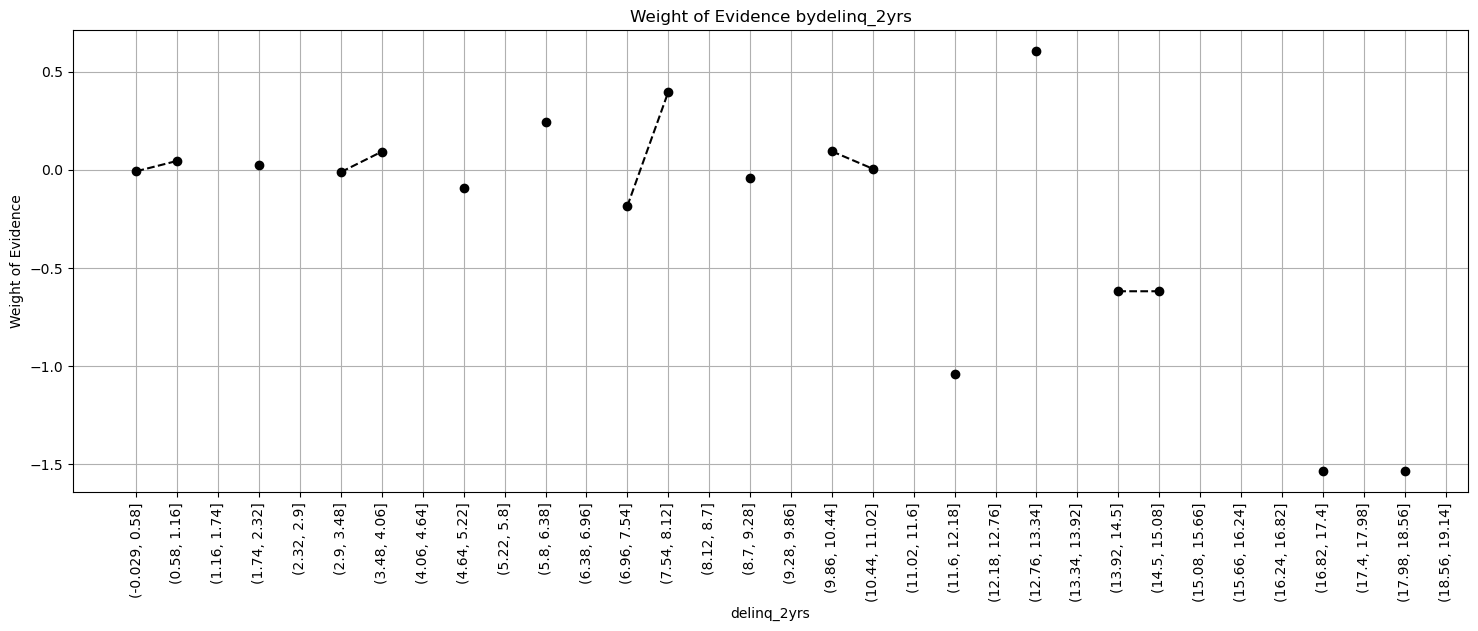

In [62]:
plot_woe(woe_ordered_continuous(X_train, 'delinq_2yrs', y_train), 90)

*Since there is no clear pattern on the WoE by funded_amnt, we can decide NOT TO USE delinq_2yrs feature as independent/predictor variable*

#### inq_last_6mths

In [63]:
X_train['inq_last_6mths_factor'] = pd.cut(X_train['inq_last_6mths'], 50)

In [64]:
woe_ordered_continuous(X_train, 'inq_last_6mths_factor', y_train)

inq_last_6mths_factor   n_obs  prop_good  prop_n_obs    n_good    n_bad  \
0         (-0.033, 0.66]  193232   0.919511    0.518009  177679.0  15553.0   
1           (0.66, 1.32]  104163   0.897804    0.279236   93518.0  10645.0   
2           (1.32, 1.98]       0        NaN    0.000000       NaN      NaN   
3           (1.98, 2.64]   46214   0.877786    0.123889   40566.0   5648.0   
4            (2.64, 3.3]   20040   0.853543    0.053723   17105.0   2935.0   
5            (3.3, 3.96]       0        NaN    0.000000       NaN      NaN   
6           (3.96, 4.62]    5810   0.861790    0.015575    5007.0    803.0   
7           (4.62, 5.28]    2217   0.839874    0.005943    1862.0    355.0   
8           (5.28, 5.94]       0        NaN    0.000000       NaN      NaN   
9            (5.94, 6.6]     977   0.803480    0.002619     785.0    192.0   
10           (6.6, 7.26]     159   0.679245    0.000426     108.0     51.0   
11          (7.26, 7.92]       0        NaN    0.000000       NaN      NaN   
12          (7.92, 8.58]     101   0.643564    0.000271      65.0     36.0   
13          (8.58, 9.24]      43   0.674419    0.000115      29.0     14.0   
14           (9.24, 9.9]       0        NaN    0.000000       NaN      NaN   
15          (9.9, 10.56]      17   0.882353    0.000046      15.0      2.0   
16        (10.56, 11.22]       8   0.625000    0.000021       5.0      3.0   
17        (11.22, 11.88]       0        NaN    0.000000       NaN      NaN   
18        (11.88, 12.54]      12   0.500000    0.000032       6.0      6.0   
19         (12.54, 13.2]       5   0.800000    0.000013       4.0      1.0   
20         (13.2, 13.86]       0        NaN    0.000000       NaN      NaN   
21        (13.86, 14.52]       5   0.200000    0.000013       1.0      4.0   
22        (14.52, 15.18]       9   0.444444    0.000024       4.0      5.0   
23        (15.18, 15.84]       0        NaN    0.000000       NaN      NaN   
24         (15.84, 16.5]       3   1.000000    0.000008       3.0      0.0   
25         (16.5, 17.16]       2   0.500000    0.000005       1.0      1.0   
26        (17.16, 17.82]       0        NaN    0.000000       NaN      NaN   
27        (17.82, 18.48]       2   0.500000    0.000005       1.0      1.0   
28        (18.48, 19.14]       1   1.000000    0.000003       1.0      0.0   
29         (19.14, 19.8]       0        NaN    0.000000       NaN      NaN   
30         (19.8, 20.46]       1   0.000000    0.000003       0.0      1.0   
31        (20.46, 21.12]       0        NaN    0.000000       NaN      NaN   
32        (21.12, 21.78]       0        NaN    0.000000       NaN      NaN   
33        (21.78, 22.44]       0        NaN    0.000000       NaN      NaN   
34         (22.44, 23.1]       0        NaN    0.000000       NaN      NaN   
35         (23.1, 23.76]       0        NaN    0.000000       NaN      NaN   
36        (23.76, 24.42]       1   1.000000    0.000003       1.0      0.0   
37        (24.42, 25.08]       1   0.000000    0.000003       0.0      1.0   
38        (25.08, 25.74]       0        NaN    0.000000       NaN      NaN   
39         (25.74, 26.4]       0        NaN    0.000000       NaN      NaN   
40         (26.4, 27.06]       1   1.000000    0.000003       1.0      0.0   
41        (27.06, 27.72]       0        NaN    0.000000       NaN      NaN   
42        (27.72, 28.38]       1   1.000000    0.000003       1.0      0.0   
43        (28.38, 29.04]       0        NaN    0.000000       NaN      NaN   
44         (29.04, 29.7]       0        NaN    0.000000       NaN      NaN   
45         (29.7, 30.36]       0        NaN    0.000000       NaN      NaN   
46        (30.36, 31.02]       1   1.000000    0.000003       1.0      0.0   
47        (31.02, 31.68]       0        NaN    0.000000       NaN      NaN   
48        (31.68, 32.34]       1   0.000000    0.000003       0.0      1.0   
49         (32.34, 33.0]       1   0.000000    0.000003       0.0      1.0   

    prcnt_good  prcnt_ba

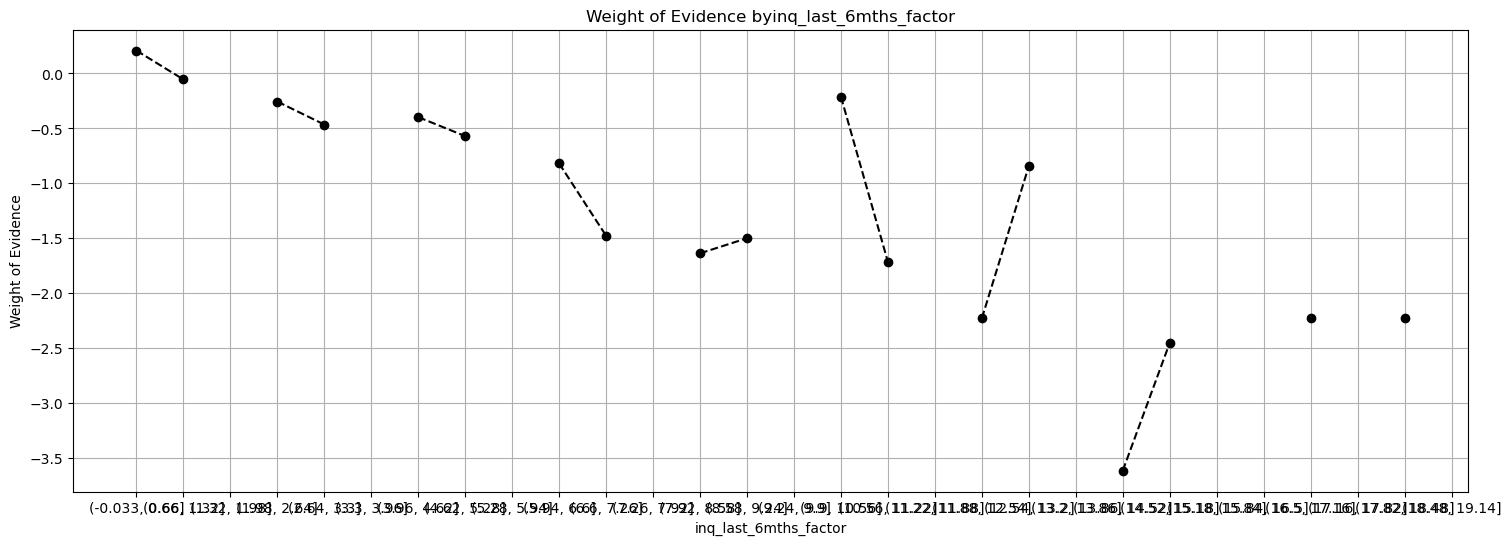

In [65]:
plot_woe(woe_ordered_continuous(X_train, 'inq_last_6mths_factor', y_train))

*Since there is no clear pattern on the WoE by inq_last_6mths and most of the WoE values are below 0, we can decide NOT TO USE inq_last_6mths feature as independent/predictor variable*

#### open_acc

In [66]:
X_train['open_acc_factor'] = pd.cut(X_train['open_acc'], 50)

In [67]:
woe_ordered_continuous(X_train, 'open_acc_factor', y_train)

open_acc_factor  n_obs  prop_good  prop_n_obs   n_good   n_bad  prcnt_good  \
0   (-0.084, 1.68]    139   0.856115    0.000373    119.0    20.0    0.000353   
1     (1.68, 3.36]   5834   0.874529    0.015640   5102.0   732.0    0.015150   
2     (3.36, 5.04]  27169   0.900217    0.072834  24458.0  2711.0    0.072625   
3     (5.04, 6.72]  24621   0.902157    0.066003  22212.0  2409.0    0.065956   
4      (6.72, 8.4]  63748   0.902444    0.170893  57529.0  6219.0    0.170826   
5     (8.4, 10.08]  69187   0.902250    0.185474  62424.0  6763.0    0.185361   
6   (10.08, 11.76]  31372   0.898508    0.084101  28188.0  3184.0    0.083701   
7   (11.76, 13.44]  51591   0.904286    0.138303  46653.0  4938.0    0.138531   
8   (13.44, 15.12]  35998   0.903967    0.096502  32541.0  3457.0    0.096627   
9    (15.12, 16.8]  13540   0.907607    0.036298  12289.0  1251.0    0.036491   
10   (16.8, 18.48]  19318   0.907133    0.051787  17524.0  1794.0    0.052036   
11  (18.48, 20.16]  12060   0.905887    0.032330  10925.0  1135.0    0.032441   
12  (20.16, 21.84]   4242   0.909712    0.011372   3859.0   383.0    0.011459   
13  (21.84, 23.52]   5843   0.910662    0.015664   5321.0   522.0    0.015800   
14   (23.52, 25.2]   3521   0.906845    0.009439   3193.0   328.0    0.009481   
15   (25.2, 26.88]   1064   0.916353    0.002852    975.0    89.0    0.002895   
16  (26.88, 28.56]   1476   0.920732    0.003957   1359.0   117.0    0.004035   
17  (28.56, 30.24]    873   0.901489    0.002340    787.0    86.0    0.002337   
18  (30.24, 31.92]    285   0.919298    0.000764    262.0    23.0    0.000778   
19   (31.92, 33.6]    409   0.911980    0.001096    373.0    36.0    0.001108   
20   (33.6, 35.28]    269   0.929368    0.000721    250.0    19.0    0.000742   
21  (35.28, 36.96]    104   0.884615    0.000279     92.0    12.0    0.000273   
22  (36.96, 38.64]    143   0.902098    0.000383    129.0    14.0    0.000383   
23  (38.64, 40.32]     85   0.941176    0.000228     80.0     5.0    0.000238   
24   (40.32, 42.0]     52   0.903846    0.000139     47.0     5.0    0.000140   
25   (42.0, 43.68]     15   0.800000    0.000040     12.0     3.0    0.000036   
26  (43.68, 45.36]     26   0.923077    0.000070     24.0     2.0    0.000071   
27  (45.36, 47.04]     11   0.909091    0.000029     10.0     1.0    0.000030   
28  (47.04, 48.72]      4   1.000000    0.000011      4.0     0.0    0.000012   
29   (48.72, 50.4]     10   1.000000    0.000027     10.0     0.0    0.000030   
30   (50.4, 52.08]      6   1.000000    0.000016      6.0     0.0    0.000018   
31  (52.08, 53.76]      3   1.000000    0.000008      3.0     0.0    0.000009   
32  (53.76, 55.44]      4   1.000000    0.000011      4.0     0.0    0.000012   
33  (55.44, 57.12]      0        NaN    0.000000      NaN     NaN         NaN   
34   (57.12, 58.8]      1   1.000000    0.000003      1.0     0.0    0.000003   
35   (58.8, 60.48]      0        NaN    0.000000      NaN     NaN         NaN   
36  (60.48, 62.16]      1   1.000000    0.000003      1.0     0.0    0.000003   
37  (62.16, 63.84]      0        NaN    0.000000      NaN     NaN         NaN   
38  (63.84, 65.52]      0        NaN    0.000000      NaN     NaN         NaN   
39   (65.52, 67.2]      0        NaN    0.000000      NaN     NaN         NaN   
40   (67.2, 68.88]      0        NaN    0.000000      NaN     NaN         NaN   
41  (68.88, 70.56]      0        NaN    0.000000      NaN     NaN         NaN   
42  (70.56, 72.24]      0        NaN    0.000000      NaN     NaN         NaN   
43  (72.24, 73.92]      0        NaN    0.000000      NaN     NaN         NaN   
44   (73.92, 75.6]      1   1.000000    0.000003      1.0     0.0    0.000003   
45   (75.6, 77.28]      2   0.500000    0.000005      1.0     1.0    0.000003   
46  (77.28, 78.96]      0        NaN    0.000000      NaN     NaN         NaN   
47  (78.96, 80.64]      0        NaN    0.000000      NaN     NaN         NaN   
48  (80.64, 82.32]      0        N

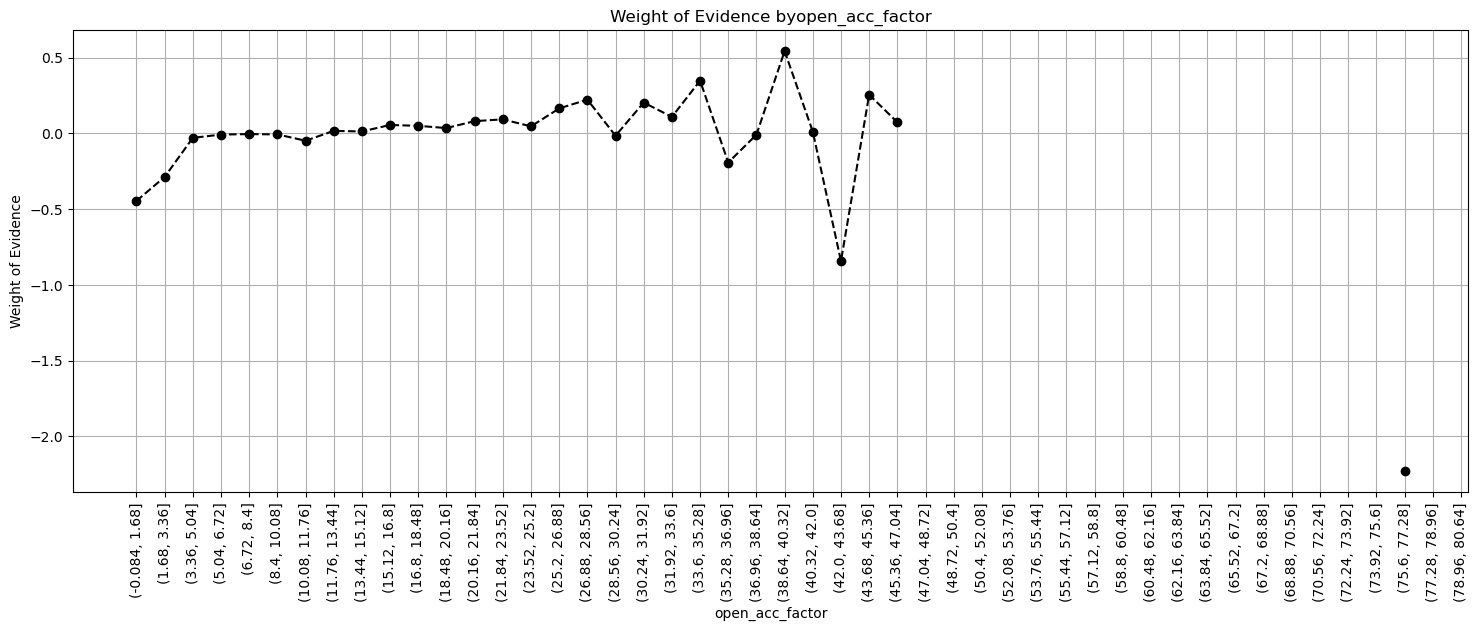

In [68]:
plot_woe(woe_ordered_continuous(X_train, 'open_acc_factor', y_train), 90)

In [69]:
X_train['open_acc:<=12'] = np.where(
    X_train['open_acc'] <= 12, 1, 0
)

X_train['open_acc:12-25'] = np.where(
    ((X_train['open_acc'] >= 12) & (X_train['open_acc'] <= 25)), 1, 0
)

X_train['open_acc:>=25'] = np.where(
    X_train['open_acc'] >= 25, 1, 0
)

In [70]:
X_test['open_acc:<=12'] = np.where(
    X_test['open_acc'] <= 12, 1, 0
)

X_test['open_acc:12-25'] = np.where(
    ((X_test['open_acc'] >= 12) & (X_test['open_acc'] <= 25)), 1, 0
)

X_test['open_acc:>=25'] = np.where(
    X_test['open_acc'] >= 25, 1, 0
)

#### pub_rec

In [71]:
X_train['pub_rec_factor'] = pd.cut(X_train['pub_rec'], 50)

In [72]:
woe_ordered_continuous(X_train, 'pub_rec_factor', y_train)

pub_rec_factor   n_obs  prop_good  prop_n_obs    n_good    n_bad  \
0   (-0.063, 1.26]  366380   0.902437    0.982178  330635.0  35745.0   
1     (1.26, 2.52]    4527   0.915617    0.012136    4145.0    382.0   
2     (2.52, 3.78]    1280   0.938281    0.003431    1201.0     79.0   
3     (3.78, 5.04]     611   0.932897    0.001638     570.0     41.0   
4      (5.04, 6.3]     117   0.931624    0.000314     109.0      8.0   
5      (6.3, 7.56]      48   0.958333    0.000129      46.0      2.0   
6     (7.56, 8.82]      24   1.000000    0.000064      24.0      0.0   
7    (8.82, 10.08]      24   0.916667    0.000064      22.0      2.0   
8   (10.08, 11.34]       3   1.000000    0.000008       3.0      0.0   
9    (11.34, 12.6]       1   1.000000    0.000003       1.0      0.0   
10   (12.6, 13.86]       2   1.000000    0.000005       2.0      0.0   
11  (13.86, 15.12]       1   1.000000    0.000003       1.0      0.0   
12  (15.12, 16.38]       1   1.000000    0.000003       1.0      0.0   
13  (16.38, 17.64]       1   1.000000    0.000003       1.0      0.0   
14   (17.64, 18.9]       2   1.000000    0.000005       2.0      0.0   
15   (18.9, 20.16]       1   1.000000    0.000003       1.0      0.0   
16  (20.16, 21.42]       1   1.000000    0.000003       1.0      0.0   
17  (21.42, 22.68]       0        NaN    0.000000       NaN      NaN   
18  (22.68, 23.94]       0        NaN    0.000000       NaN      NaN   
19   (23.94, 25.2]       0        NaN    0.000000       NaN      NaN   
20   (25.2, 26.46]       0        NaN    0.000000       NaN      NaN   
21  (26.46, 27.72]       0        NaN    0.000000       NaN      NaN   
22  (27.72, 28.98]       0        NaN    0.000000       NaN      NaN   
23  (28.98, 30.24]       0        NaN    0.000000       NaN      NaN   
24   (30.24, 31.5]       0        NaN    0.000000       NaN      NaN   
25   (31.5, 32.76]       0        NaN    0.000000       NaN      NaN   
26  (32.76, 34.02]       1   1.000000    0.000003       1.0      0.0   
27  (34.02, 35.28]       0        NaN    0.000000       NaN      NaN   
28  (35.28, 36.54]       0        NaN    0.000000       NaN      NaN   
29   (36.54, 37.8]       0        NaN    0.000000       NaN      NaN   
30   (37.8, 39.06]       0        NaN    0.000000       NaN      NaN   
31  (39.06, 40.32]       1   1.000000    0.000003       1.0      0.0   
32  (40.32, 41.58]       0        NaN    0.000000       NaN      NaN   
33  (41.58, 42.84]       0        NaN    0.000000       NaN      NaN   
34   (42.84, 44.1]       0        NaN    0.000000       NaN      NaN   
35   (44.1, 45.36]       0        NaN    0.000000       NaN      NaN   
36  (45.36, 46.62]       0        NaN    0.000000       NaN      NaN   
37  (46.62, 47.88]       0        NaN    0.000000       NaN      NaN   
38  (47.88, 49.14]       0        NaN    0.000000       NaN      NaN   
39   (49.14, 50.4]       0        NaN    0.000000       NaN      NaN   
40   (50.4, 51.66]       0        NaN    0.000000       NaN      NaN   
41  (51.66, 52.92]       0        NaN    0.000000       NaN      NaN   
42  (52.92, 54.18]       1   1.000000    0.000003       1.0      0.0   
43  (54.18, 55.44]       0        NaN    0.000000       NaN      NaN   
44   (55.44, 56.7]       0        NaN    0.000000       NaN      NaN   
45   (56.7, 57.96]       0        NaN    0.000000       NaN      NaN   
46  (57.96, 59.22]       0        NaN    0.000000       NaN      NaN   
47  (59.22, 60.48]       0        NaN    0.000000       NaN      NaN   
48  (60.48, 61.74]       0        NaN    0.000000       NaN      NaN   
49   (61.74, 63.0]       1   1.000000    0.000003       1.0      0.0   

    prcnt_good  prcnt_bad       woe   IV  diff_prop_good  diff_woe  
0     0.981786   0.985824 -0.004105  inf             NaN       NaN  
1     0.012308   0.010535  0.155528  inf        0.013180  0.159633  
2     0.003566   0.002179  0.492752  inf        0.022664  0.337225  
3     0.001693   0.001131  0.403355  inf        0.00538

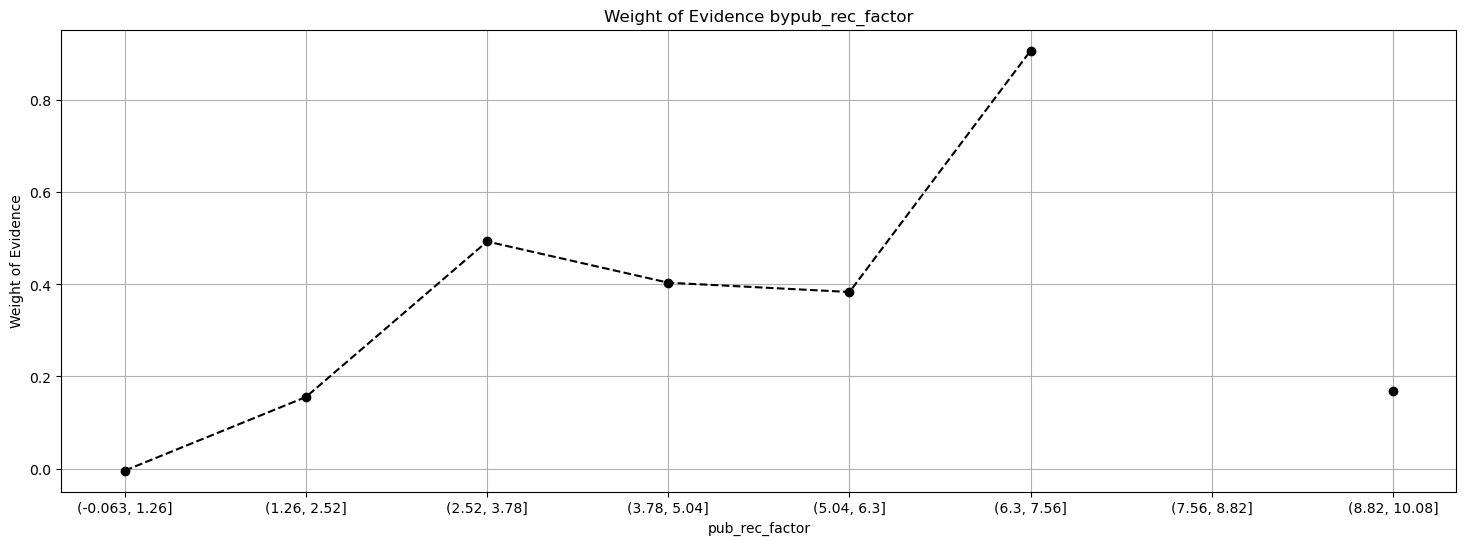

In [73]:
plot_woe(woe_ordered_continuous(X_train, 'pub_rec_factor', y_train))

*Since there is no clear pattern on the WoE by pub_rec and unidentified IV value, we can decide NOT TO USE pub_rec feature as independent/predictor variable*

#### total_acc

In [74]:
X_train['total_acc_factor'] = pd.cut(X_train['total_acc'], 50)

In [75]:
woe_ordered_continuous(X_train, 'total_acc_factor', y_train)

total_acc_factor  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0      (-0.15, 3.0]    459   0.819172    0.001230    376.0    83.0   
1        (3.0, 6.0]   6004   0.871419    0.016095   5232.0   772.0   
2        (6.0, 9.0]  15047   0.884096    0.040337  13303.0  1744.0   
3       (9.0, 12.0]  25169   0.893043    0.067472  22477.0  2692.0   
4      (12.0, 15.0]  33651   0.894386    0.090210  30097.0  3554.0   
5      (15.0, 18.0]  38711   0.900183    0.103775  34847.0  3864.0   
6      (18.0, 21.0]  40599   0.898470    0.108836  36477.0  4122.0   
7      (21.0, 24.0]  40163   0.903717    0.107668  36296.0  3867.0   
8      (24.0, 27.0]  36286   0.907788    0.097274  32940.0  3346.0   
9      (27.0, 30.0]  31775   0.909898    0.085181  28912.0  2863.0   
10     (30.0, 33.0]  25900   0.907683    0.069432  23509.0  2391.0   
11     (33.0, 36.0]  20748   0.910064    0.055620  18882.0  1866.0   
12     (36.0, 39.0]  16055   0.912924    0.043040  14657.0  1398.0   
13     (39.0, 42.0]  12134   0.914620    0.032528  11098.0  1036.0   
14     (42.0, 45.0]   9107   0.908752    0.024414   8276.0   831.0   
15     (45.0, 48.0]   6494   0.906837    0.017409   5889.0   605.0   
16     (48.0, 51.0]   4551   0.914964    0.012200   4164.0   387.0   
17     (51.0, 54.0]   3260   0.922393    0.008739   3007.0   253.0   
18     (54.0, 57.0]   2146   0.916123    0.005753   1966.0   180.0   
19     (57.0, 60.0]   1605   0.906542    0.004303   1455.0   150.0   
20     (60.0, 63.0]   2164   0.911738    0.005801   1973.0   191.0   
21     (63.0, 66.0]    317   0.927445    0.000850    294.0    23.0   
22     (66.0, 69.0]    218   0.944954    0.000584    206.0    12.0   
23     (69.0, 72.0]    120   0.950000    0.000322    114.0     6.0   
24     (72.0, 75.0]    114   0.938596    0.000306    107.0     7.0   
25     (75.0, 78.0]     64   0.906250    0.000172     58.0     6.0   
26     (78.0, 81.0]     52   0.942308    0.000139     49.0     3.0   
27     (81.0, 84.0]     25   0.920000    0.000067     23.0     2.0   
28     (84.0, 87.0]     28   0.964286    0.000075     27.0     1.0   
29     (87.0, 90.0]     22   0.909091    0.000059     20.0     2.0   
30     (90.0, 93.0]     12   0.916667    0.000032     11.0     1.0   
31     (93.0, 96.0]      8   0.875000    0.000021      7.0     1.0   
32     (96.0, 99.0]      4   1.000000    0.000011      4.0     0.0   
33    (99.0, 102.0]      4   1.000000    0.000011      4.0     0.0   
34   (102.0, 105.0]      4   1.000000    0.000011      4.0     0.0   
35   (105.0, 108.0]      1   1.000000    0.000003      1.0     0.0   
36   (108.0, 111.0]      0        NaN    0.000000      NaN     NaN   
37   (111.0, 114.0]      0        NaN    0.000000      NaN     NaN   
38   (114.0, 117.0]      2   1.000000    0.000005      2.0     0.0   
39   (117.0, 120.0]      2   1.000000    0.000005      2.0     0.0   
40   (120.0, 123.0]      1   1.000000    0.000003      1.0     0.0   
41   (123.0, 126.0]      1   1.000000    0.000003      1.0     0.0   
42   (126.0, 129.0]      0        NaN    0.000000      NaN     NaN   
43   (129.0, 132.0]      0        NaN    0.000000      NaN     NaN   
44   (132.0, 135.0]      0        NaN    0.000000      NaN     NaN   
45   (135.0, 138.0]      0        NaN    0.000000      NaN     NaN   
46   (138.0, 141.0]      0        NaN    0.000000      NaN     NaN   
47   (141.0, 144.0]      0        NaN    0.000000      NaN     NaN   
48   (144.0, 147.0]      0        NaN    0.000000      NaN     NaN   
49   (147.0, 150.0]      1   1.000000    0.000003      1.0     0.0   

    prcnt_good  prcnt_bad       woe   IV  diff_prop_good  diff_woe  
0     0.001116   0.002289 -0.717961  inf             NaN       NaN  
1     0.015536   0.021291 -0.315145  inf        0.052247  0.402816  
2     0.039502   0.048098 -0.196901  inf        0.012677  0.118244  
3     0.066743   0.074244 -0.106501  inf        0.008947  0.090400  
4     0.089370   0.098017 -0.092358  inf        0.001343  0.014144  
5     0.103474   0

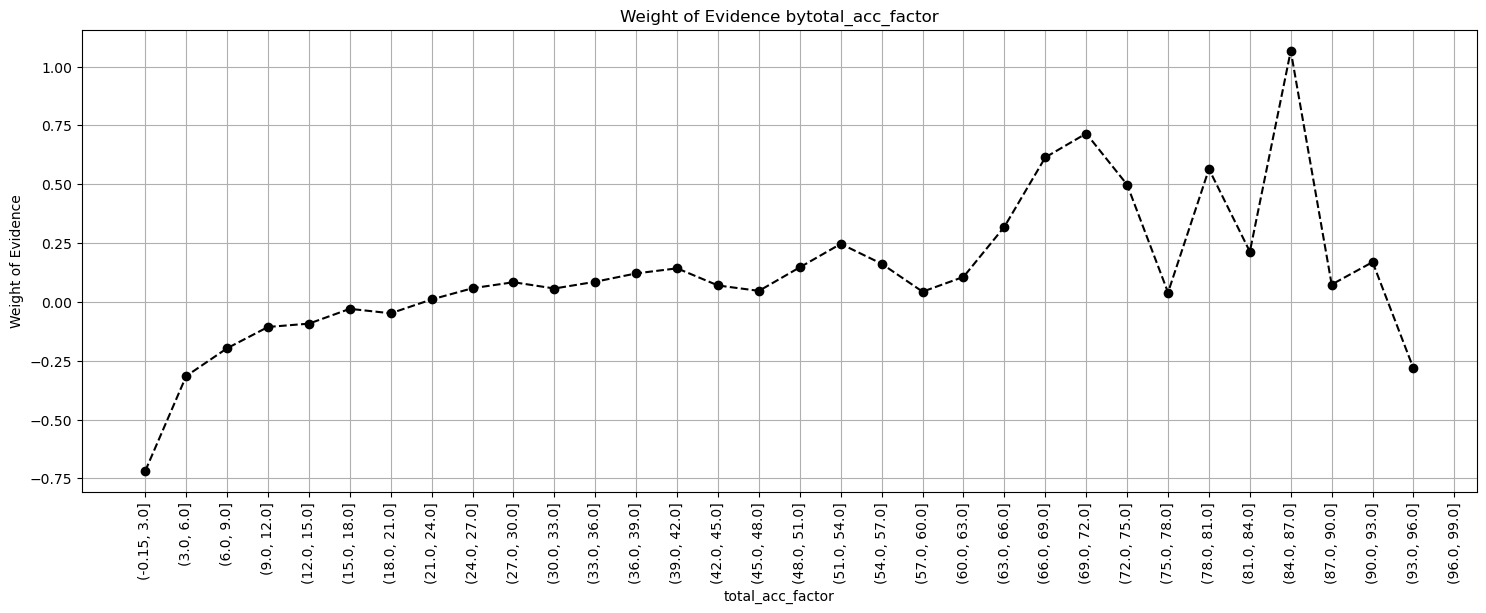

In [76]:
plot_woe(woe_ordered_continuous(X_train, 'total_acc_factor', y_train), 90)

In [77]:
X_train['total_acc:<=13']  = np.where(
    X_train['total_acc'] <= 13 ,1,0
)

X_train['total_acc:13-30']  = np.where(
    ((X_train['total_acc'] >= 13) & (X_train['total_acc'] <= 30)),1,0
)

X_train['total_acc:30-51']  = np.where(
    ((X_train['total_acc'] >= 30) & (X_train['total_acc'] <= 51)),1,0
)

X_train['total_acc:51-66']  = np.where(
    ((X_train['total_acc'] >= 51) & (X_train['total_acc'] <= 66)),1,0
)

X_train['total_acc:>=66']  = np.where(
    X_train['total_acc'] >= 66,1,0
)

In [78]:
X_test['total_acc:<=13']  = np.where(
    X_test['total_acc'] <= 13 ,1,0
)

X_test['total_acc:13-30']  = np.where(
    ((X_test['total_acc'] >= 13) & (X_test['total_acc'] <= 30)),1,0
)

X_test['total_acc:30-51']  = np.where(
    ((X_test['total_acc'] >= 30) & (X_test['total_acc'] <= 51)),1,0
)

X_test['total_acc:51-66']  = np.where(
    ((X_test['total_acc'] >= 51) & (X_test['total_acc'] <= 66)),1,0
)

X_test['total_acc:>=66']  = np.where(
    X_test['total_acc'] >= 66,1,0
)

#### acc_now_delinq

In [79]:
X_train['acc_now_delinq_factor'] = pd.cut(X_train['acc_now_delinq'], 50)

In [80]:
woe_ordered_continuous(X_train, 'acc_now_delinq_factor', y_train)

acc_now_delinq_factor   n_obs  prop_good  prop_n_obs    n_good    n_bad  \
0          (-0.005, 0.1]  371682   0.902761    0.996392  335540.0  36142.0   
1             (0.1, 0.2]       0        NaN    0.000000       NaN      NaN   
2             (0.2, 0.3]       0        NaN    0.000000       NaN      NaN   
3             (0.3, 0.4]       0        NaN    0.000000       NaN      NaN   
4             (0.4, 0.5]       0        NaN    0.000000       NaN      NaN   
5             (0.5, 0.6]       0        NaN    0.000000       NaN      NaN   
6             (0.6, 0.7]       0        NaN    0.000000       NaN      NaN   
7             (0.7, 0.8]       0        NaN    0.000000       NaN      NaN   
8             (0.8, 0.9]       0        NaN    0.000000       NaN      NaN   
9             (0.9, 1.0]    1263   0.912114    0.003386    1152.0    111.0   
10            (1.0, 1.1]       0        NaN    0.000000       NaN      NaN   
11            (1.1, 1.2]       0        NaN    0.000000       NaN      NaN   
12            (1.2, 1.3]       0        NaN    0.000000       NaN      NaN   
13            (1.3, 1.4]       0        NaN    0.000000       NaN      NaN   
14            (1.4, 1.5]       0        NaN    0.000000       NaN      NaN   
15            (1.5, 1.6]       0        NaN    0.000000       NaN      NaN   
16            (1.6, 1.7]       0        NaN    0.000000       NaN      NaN   
17            (1.7, 1.8]       0        NaN    0.000000       NaN      NaN   
18            (1.8, 1.9]       0        NaN    0.000000       NaN      NaN   
19            (1.9, 2.0]      70   0.942857    0.000188      66.0      4.0   
20            (2.0, 2.1]       0        NaN    0.000000       NaN      NaN   
21            (2.1, 2.2]       0        NaN    0.000000       NaN      NaN   
22            (2.2, 2.3]       0        NaN    0.000000       NaN      NaN   
23            (2.3, 2.4]       0        NaN    0.000000       NaN      NaN   
24            (2.4, 2.5]       0        NaN    0.000000       NaN      NaN   
25            (2.5, 2.6]       0        NaN    0.000000       NaN      NaN   
26            (2.6, 2.7]       0        NaN    0.000000       NaN      NaN   
27            (2.7, 2.8]       0        NaN    0.000000       NaN      NaN   
28            (2.8, 2.9]       0        NaN    0.000000       NaN      NaN   
29            (2.9, 3.0]       7   0.857143    0.000019       6.0      1.0   
30            (3.0, 3.1]       0        NaN    0.000000       NaN      NaN   
31            (3.1, 3.2]       0        NaN    0.000000       NaN      NaN   
32            (3.2, 3.3]       0        NaN    0.000000       NaN      NaN   
33            (3.3, 3.4]       0        NaN    0.000000       NaN      NaN   
34            (3.4, 3.5]       0        NaN    0.000000       NaN      NaN   
35            (3.5, 3.6]       0        NaN    0.000000       NaN      NaN   
36            (3.6, 3.7]       0        NaN    0.000000       NaN      NaN   
37            (3.7, 3.8]       0        NaN    0.000000       NaN      NaN   
38            (3.8, 3.9]       0        NaN    0.000000       NaN      NaN   
39            (3.9, 4.0]       4   1.000000    0.000011       4.0      0.0   
40            (4.0, 4.1]       0        NaN    0.000000       NaN      NaN   
41            (4.1, 4.2]       0        NaN    0.000000       NaN      NaN   
42            (4.2, 4.3]       0        NaN    0.000000       NaN      NaN   
43            (4.3, 4.4]       0        NaN    0.000000       NaN      NaN   
44            (4.4, 4.5]       0        NaN    0.000000       NaN      NaN   
45            (4.5, 4.6]       0        NaN    0.000000       NaN      NaN   
46            (4.6, 4.7]       0        NaN    0.000000       NaN      NaN   
47            (4.7, 4.8]       0        NaN    0.000000       NaN      NaN   
48            (4.8, 4.9]       0        NaN    0.000000       NaN      NaN   
49            (4.9, 5.0]       2   0.500000    0.000005       1.0      1.0   

    prcnt_good  prcnt_ba

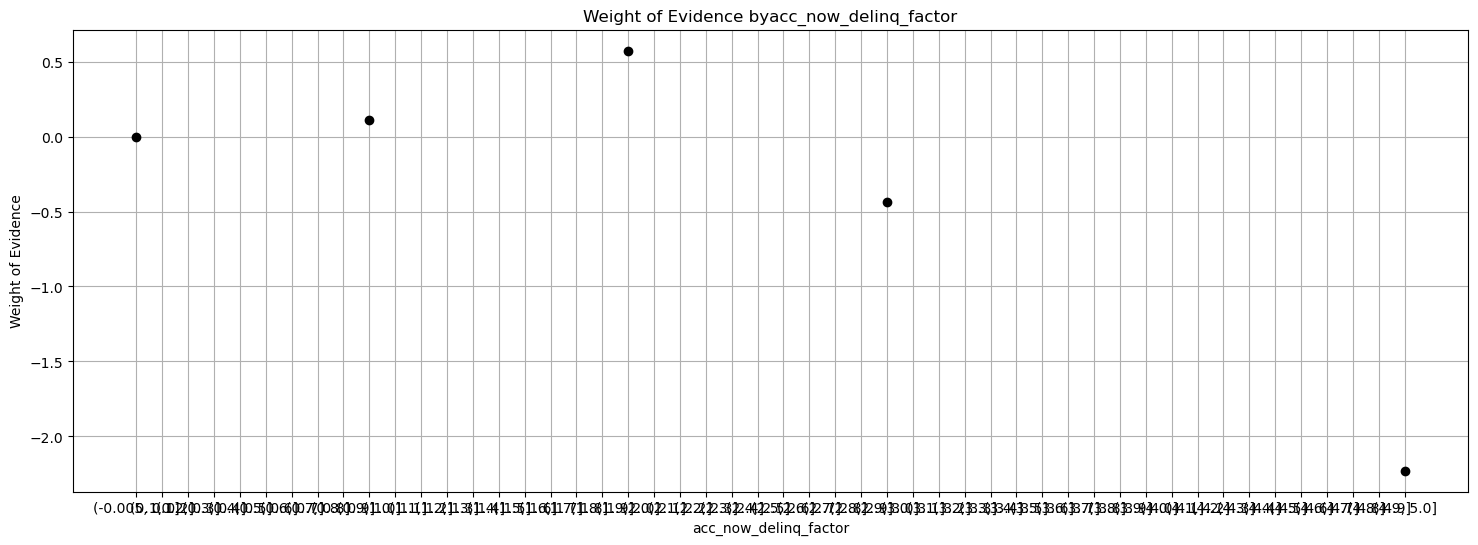

In [81]:
plot_woe(woe_ordered_continuous(X_train, 'acc_now_delinq_factor', y_train))

*Since there is no clear pattern on the WoE by acc_now_delinq and unidentified IV value, we can decide NOT TO USE acc_now_delinq feature as independent/predictor variable*

#### annual_inc

In [82]:
X_train['annual_inc_factor'] = pd.cut(X_train['annual_inc'], 50)

In [83]:
woe_ordered_continuous(X_train, 'annual_inc_factor', y_train)

annual_inc_factor   n_obs  prop_good  prop_n_obs    n_good  \
0     (-5243.882, 144693.64]  351904   0.900839    0.943372  317009.0   
1     (144693.64, 287491.28]   19004   0.934698    0.050945   17763.0   
2     (287491.28, 430288.92]    1525   0.943607    0.004088    1439.0   
3     (430288.92, 573086.56]     332   0.942771    0.000890     313.0   
4      (573086.56, 715884.2]     112   0.901786    0.000300     101.0   
5      (715884.2, 858681.84]      65   0.907692    0.000174      59.0   
6    (858681.84, 1001479.48]      39   0.974359    0.000105      38.0   
7   (1001479.48, 1144277.12]      10   1.000000    0.000027      10.0   
8   (1144277.12, 1287074.76]      12   1.000000    0.000032      12.0   
9    (1287074.76, 1429872.4]       6   1.000000    0.000016       6.0   
10   (1429872.4, 1572670.04]       3   1.000000    0.000008       3.0   
11  (1572670.04, 1715467.68]       1   1.000000    0.000003       1.0   
12  (1715467.68, 1858265.32]       1   1.000000    0.000003       1.0   
13  (1858265.32, 2001062.96]       6   1.000000    0.000016       6.0   
14   (2001062.96, 2143860.6]       1   1.000000    0.000003       1.0   
15   (2143860.6, 2286658.24]       0        NaN    0.000000       NaN   
16  (2286658.24, 2429455.88]       0        NaN    0.000000       NaN   
17  (2429455.88, 2572253.52]       0        NaN    0.000000       NaN   
18  (2572253.52, 2715051.16]       0        NaN    0.000000       NaN   
19   (2715051.16, 2857848.8]       0        NaN    0.000000       NaN   
20   (2857848.8, 3000646.44]       0        NaN    0.000000       NaN   
21  (3000646.44, 3143444.08]       0        NaN    0.000000       NaN   
22  (3143444.08, 3286241.72]       0        NaN    0.000000       NaN   
23  (3286241.72, 3429039.36]       0        NaN    0.000000       NaN   
24   (3429039.36, 3571837.0]       0        NaN    0.000000       NaN   
25   (3571837.0, 3714634.64]       0        NaN    0.000000       NaN   
26  (3714634.64, 3857432.28]       0        NaN    0.000000       NaN   
27  (3857432.28, 4000229.92]       1   1.000000    0.000003       1.0   
28  (4000229.92, 4143027.56]       0        NaN    0.000000       NaN   
29   (4143027.56, 4285825.2]       0        NaN    0.000000       NaN   
30   (4285825.2, 4428622.84]       0        NaN    0.000000       NaN   
31  (4428622.84, 4571420.48]       1   1.000000    0.000003       1.0   
32  (4571420.48, 4714218.12]       0        NaN    0.000000       NaN   
33  (4714218.12, 4857015.76]       0        NaN    0.000000       NaN   
34   (4857015.76, 4999813.4]       1   1.000000    0.000003       1.0   
35   (4999813.4, 5142611.04]       1   1.000000    0.000003       1.0   
36  (5142611.04, 5285408.68]       0        NaN    0.000000       NaN   
37  (5285408.68, 5428206.32]       0        NaN    0.000000       NaN   
38  (5428206.32, 5571003.96]       0        NaN    0.000000       NaN   
39   (5571003.96, 5713801.6]       0        NaN    0.000000       NaN   
40   (5713801.6, 5856599.24]       0        NaN    0.000000       NaN   
41  (5856599.24, 5999396.88]       0        NaN    0.000000       NaN   
42  (5999396.88, 6142194.52]       2   1.000000    0.000005       2.0   
43  (6142194.52, 6284992.16]       0        NaN    0.000000       NaN   
44   (6284992.16, 6427789.8]       0        NaN    0.000000       NaN   
45   (6427789.8, 6570587.44]       0        NaN    0.000000       NaN   
46  (6570587.44, 6713385.08]       0        NaN    0.000000       NaN   
47  (6713385.08, 6856182.72]       0        NaN    0.000000       NaN   
48  (6856182.72, 6998980.36]       0        NaN    0.000000       NaN   
49   (6998980.36, 7141778.0]       1   1.000000    0.000003       1.0   

      n_bad  prcnt_good  prcnt_bad       woe   IV  diff_prop_good  diff_woe  
0   34895.0    0.941325   0.962382 -0.022123  inf             NaN       NaN  
1    1241.0    0.052745   0.034226  0.432491  inf        0.033859  0.454614  
2      86.0    0.004273   0.002372  0.588647  inf    

In [84]:
#Since the annual_inc at the first row already 94% of our data itself, we can try cut the proportion into 100 instead of 50
X_train['annual_inc_factor'] = pd.cut(X_train['annual_inc'], 100)
woe_ordered_continuous(X_train, 'annual_inc_factor', y_train)

annual_inc_factor   n_obs  prop_good  prop_n_obs    n_good  \
0      (-5243.882, 73294.82]  231445   0.889114    0.620449  205781.0   
1      (73294.82, 144693.64]  120459   0.923368    0.322922  111228.0   
2     (144693.64, 216092.46]   15885   0.934655    0.042584   14847.0   
3     (216092.46, 287491.28]    3119   0.934915    0.008361    2916.0   
4      (287491.28, 358890.1]    1117   0.940913    0.002994    1051.0   
..                       ...     ...        ...         ...       ...   
95   (6784783.9, 6856182.72]       0        NaN    0.000000       NaN   
96  (6856182.72, 6927581.54]       0        NaN    0.000000       NaN   
97  (6927581.54, 6998980.36]       0        NaN    0.000000       NaN   
98  (6998980.36, 7070379.18]       0        NaN    0.000000       NaN   
99   (7070379.18, 7141778.0]       1   1.000000    0.000003       1.0   

      n_bad  prcnt_good  prcnt_bad       woe   IV  diff_prop_good  diff_woe  
0   25664.0    0.611045   0.707797 -0.146986  inf             NaN       NaN  
1    9231.0    0.330280   0.254585  0.260305  inf        0.034254  0.407291  
2    1038.0    0.044087   0.028627  0.431792  inf        0.011287  0.171487  
3     203.0    0.008659   0.005599  0.436053  inf        0.000260  0.004260  
4      66.0    0.003121   0.001820  0.539133  inf        0.005998  0.103081  
..      ...         ...        ...       ...  ...             ...       ...  
95      NaN         NaN        NaN       NaN  inf             NaN       NaN  
96      NaN         NaN        NaN       NaN  inf             NaN       NaN  
97      NaN         NaN        NaN       NaN  inf             NaN       NaN  
98      NaN         NaN        NaN       NaN  inf             NaN       NaN  
99      0.0    0.000003   0.000000       inf  inf             NaN       NaN  

[100 rows x 12 columns]

In [85]:
#Since the proportion of record on the first row still high, let's try to split up the income into 2 big categories
#income > 144.000 and income <=144.000

temp = X_train.loc[X_train.annual_inc <= 144000, :]
X_train['annual_inc_factor'] = pd.cut(temp['annual_inc'], 50)
woe_ordered_continuous(X_train, 'annual_inc_factor', y_train[temp.index])

annual_inc_factor  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0      (1753.896, 4738.08]     15   0.800000    0.000043     12.0     3.0   
1       (4738.08, 7580.16]     45   0.777778    0.000128     35.0    10.0   
2      (7580.16, 10422.24]    307   0.882736    0.000872    271.0    36.0   
3     (10422.24, 13264.32]    681   0.841410    0.001935    573.0   108.0   
4      (13264.32, 16106.4]   1323   0.848073    0.003760   1122.0   201.0   
5      (16106.4, 18948.48]   1421   0.857143    0.004038   1218.0   203.0   
6     (18948.48, 21790.56]   3065   0.864600    0.008710   2650.0   415.0   
7     (21790.56, 24632.64]   4060   0.866010    0.011538   3516.0   544.0   
8     (24632.64, 27474.72]   6597   0.863878    0.018748   5699.0   898.0   
9      (27474.72, 30316.8]  10651   0.876068    0.030269   9331.0  1320.0   
10     (30316.8, 33158.88]   8004   0.874313    0.022747   6998.0  1006.0   
11    (33158.88, 36000.96]  13957   0.873110    0.039665  12186.0  1771.0   
12    (36000.96, 38843.04]   8016   0.884107    0.022781   7087.0   929.0   
13    (38843.04, 41685.12]  16579   0.878702    0.047116  14568.0  2011.0   
14     (41685.12, 44527.2]  12677   0.881281    0.036027  11172.0  1505.0   
15     (44527.2, 47369.28]  16697   0.890220    0.047451  14864.0  1833.0   
16    (47369.28, 50211.36]  22325   0.888869    0.063446  19844.0  2481.0   
17    (50211.36, 53053.44]  12066   0.901542    0.034290  10878.0  1188.0   
18    (53053.44, 55895.52]  14222   0.898327    0.040418  12776.0  1446.0   
19     (55895.52, 58737.6]  10403   0.901567    0.029564   9379.0  1024.0   
20     (58737.6, 61579.68]  18860   0.891039    0.053598  16805.0  2055.0   
21    (61579.68, 64421.76]   9157   0.909796    0.026023   8331.0   826.0   
22    (64421.76, 67263.84]  15791   0.899373    0.044877  14202.0  1589.0   
23    (67263.84, 70105.92]  15979   0.907316    0.045411  14498.0  1481.0   
24     (70105.92, 72948.0]   7012   0.908443    0.019927   6370.0   642.0   
25     (72948.0, 75790.08]  13423   0.910899    0.038147  12227.0  1196.0   
26    (75790.08, 78632.16]   6181   0.916518    0.017566   5665.0   516.0   
27    (78632.16, 81474.24]  12183   0.914553    0.034623  11142.0  1041.0   
28    (81474.24, 84316.32]   6148   0.923390    0.017472   5677.0   471.0   
29     (84316.32, 87158.4]   9892   0.918116    0.028112   9082.0   810.0   
30     (87158.4, 90000.48]  10591   0.918799    0.030099   9731.0   860.0   
31    (90000.48, 92842.56]   3402   0.925926    0.009668   3150.0   252.0   
32    (92842.56, 95684.64]   6630   0.922926    0.018842   6119.0   511.0   
33    (95684.64, 98526.72]   4700   0.920000    0.013357   4324.0   376.0   
34    (98526.72, 101368.8]   8807   0.925514    0.025029   8151.0   656.0   
35   (101368.8, 104210.88]   3245   0.931895    0.009222   3024.0   221.0   
36  (104210.88, 107052.96]   4222   0.933681    0.011999   3942.0   280.0   
37  (107052.96, 109895.04]   1809   0.935876    0.005141   1693.0   116.0   
38  (109895.04, 112737.12]   5773   0.926208    0.016406   5347.0   426.0   
39   (112737.12, 115579.2]   3201   0.946579    0.009097   3030.0   171.0   
40   (115579.2, 118421.28]   1584   0.932449    0.004502   1477.0   107.0   
41  (118421.28, 121263.36]   5953   0.925080    0.016918   5507.0   446.0   
42  (121263.36, 124105.44]   1150   0.937391    0.003268   1078.0    72.0   
43  (124105.44, 126947.52]   3273   0.932478    0.009302   3052.0   221.0   
44   (126947.52, 129789.6]    945   0.928042    0.002686    877.0    68.0   
45   (129789.6, 132631.68]   3190   0.934796    0.009066   2982.0   208.0   
46  (132631.68, 135473.76]   1863   0.952228    0.005294   1774.0    89.0   
47  (135473.76, 138315.84]    749   0.947931    0.002129    710.0    39.0   
48  (138315.84, 141157.92]   2385   0.929979    0.006778   2218.0   167.0   
49   (141157.92, 144000.0]    667   0.929535    0.001896    620.0    47.0   

    prcnt_good  prcnt_bad       woe        IV  diff_prop_good  diff_woe  
0     0

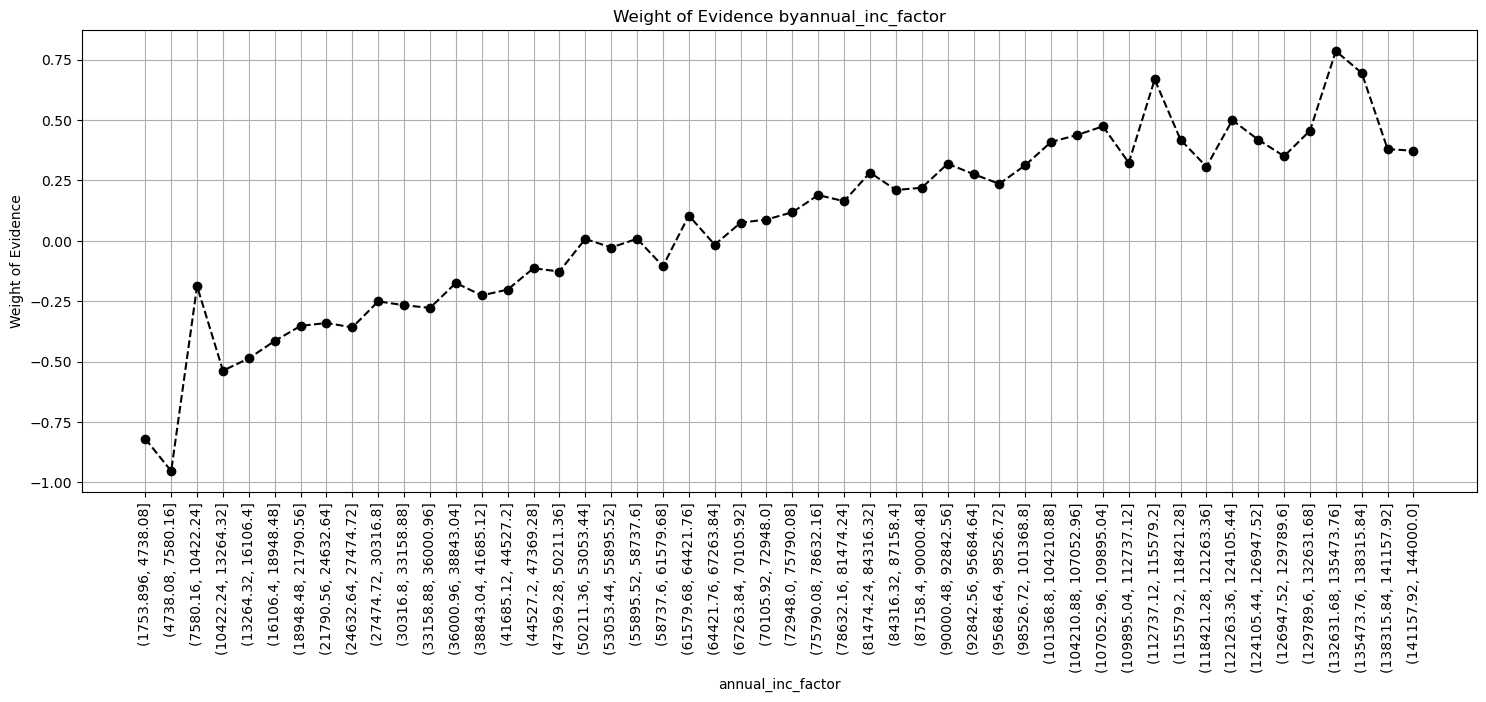

In [86]:
plot_woe(woe_ordered_continuous(X_train, 'annual_inc_factor', y_train[temp.index]), 90)

In [87]:
X_train['annual_inc:<20k'] = np.where(X_train['annual_inc'] < 20000, 1, 0)
X_train['annual_inc:20k-30k'] = np.where(
    ((X_train['annual_inc']>=20000) & (X_train['annual_inc']<=30000)), 1, 0
)

X_train['annual_inc:30k-40k'] = np.where(
     ((X_train['annual_inc']>=30000) & (X_train['annual_inc']<=40000)), 1, 0
)

X_train['annual_inc:40k-50k'] = np.where(
     ((X_train['annual_inc']>=40000) & (X_train['annual_inc']<=50000)), 1, 0
)

X_train['annual_inc:50k-60k'] = np.where(
    ((X_train['annual_inc']>=50000) & (X_train['annual_inc']<=60000)), 1, 0
)

X_train['annual_inc:60k-70k'] = np.where(
     ((X_train['annual_inc']>=60000) & (X_train['annual_inc']<=70000)), 1, 0
)

X_train['annual_inc:70k-80k'] = np.where(
    ((X_train['annual_inc']>=70000) & (X_train['annual_inc']<=80000)), 1, 0
)

X_train['annual_inc:80k-90k'] = np.where(
     ((X_train['annual_inc']>=80000) & (X_train['annual_inc']<=90000)), 1, 0
)

X_train['annual_inc:90k-100k'] = np.where(
     ((X_train['annual_inc']>=90000) & (X_train['annual_inc']<=100000)), 1, 0
)

X_train['annual_inc:100k-120k'] = np.where(
     ((X_train['annual_inc']>=100000) & (X_train['annual_inc']<=120000)), 1, 0
)

X_train['annual_inc:120k-140k'] = np.where(
     ((X_train['annual_inc']>=120000) & (X_train['annual_inc']<=140000)), 1, 0
)

X_train['annual_inc:>140k'] = np.where(X_train['annual_inc'] >= 140000, 1, 0)

In [88]:
X_test['annual_inc:<20k'] = np.where(X_test['annual_inc'] < 20000, 1, 0)
X_test['annual_inc:20k-30k'] = np.where(
    ((X_test['annual_inc']>=20000) & (X_test['annual_inc']<=30000)), 1, 0
)

X_test['annual_inc:30k-40k'] = np.where(
     ((X_test['annual_inc']>=30000) & (X_test['annual_inc']<=40000)), 1, 0
)

X_test['annual_inc:40k-50k'] = np.where(
     ((X_test['annual_inc']>=40000) & (X_test['annual_inc']<=50000)), 1, 0
)

X_test['annual_inc:50k-60k'] = np.where(
    ((X_test['annual_inc']>=50000) & (X_test['annual_inc']<=60000)), 1, 0
)

X_test['annual_inc:60k-70k'] = np.where(
     ((X_test['annual_inc']>=60000) & (X_test['annual_inc']<=70000)), 1, 0
)

X_test['annual_inc:70k-80k'] = np.where(
    ((X_test['annual_inc']>=70000) & (X_test['annual_inc']<=80000)), 1, 0
)

X_test['annual_inc:80k-90k'] = np.where(
     ((X_test['annual_inc']>=80000) & (X_test['annual_inc']<=90000)), 1, 0
)

X_test['annual_inc:90k-100k'] = np.where(
     ((X_test['annual_inc']>=90000) & (X_test['annual_inc']<=100000)), 1, 0
)

X_test['annual_inc:100k-120k'] = np.where(
     ((X_test['annual_inc']>=100000) & (X_test['annual_inc']<=120000)), 1, 0
)

X_test['annual_inc:120k-140k'] = np.where(
     ((X_test['annual_inc']>=120000) & (X_test['annual_inc']<=140000)), 1, 0
)

X_test['annual_inc:>140k'] = np.where(X_test['annual_inc'] >= 140000, 1, 0)

#### mths_since_delinq

In [89]:
X_train['mths_since_last_delinq_factor'] = pd.cut(X_train['mths_since_last_delinq'], 50)
woe_ordered_continuous(X_train, 'mths_since_last_delinq_factor', y_train)

mths_since_last_delinq_factor   n_obs  prop_good  prop_n_obs    n_good  \
0                 (-0.188, 3.76]  205462   0.899709    0.550795  184856.0   
1                   (3.76, 7.52]   11167   0.902928    0.029936   10083.0   
2                  (7.52, 11.28]   13306   0.908237    0.035670   12085.0   
3                 (11.28, 15.04]   13216   0.903223    0.035429   11937.0   
4                  (15.04, 18.8]    9337   0.907786    0.025030    8476.0   
5                  (18.8, 22.56]   11641   0.906623    0.031207   10554.0   
6                 (22.56, 26.32]   10887   0.908698    0.029185    9893.0   
7                 (26.32, 30.08]   10560   0.907197    0.028309    9580.0   
8                 (30.08, 33.84]    7576   0.914203    0.020309    6926.0   
9                  (33.84, 37.6]    9795   0.910873    0.026258    8922.0   
10                 (37.6, 41.36]    9352   0.903764    0.025071    8452.0   
11                (41.36, 45.12]    9202   0.908172    0.024668    8357.0   
12                (45.12, 48.88]    6538   0.911135    0.017527    5957.0   
13                (48.88, 52.64]    6486   0.903793    0.017387    5862.0   
14                 (52.64, 56.4]    6045   0.906865    0.016205    5482.0   
15                 (56.4, 60.16]    5867   0.912903    0.015728    5356.0   
16                (60.16, 63.92]    4040   0.898020    0.010830    3628.0   
17                (63.92, 67.68]    5314   0.904968    0.014246    4809.0   
18                (67.68, 71.44]    5141   0.904104    0.013782    4648.0   
19                 (71.44, 75.2]    4950   0.899798    0.013270    4454.0   
20                 (75.2, 78.96]    3312   0.908213    0.008879    3008.0   
21                (78.96, 82.72]    3577   0.901034    0.009589    3223.0   
22                (82.72, 86.48]      94   0.829787    0.000252      78.0   
23                (86.48, 90.24]      38   0.894737    0.000102      34.0   
24                 (90.24, 94.0]      32   0.937500    0.000086      30.0   
25                 (94.0, 97.76]      20   0.750000    0.000054      15.0   
26               (97.76, 101.52]      13   0.923077    0.000035      12.0   
27              (101.52, 105.28]      11   0.909091    0.000029      10.0   
28              (105.28, 109.04]       8   0.750000    0.000021       6.0   
29               (109.04, 112.8]       2   0.500000    0.000005       1.0   
30               (112.8, 116.56]       7   0.857143    0.000019       6.0   
31              (116.56, 120.32]       2   1.000000    0.000005       2.0   
32              (120.32, 124.08]       1   1.000000    0.000003       1.0   
33              (124.08, 127.84]       2   1.000000    0.000005       2.0   
34               (127.84, 131.6]       5   1.000000    0.000013       5.0   
35               (131.6, 135.36]       7   0.857143    0.000019       6.0   
36              (135.36, 139.12]       2   1.000000    0.000005       2.0   
37              (139.12, 142.88]       3   1.000000    0.000008       3.0   
38              (142.88, 146.64]       1   1.000000    0.000003       1.0   
39               (146.64, 150.4]       3   0.666667    0.000008       2.0   
40               (150.4, 154.16]       2   0.500000    0.000005       1.0   
41              (154.16, 157.92]       1   1.000000    0.000003       1.0   
42              (157.92, 161.68]       1   1.000000    0.000003       1.0   
43              (161.68, 165.44]       0        NaN    0.000000       NaN   
44               (165.44, 169.2]       0        NaN    0.000000       NaN   
45               (169.2, 172.96]       0        NaN    0.000000       NaN   
46              (172.96, 176.72]       0        NaN    0.000000       NaN   
47              (176.72, 180.48]       1   1.000000    0.000003       1.0   
48              (180.48, 184.24]       0        NaN    0.000000       NaN   
49               (184.24, 188.0]       1   1.000000    0.000003       1.0   

      n_bad  prcnt_good  prcnt_bad       woe   IV  diff_prop_good  diff_woe

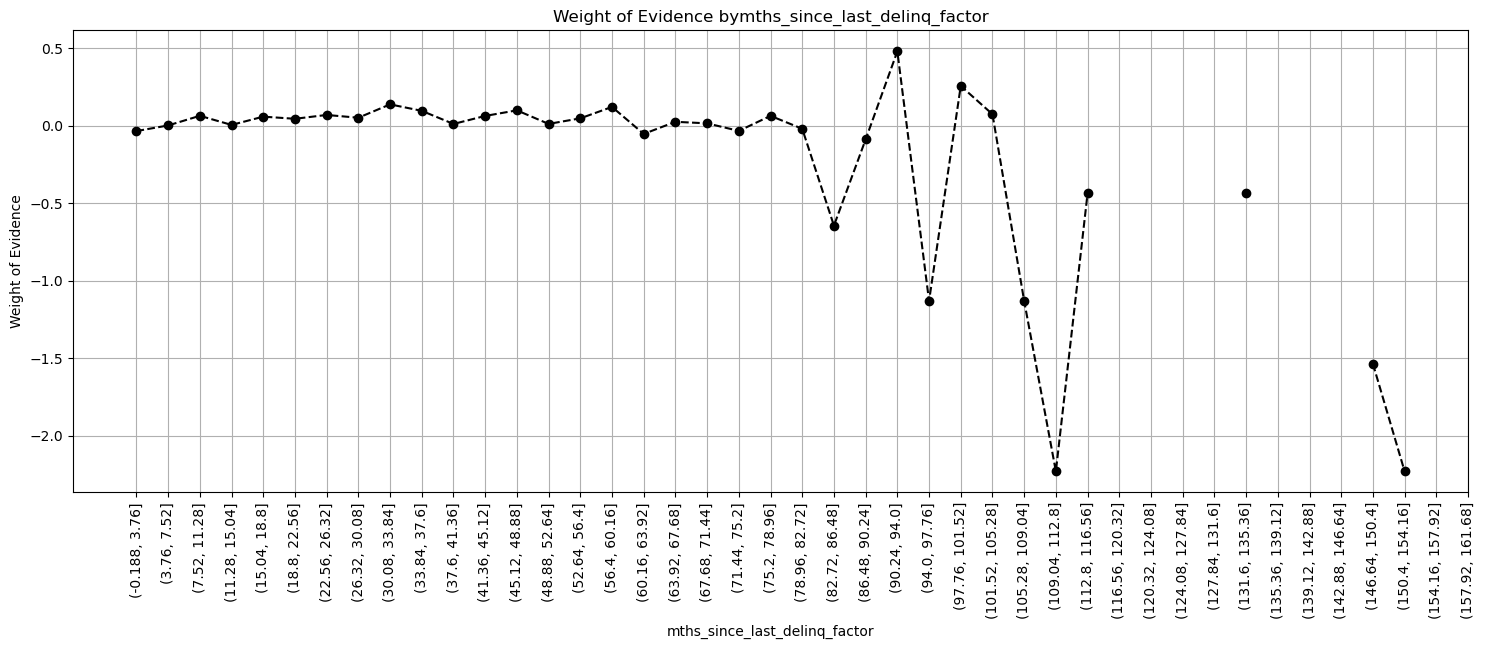

In [90]:
plot_woe(woe_ordered_continuous(X_train, 'mths_since_last_delinq_factor', y_train), 90)

In [91]:
X_train['mths_since_last_delinq:<=33'] = np.where(
    X_train['mths_since_last_delinq'] <= 33 ,1,0
)

X_train['mths_since_last_delinq:33-60'] = np.where(
    ((X_train['mths_since_last_delinq'] >= 33) & (X_train['mths_since_last_delinq'] <= 60)),1,0
)

X_train['mths_since_last_delinq:>60'] = np.where(
     X_train['mths_since_last_delinq'] >= 60 ,1,0
)

In [92]:
X_test['mths_since_last_delinq:<=33'] = np.where(
    X_test['mths_since_last_delinq'] <= 33 ,1,0
)

X_test['mths_since_last_delinq:33-60'] = np.where(
    ((X_test['mths_since_last_delinq'] >= 33) & (X_test['mths_since_last_delinq'] <= 60)),1,0
)

X_test['mths_since_last_delinq:>60'] = np.where(
     X_test['mths_since_last_delinq'] >= 60 ,1,0
)

#### dti

In [93]:
X_train['dti_factor'] = pd.cut(X_train['dti'],50)
woe_ordered_continuous(X_train, 'dti_factor', y_train)

dti_factor  n_obs  prop_good  prop_n_obs   n_good   n_bad  \
0       (-0.04, 0.8]   1553   0.902125    0.004163   1401.0   152.0   
1         (0.8, 1.6]   1965   0.901781    0.005268   1772.0   193.0   
2       (1.6, 2.399]   2509   0.915106    0.006726   2296.0   213.0   
3     (2.399, 3.199]   3234   0.917440    0.008670   2967.0   267.0   
4     (3.199, 3.999]   4124   0.917071    0.011055   3782.0   342.0   
5     (3.999, 4.799]   5037   0.923367    0.013503   4651.0   386.0   
6     (4.799, 5.599]   5989   0.917348    0.016055   5494.0   495.0   
7     (5.599, 6.398]   6781   0.924790    0.018178   6271.0   510.0   
8     (6.398, 7.198]   7665   0.920287    0.020548   7054.0   611.0   
9     (7.198, 7.998]   8747   0.923059    0.023449   8074.0   673.0   
10    (7.998, 8.798]   9572   0.921855    0.025660   8824.0   748.0   
11    (8.798, 9.598]  10320   0.917151    0.027665   9465.0   855.0   
12   (9.598, 10.397]  11092   0.917869    0.029735  10181.0   911.0   
13  (10.397, 11.197]  11940   0.911474    0.032008  10883.0  1057.0   
14  (11.197, 11.997]  12471   0.917649    0.033432  11444.0  1027.0   
15  (11.997, 12.797]  13246   0.912200    0.035509  12083.0  1163.0   
16  (12.797, 13.597]  13436   0.912995    0.036019  12267.0  1169.0   
17  (13.597, 14.396]  13709   0.910351    0.036751  12480.0  1229.0   
18  (14.396, 15.196]  14045   0.912282    0.037651  12813.0  1232.0   
19  (15.196, 15.996]  13870   0.908435    0.037182  12600.0  1270.0   
20  (15.996, 16.796]  13735   0.903458    0.036820  12409.0  1326.0   
21  (16.796, 17.596]  13710   0.900802    0.036753  12350.0  1360.0   
22  (17.596, 18.395]  13606   0.897839    0.036474  12216.0  1390.0   
23  (18.395, 19.195]  13209   0.899235    0.035410  11878.0  1331.0   
24  (19.195, 19.995]  13183   0.896078    0.035341  11813.0  1370.0   
25  (19.995, 20.795]  12435   0.895456    0.033335  11135.0  1300.0   
26  (20.795, 21.595]  11902   0.891111    0.031906  10606.0  1296.0   
27  (21.595, 22.394]  11303   0.889056    0.030301  10049.0  1254.0   
28  (22.394, 23.194]  11013   0.888314    0.029523   9783.0  1230.0   
29  (23.194, 23.994]  10229   0.889823    0.027422   9102.0  1127.0   
30  (23.994, 24.794]   9922   0.884600    0.026599   8777.0  1145.0   
31  (24.794, 25.594]   8566   0.890614    0.022963   7629.0   937.0   
32  (25.594, 26.393]   7777   0.891603    0.020848   6934.0   843.0   
33  (26.393, 27.193]   7251   0.886361    0.019438   6427.0   824.0   
34  (27.193, 27.993]   6627   0.881394    0.017765   5841.0   786.0   
35  (27.993, 28.793]   6361   0.886024    0.017052   5636.0   725.0   
36  (28.793, 29.593]   5785   0.881590    0.015508   5100.0   685.0   
37  (29.593, 30.392]   4705   0.882040    0.012613   4150.0   555.0   
38  (30.392, 31.192]   3852   0.880322    0.010326   3391.0   461.0   
39  (31.192, 31.992]   3510   0.890028    0.009409   3124.0   386.0   
40  (31.992, 32.792]   3041   0.882276    0.008152   2683.0   358.0   
41  (32.792, 33.592]   2811   0.884739    0.007536   2487.0   324.0   
42  (33.592, 34.391]   2592   0.883488    0.006949   2290.0   302.0   
43  (34.391, 35.191]   1842   0.880022    0.004938   1621.0   221.0   
44  (35.191, 35.991]    530   0.932075    0.001421    494.0    36.0   
45  (35.991, 36.791]    539   0.918367    0.001445    495.0    44.0   
46  (36.791, 37.591]    491   0.906314    0.001316    445.0    46.0   
47   (37.591, 38.39]    442   0.923077    0.001185    408.0    34.0   
48    (38.39, 39.19]    385   0.914286    0.001032    352.0    33.0   
49    (39.19, 39.99]    369   0.926829    0.000989    342.0    27.0   

    prcnt_good  prcnt_bad       woe        IV  diff_prop_good  diff_woe  
0     0.004160   0.004192 -0.007649  0.023004             NaN       NaN  
1     0.005262   0.005323 -0.011536  0.023004        0.000344  0.003887  
2     0.006818   0.005874  0.148922  0.023004        0.013324  0.160458  
3     0.008810   0.007364  0.179348  0.023004        0.002334  0.030426  
4     0.011230   0

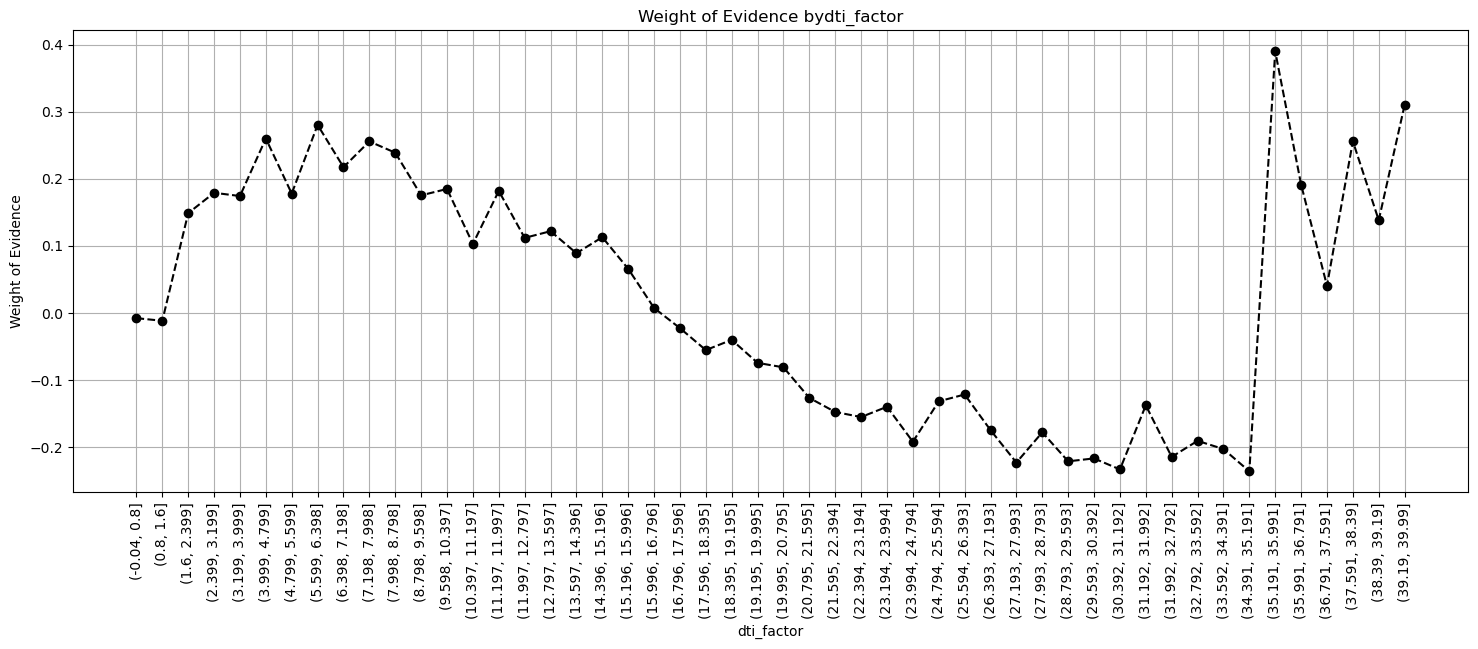

In [94]:
plot_woe(woe_ordered_continuous(X_train, 'dti_factor', y_train), 90)

In [95]:
X_train['dti:<=8'] = np.where(X_train['dti'] <= 8,1,0)
X_train['dti:8-15'] = np.where(
    ((X_train['dti'] >= 8) & (X_train['dti'] <= 15)),1,0
)

X_train['dti:15-20'] = np.where(
    ((X_train['dti'] >= 15) & (X_train['dti'] <= 20)),1,0
)

X_train['dti:>=21'] = np.where(X_train['dti'] >= 21 ,1,0)

In [96]:
X_test['dti:<=8'] = np.where(X_test['dti'] <= 8,1,0)
X_test['dti:8-15'] = np.where(
    ((X_test['dti'] >= 8) & (X_test['dti'] <= 15)),1,0
)

X_test['dti:15-20'] = np.where(
    ((X_test['dti'] >= 15) & (X_test['dti'] <= 20)),1,0
)

X_test['dti:>=21'] = np.where(X_test['dti'] >= 21 ,1,0)

#### mths_since_last_record

In [97]:
X_train['mths_since_last_record_factor'] = pd.cut(X_train['mths_since_last_record'], 50)
woe_ordered_continuous(X_train,'mths_since_last_record_factor',y_train)

mths_since_last_record_factor   n_obs  prop_good  prop_n_obs    n_good  \
0                 (-0.121, 2.42]  324047   0.901665    0.868694  292182.0   
1                   (2.42, 4.84]      76   0.921053    0.000204      70.0   
2                   (4.84, 7.26]     163   0.938650    0.000437     153.0   
3                   (7.26, 9.68]     156   0.929487    0.000418     145.0   
4                   (9.68, 12.1]     292   0.924658    0.000783     270.0   
5                  (12.1, 14.52]     207   0.932367    0.000555     193.0   
6                 (14.52, 16.94]     210   0.942857    0.000563     198.0   
7                 (16.94, 19.36]     334   0.916168    0.000895     306.0   
8                 (19.36, 21.78]     283   0.932862    0.000759     264.0   
9                  (21.78, 24.2]     455   0.916484    0.001220     417.0   
10                 (24.2, 26.62]     339   0.917404    0.000909     311.0   
11                (26.62, 29.04]     612   0.918301    0.001641     562.0   
12                (29.04, 31.46]     451   0.920177    0.001209     415.0   
13                (31.46, 33.88]     487   0.940452    0.001306     458.0   
14                 (33.88, 36.3]     780   0.932051    0.002091     727.0   
15                 (36.3, 38.72]     659   0.948407    0.001767     625.0   
16                (38.72, 41.14]    1008   0.936508    0.002702     944.0   
17                (41.14, 43.56]     812   0.944581    0.002177     767.0   
18                (43.56, 45.98]     791   0.939317    0.002120     743.0   
19                 (45.98, 48.4]    1316   0.938450    0.003528    1235.0   
20                 (48.4, 50.82]     945   0.933333    0.002533     882.0   
21                (50.82, 53.24]    1536   0.927083    0.004118    1424.0   
22                (53.24, 55.66]    1062   0.929379    0.002847     987.0   
23                (55.66, 58.08]    1662   0.935018    0.004455    1554.0   
24                 (58.08, 60.5]    1095   0.926941    0.002935    1015.0   
25                 (60.5, 62.92]    1213   0.919209    0.003252    1115.0   
26                (62.92, 65.34]    1631   0.924586    0.004372    1508.0   
27                (65.34, 67.76]    1088   0.932904    0.002917    1015.0   
28                (67.76, 70.18]    1513   0.925975    0.004056    1401.0   
29                 (70.18, 72.6]    1041   0.923151    0.002791     961.0   
30                 (72.6, 75.02]    1420   0.913380    0.003807    1297.0   
31                (75.02, 77.44]     946   0.911205    0.002536     862.0   
32                (77.44, 79.86]     939   0.916933    0.002517     861.0   
33                (79.86, 82.28]    1351   0.905996    0.003622    1224.0   
34                 (82.28, 84.7]     724   0.912983    0.001941     661.0   
35                 (84.7, 87.12]    1350   0.868889    0.003619    1173.0   
36                (87.12, 89.54]     822   0.878345    0.002204     722.0   
37                (89.54, 91.96]     904   0.875000    0.002423     791.0   
38                (91.96, 94.38]    1492   0.873995    0.004000    1304.0   
39                 (94.38, 96.8]    1145   0.861135    0.003069     986.0   
40                 (96.8, 99.22]    1821   0.896211    0.004882    1632.0   
41               (99.22, 101.64]    1258   0.880763    0.003372    1108.0   
42              (101.64, 104.06]    2096   0.896947    0.005619    1880.0   
43              (104.06, 106.48]    1536   0.893229    0.004118    1372.0   
44               (106.48, 108.9]    1559   0.905709    0.004179    1412.0   
45               (108.9, 111.32]    2296   0.899826    0.006155    2066.0   
46              (111.32, 113.74]    1461   0.900753    0.003917    1316.0   
47              (113.74, 116.16]    2037   0.880707    0.005461    1794.0   
48              (116.16, 118.58]    1236   0.915049    0.003313    1131.0   
49               (118.58, 121.0]     371   0.889488    0.000995     330.0   

      n_bad  prcnt_good  prcnt_bad       woe        IV  diff_prop_good  \
0

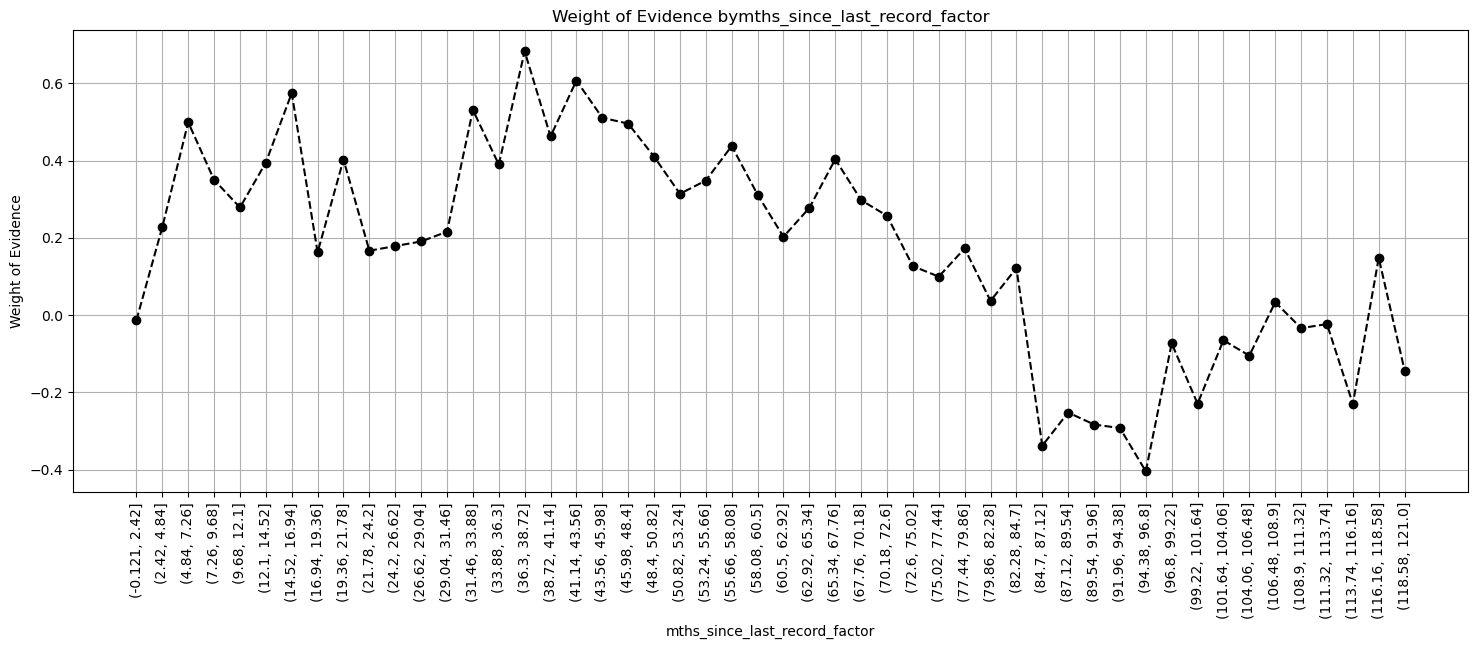

In [98]:
plot_woe(woe_ordered_continuous(X_train,'mths_since_last_record_factor',y_train),90)

In [99]:
X_train['mths_since_last_record:<=2'] = np.where(X_train['mths_since_last_record'] <= 2, 1, 0)
X_train['mths_since_last_record:2-27'] = np.where(
    ((X_train['mths_since_last_record'] >= 2) & (X_train['mths_since_last_record'] <= 27)), 1, 0
)

X_train['mths_since_last_record:27-60'] = np.where(
    ((X_train['mths_since_last_record'] >= 27) & (X_train['mths_since_last_record'] <= 60)), 1, 0
)

X_train['mths_since_last_record:60-88'] = np.where(
    ((X_train['mths_since_last_record'] >= 60) & (X_train['mths_since_last_record'] <= 88)), 1, 0
)
X_train['mths_since_last_record:>=88'] = np.where(X_train['mths_since_last_record'] >= 88, 1, 0)

In [100]:
X_test['mths_since_last_record:<=2'] = np.where(X_test['mths_since_last_record'] <= 2, 1, 0)
X_test['mths_since_last_record:2-27'] = np.where(
    ((X_test['mths_since_last_record'] >= 2) & (X_test['mths_since_last_record'] <= 27)), 1, 0
)

X_test['mths_since_last_record:27-60'] = np.where(
    ((X_test['mths_since_last_record'] >= 27) & (X_test['mths_since_last_record'] <= 60)), 1, 0
)

X_test['mths_since_last_record:60-88'] = np.where(
    ((X_test['mths_since_last_record'] >= 60) & (X_test['mths_since_last_record'] <= 88)), 1, 0
)
X_test['mths_since_last_record:>=88'] = np.where(X_test['mths_since_last_record'] >= 88, 1, 0)

## Feature Selection

In [101]:
X_train.head(2)

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
427211      427211  12796369   14818505      24000        24000   
206088      206088   1439740    1691948      10000        10000   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
427211          24000.0   36 months      8.90       762.08     A        A5   
206088          10000.0   36 months     14.33       343.39     C        C1   

       emp_length home_ownership verification_status issue_d loan_status  \
427211    3 years       MORTGAGE     Source Verified  Mar-14     Current   
206088    6 years       MORTGAGE        Not Verified  Aug-12  Fully Paid   

       pymnt_plan                                                url  \
427211          n  https://www.lendingclub.com/browse/loanDetail....   
206088          n  https://www.lendingclub.com/browse/loanDetail....   

                   purpose zip_code addr_state    dti     delinq_2yrs  \
427211  debt_consolidation    295xx         SC  21.91  (-0.029, 0.58]   
206088  debt_consolidation    070xx         NJ   7.49    (0.58, 1.16]   

       earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
427211           Dec-86             1.0                     0.0   
206088           Dec-97             2.0                    18.0   

        mths_since_last_record  open_acc  pub_rec  revol_bal  total_acc  \
427211                     0.0      20.0      0.0      30489       32.0   
206088                     0.0      15.0      0.0      15836       38.0   

       initial_list_status  out_prncp  out_prncp_inv  total_pymnt  \
427211                   f    10098.3        10098.3  16765.76000   
206088                   f        0.0            0.0  12357.02066   

        total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
427211         16765.76          13901.7        2864.06                 0.0   
206088         12357.02          10000.0        2357.02                 0.0   

        recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
427211         0.0                      0.0       Jan-16           762.08   
206088         0.0                      0.0       Aug-15           355.11   

       next_pymnt_d last_credit_pull_d  collections_12_mths_ex_med  \
427211       Feb-16             Jan-16                         0.0   
206088          NaN             Jul-15                         0.0   

        mths_since_last_major_derog  policy_code application_type  \
427211                          0.0            1       INDIVIDUAL   
206088                          0.0            1       INDIVIDUAL   

        acc_now_delinq  tot_coll_amt  emp_length_int  term_int  \
427211             0.0           0.0             3.0        36   
206088             0.0           0.0             6.0        36   

       earliest_cr_line_date issue_d_date last_pymnt_d_date next_pymnt_d_date  \
427211            1986-12-01   2014-03-01        2016-01-01        2016-02-01   
206088            1997-12-01   2012-08-01        2015-08-01               NaN   

       last_credit_pull_d_date  mths_since_earliest_cr_line  \
427211              2016-01-01                        438.0   
206088              2015-07-01                        306.0   

        mths_since_issue_date  grade:A  grade:B  grade:C  grade:D  grade:E  \
427211                  438.0        1        0        0        0        0   
206088                  306.0        0        0        1        0        0   

        grade:F  grade:G  sub_grade:A1  sub_grade:A2  sub_grade:A3  \
427211        0        0             0             0             0   
206088        0        0             0             0             0   

        sub_grade:A4  sub_grade:A5  sub_grade:B1  sub_grade:B2  sub_grade:B3  \
427211             0             1             0             0             0   
206088             0             0             0             0             0   

        sub_grade:B4  sub_grade:B5  sub_grade:C1  sub_grade:

In [102]:
selected_feature = [
'grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'ownership:MORTGAGE',
'ownership:OWN',
'adrr_state:CA',
'adrr_state:KY_VA',
'adrr_state:NY',
'adrr_state:NC_UT',
'adrr_state:MD_NJ_LA_OK_MI_TN',
'adrr_state:MN_AZ_DE_PA_AR_OH',
'adrr_state:WA_MA_IN_GA_RI_OR',
'adrr_state:WI_SD_CT',
'adrr_state:TX',
'adrr_state:KS_IL_MT',
'adrr_state:CO_SC_VT_AK',
'adrr_state:MS_NH_WY_WV_DC_ME_ID',
'purpose:renewable_energy_other_house',
'purpose:medical_wedding_vacation',
'purpose:debt_consolidation',
'purpose:home_improvement_major_purchase_car',
'purpose:credit_card',
'ver_status:Source Verified',
'ver_status:Not Verified',
'list_status:w',
'term:60',
'mths_since_issue_date:200-240',
'mths_since_issue_date:240-282',
'mths_since_issue_date:282-314',
'mths_since_issue_date:314-334',
'mths_since_issue_date:334-488',
'mths_since_issue_date:>=488',
'int_rate:8-10',
'int_rate:10-14',
'int_rate:14-19',
'int_rate:>=19',
'mths_since_earliest_cr_line:190-293',
'mths_since_earliest_cr_line:293-344',
'mths_since_earliest_cr_line:344-498',
'mths_since_earliest_cr_line:>=498',
'open_acc:12-25',
'open_acc:>=25',
'total_acc:13-30',
'total_acc:30-51',
'total_acc:51-66',
'total_acc:>=66',
'annual_inc:20k-30k',
'annual_inc:30k-40k',
'annual_inc:40k-50k',
'annual_inc:50k-60k',
'annual_inc:60k-70k',
'annual_inc:70k-80k',
'annual_inc:80k-90k',
'annual_inc:90k-100k',
'annual_inc:100k-120k',
'annual_inc:120k-140k',
'annual_inc:>140k',
'mths_since_last_delinq:33-60',
'mths_since_last_delinq:>60',
'dti:8-15',
'dti:15-20',
'dti:>=21',
'mths_since_last_record:2-27',
'mths_since_last_record:27-60',
'mths_since_last_record:60-88',
'mths_since_last_record:>=88'
]

reference_feature = [
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'adrr_state:NE_IA_NV_FL_AL_NM_HI_MO',
'purpose:small_business_educational_moving',
'ver_status:Verified',
'list_status:f',
'term:36',
'mths_since_issue_date:<=200',
'int_rate:<=8',
'mths_since_earliest_cr_line:<=190',
'open_acc:<=12',
'total_acc:<=13',
'annual_inc:<20k',
'mths_since_last_delinq:<=33',
'dti:<=8',
'mths_since_last_record:<=2'
]

In [103]:
selected_dummy_train = X_train[selected_feature]
selected_dummy_train.head()

grade:A  grade:B  grade:C  grade:D  grade:E  grade:F  \
427211        1        0        0        0        0        0   
206088        0        0        1        0        0        0   
136020        1        0        0        0        0        0   
412305        0        0        0        1        0        0   
36159         0        0        1        0        0        0   

        ownership:MORTGAGE  ownership:OWN  adrr_state:CA  adrr_state:KY_VA  \
427211                   1              0              0                 0   
206088                   1              0              0                 0   
136020                   1              0              0                 0   
412305                   0              0              0                 0   
36159                    1              0              1                 0   

        adrr_state:NY  adrr_state:NC_UT  adrr_state:MD_NJ_LA_OK_MI_TN  \
427211              0                 0                             0   
206088              0                 0                             1   
136020              0                 0                             0   
412305              0                 0                             0   
36159               0                 0                             0   

        adrr_state:MN_AZ_DE_PA_AR_OH  adrr_state:WA_MA_IN_GA_RI_OR  \
427211                             0                             0   
206088                             0                             0   
136020                             0                             1   
412305                             0                             1   
36159                              0                             0   

        adrr_state:WI_SD_CT  adrr_state:TX  adrr_state:KS_IL_MT  \
427211                    0              0                    0   
206088                    0              0                    0   
136020                    0              0                    0   
412305                    0              0                    0   
36159                     0              0                    0   

        adrr_state:CO_SC_VT_AK  adrr_state:MS_NH_WY_WV_DC_ME_ID  \
427211                       1                                0   
206088                       0                                0   
136020                       0                                0   
412305                       0                                0   
36159                        0                                0   

        purpose:renewable_energy_other_house  \
427211                                     0   
206088                                     0   
136020                                     0   
412305                                     0   
36159                                      0   

        purpose:medical_wedding_vacation  purpose:debt_consolidation  \
427211                                 0                           1   
206088                                 0                           1   
136020                                 0                           1   
412305                                 0                           1   
36159                                  0                           0   

        purpose:home_improvement_major_purchase_car  purpose:credit_card  \
427211                                            0                    0   
206088                                            0                    0   
136020                                            0                    0   
412305                                            0                    0   
36159                                             0                    0   

        ver_status:Source Verified  ver_status:Not Verified  list_status:w  \
427211                           1                        0              0   
206088                           0                        1              0   
136020                           0                        0              0 

In [104]:
selected_dummy_train.shape

(373028, 69)

# PD Model

## Fitting PD Model using Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

pd.options.display.max_rows = None

reg = LogisticRegression()
reg.fit(selected_dummy_train, y_train)

LogisticRegression()

In [106]:
feature_name = selected_dummy_train.columns.values

summary_table = pd.DataFrame(columns=['Feature Name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)

#Let's insert the intercept score at the first row
summary_table.index = summary_table.index+1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]

#Sorting the summary table by the index
summary_table = summary_table.sort_index()

In [107]:
summary_table

Feature Name  Coefficients
0                                     Intercept      1.757451
1                                       grade:A      0.837108
2                                       grade:B      0.852406
3                                       grade:C      0.756873
4                                       grade:D      0.568779
5                                       grade:E      0.387745
6                                       grade:F      0.131619
7                            ownership:MORTGAGE      0.133530
8                                 ownership:OWN      0.134562
9                                 adrr_state:CA      0.044990
10                             adrr_state:KY_VA      0.054891
11                                adrr_state:NY      0.086936
12                             adrr_state:NC_UT      0.082710
13                 adrr_state:MD_NJ_LA_OK_MI_TN      0.082705
14                 adrr_state:MN_AZ_DE_PA_AR_OH      0.126869
15                 adrr_state:WA_MA_IN_GA_RI_OR      0.145830
16                          adrr_state:WI_SD_CT      0.208196
17                                adrr_state:TX      0.236443
18                          adrr_state:KS_IL_MT      0.261425
19                       adrr_state:CO_SC_VT_AK      0.334220
20              adrr_state:MS_NH_WY_WV_DC_ME_ID      0.479631
21         purpose:renewable_energy_other_house      0.450520
22             purpose:medical_wedding_vacation      0.480171
23                   purpose:debt_consolidation      0.517682
24  purpose:home_improvement_major_purchase_car      0.501671
25                          purpose:credit_card      0.635254
26                   ver_status:Source Verified      0.156399
27                      ver_status:Not Verified      0.130199
28                                list_status:w      0.402192
29                                      term:60     -0.018206
30                mths_since_issue_date:200-240      0.045994
31                mths_since_issue_date:240-282     -0.007442
32                mths_since_issue_date:282-314     -0.020042
33                mths_since_issue_date:314-334      0.004851
34                mths_since_issue_date:334-488      0.032045
35                  mths_since_issue_date:>=488     -0.047624
36                                int_rate:8-10     -0.386647
37                               int_rate:10-14     -0.847994
38                               int_rate:14-19     -1.187649
39                                int_rate:>=19     -1.339568
40          mths_since_earliest_cr_line:190-293     -0.124604
41          mths_since_earliest_cr_line:293-344     -0.108207
42          mths_since_earliest_cr_line:344-498     -0.063527
43            mths_since_earliest_cr_line:>=498      0.006327
44                               open_acc:12-25     -0.010384
45                                open_acc:>=25      0.074995
46                              total_acc:13-30     -0.013663
47                              total_acc:30-51     -0.034545
48                              total_acc:51-66     -0.008641
49                               total_acc:>=66      0.299049
50                           annual_inc:20k-30k     -0.261333
51                           annual_inc:30k-40k     -0.213807
52                           annual_inc:40k-50k     -0.150550
53                           annual_inc:50k-60k     -0.058238
54                           annual_inc:60k-70k     -0.052092
55                           annual_inc:70k-80k      0.041287
56                           annual_inc:80k-90k      0.091147
57                          annual_inc:90k-100k      0.086543
58                         annual_inc:100k-120k      0.210711
59                         annual_inc:120k-140k      0.209417
60                             annual_inc:>140k      0.309262
61                 mths_since_last_delinq:33-60      0.101255
62                   mths_since_last_delinq:>60      0.033227
63                                     dti:8-15     -0.000411
64   

## Build Logistic Regression Model with P-Value

In [108]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    #In order to fit function run properly, make sure there is no Zero-Sum value in our dataset.
    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [109]:
reg = LogisticRegression_with_p_values()
reg.fit(selected_dummy_train, y_train)

In [110]:
feature_name = selected_dummy_train.columns.values

summary_table = pd.DataFrame(columns=['Feature Name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)

#Let's insert the intercept score at the first row
summary_table.index = summary_table.index+1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]

#Sorting the summary table by the index
summary_table = summary_table.sort_index()
summary_table

Feature Name  Coefficients
0                                     Intercept      1.757451
1                                       grade:A      0.837108
2                                       grade:B      0.852406
3                                       grade:C      0.756873
4                                       grade:D      0.568779
5                                       grade:E      0.387745
6                                       grade:F      0.131619
7                            ownership:MORTGAGE      0.133530
8                                 ownership:OWN      0.134562
9                                 adrr_state:CA      0.044990
10                             adrr_state:KY_VA      0.054891
11                                adrr_state:NY      0.086936
12                             adrr_state:NC_UT      0.082710
13                 adrr_state:MD_NJ_LA_OK_MI_TN      0.082705
14                 adrr_state:MN_AZ_DE_PA_AR_OH      0.126869
15                 adrr_state:WA_MA_IN_GA_RI_OR      0.145830
16                          adrr_state:WI_SD_CT      0.208196
17                                adrr_state:TX      0.236443
18                          adrr_state:KS_IL_MT      0.261425
19                       adrr_state:CO_SC_VT_AK      0.334220
20              adrr_state:MS_NH_WY_WV_DC_ME_ID      0.479631
21         purpose:renewable_energy_other_house      0.450520
22             purpose:medical_wedding_vacation      0.480171
23                   purpose:debt_consolidation      0.517682
24  purpose:home_improvement_major_purchase_car      0.501671
25                          purpose:credit_card      0.635254
26                   ver_status:Source Verified      0.156399
27                      ver_status:Not Verified      0.130199
28                                list_status:w      0.402192
29                                      term:60     -0.018206
30                mths_since_issue_date:200-240      0.045994
31                mths_since_issue_date:240-282     -0.007442
32                mths_since_issue_date:282-314     -0.020042
33                mths_since_issue_date:314-334      0.004851
34                mths_since_issue_date:334-488      0.032045
35                  mths_since_issue_date:>=488     -0.047624
36                                int_rate:8-10     -0.386647
37                               int_rate:10-14     -0.847994
38                               int_rate:14-19     -1.187649
39                                int_rate:>=19     -1.339568
40          mths_since_earliest_cr_line:190-293     -0.124604
41          mths_since_earliest_cr_line:293-344     -0.108207
42          mths_since_earliest_cr_line:344-498     -0.063527
43            mths_since_earliest_cr_line:>=498      0.006327
44                               open_acc:12-25     -0.010384
45                                open_acc:>=25      0.074995
46                              total_acc:13-30     -0.013663
47                              total_acc:30-51     -0.034545
48                              total_acc:51-66     -0.008641
49                               total_acc:>=66      0.299049
50                           annual_inc:20k-30k     -0.261333
51                           annual_inc:30k-40k     -0.213807
52                           annual_inc:40k-50k     -0.150550
53                           annual_inc:50k-60k     -0.058238
54                           annual_inc:60k-70k     -0.052092
55                           annual_inc:70k-80k      0.041287
56                           annual_inc:80k-90k      0.091147
57                          annual_inc:90k-100k      0.086543
58                         annual_inc:100k-120k      0.210711
59                         annual_inc:120k-140k      0.209417
60                             annual_inc:>140k      0.309262
61                 mths_since_last_delinq:33-60      0.101255
62                   mths_since_last_delinq:>60      0.033227
63                                     dti:8-15     -0.000411
64   

In [111]:
p_values = reg.p_values

#Since we only have the p_value for our independent variable, therefore we can just add NaN value at the intercept rows 
p_values = np.append(np.nan, np.array(p_values))

summary_table['p_values'] = p_values
summary_table

Feature Name  Coefficients       p_values
0                                     Intercept      1.757451            NaN
1                                       grade:A      0.837108   9.439745e-76
2                                       grade:B      0.852406   4.907764e-75
3                                       grade:C      0.756873   1.079987e-64
4                                       grade:D      0.568779   5.427892e-39
5                                       grade:E      0.387745   1.397174e-19
6                                       grade:F      0.131619   4.496237e-03
7                            ownership:MORTGAGE      0.133530   1.142093e-24
8                                 ownership:OWN      0.134562   1.741261e-10
9                                 adrr_state:CA      0.044990   3.088841e-02
10                             adrr_state:KY_VA      0.054891   8.036687e-02
11                                adrr_state:NY      0.086936   3.495248e-04
12                             adrr_state:NC_UT      0.082710   1.289938e-02
13                 adrr_state:MD_NJ_LA_OK_MI_TN      0.082705   1.820361e-04
14                 adrr_state:MN_AZ_DE_PA_AR_OH      0.126869   1.306072e-08
15                 adrr_state:WA_MA_IN_GA_RI_OR      0.145830   2.396548e-10
16                          adrr_state:WI_SD_CT      0.208196   1.965029e-08
17                                adrr_state:TX      0.236443   2.177230e-19
18                          adrr_state:KS_IL_MT      0.261425   9.802253e-18
19                       adrr_state:CO_SC_VT_AK      0.334220   1.906962e-21
20              adrr_state:MS_NH_WY_WV_DC_ME_ID      0.479631   7.754129e-21
21         purpose:renewable_energy_other_house      0.450520   4.800912e-38
22             purpose:medical_wedding_vacation      0.480171   1.758168e-25
23                   purpose:debt_consolidation      0.517682   1.128904e-69
24  purpose:home_improvement_major_purchase_car      0.501671   6.421561e-48
25                          purpose:credit_card      0.635254   6.581545e-90
26                   ver_status:Source Verified      0.156399   3.417811e-30
27                      ver_status:Not Verified      0.130199   1.392108e-18
28                                list_status:w      0.402192  4.682222e-216
29                                      term:60     -0.018206   2.049665e-01
30                mths_since_issue_date:200-240      0.045994   1.077841e-01
31                mths_since_issue_date:240-282     -0.007442   7.854663e-01
32                mths_since_issue_date:282-314     -0.020042   4.903150e-01
33                mths_since_issue_date:314-334      0.004851   8.904409e-01
34                mths_since_issue_date:334-488      0.032045   4.341224e-01
35                  mths_since_issue_date:>=488     -0.047624   5.974612e-01
36                                int_rate:8-10     -0.386647   1.254179e-22
37                               int_rate:10-14     -0.847994   9.436919e-77
38                               int_rate:14-19     -1.187649  4.997521e-146
39                                int_rate:>=19     -1.339568  1.395608e-182
40          mths_since_earliest_cr_line:190-293     -0.124604   1.093690e-04
41          mths_since_earliest_cr_line:293-344     -0.108207   2.483660e-03
42          mths_since_earliest_cr_line:344-498     -0.063527   1.651093e-01
43            mths_since_earliest_cr_line:>=498      0.006327   9.481629e-01
44                               open_acc:12-25     -0.010384   4.364307e-01
45                                open_acc:>=25      0.074995   1.241065e-01
46                              total_acc:13-30     -0.013663   4.010626e-01
47                              total_acc:30-51     -0.034545   8.515495e-02
48                              total_acc:51-66     -0.008641   8.319006e-01
49                               total_acc:>=66      0.299049   5.415270e-02
50                           annual_inc:20k-30k     -0.261333   1.191718e-26
51                           an

**Note to remember:**<br>

Since each original independent variable is represented by several dummy variables, therefore, if the coefficients for all of these dummy variables are statistically significant, **we should retain all ofd them**.<br><br>

On the other hand, if the coefficients for non of the dummy variables are statistically significant, **we should remove all of them**

*So, what happens if the coefficient for some of the dummy variables are statistically significant and others are not (like 50:50)?*<br>

Technically, it surely make sense to remove non-statistically significant ones, but if we do that, **there will be few variables in the model representing a part or parts of the original independent variables**.<br>

Hence, in this case, it would be best to **retain all dummy variables that represents that original variable in the final model**

## How to determine the good P-Values?

Conventionally, if a p-values < 0.05, we conclude that the coefficient of a variable is **statistically significant**.<br>

Try to move the summary_table into excel, and convert the statistic notation number into decimal format.

In [112]:
#Filter the feature by the desired p_values

selected_feature = [
'grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'ownership:MORTGAGE',
'ownership:OWN',
'adrr_state:CA',
'adrr_state:KY_VA',
'adrr_state:NY',
'adrr_state:NC_UT',
'adrr_state:MD_NJ_LA_OK_MI_TN',
'adrr_state:MN_AZ_DE_PA_AR_OH',
'adrr_state:WA_MA_IN_GA_RI_OR',
'adrr_state:WI_SD_CT',
'adrr_state:TX',
'adrr_state:KS_IL_MT',
'adrr_state:CO_SC_VT_AK',
'adrr_state:MS_NH_WY_WV_DC_ME_ID',
'purpose:renewable_energy_other_house',
'purpose:medical_wedding_vacation',
'purpose:debt_consolidation',
'purpose:home_improvement_major_purchase_car',
'purpose:credit_card',
'ver_status:Source Verified',
'ver_status:Not Verified',
'list_status:w',
'int_rate:8-10',
'int_rate:10-14',
'int_rate:14-19',
'int_rate:>=19',
'annual_inc:20k-30k',
'annual_inc:30k-40k',
'annual_inc:40k-50k',
'annual_inc:50k-60k',
'annual_inc:60k-70k',
'annual_inc:70k-80k',
'annual_inc:80k-90k',
'annual_inc:90k-100k',
'annual_inc:100k-120k',
'annual_inc:120k-140k',
'annual_inc:>140k'
]

In [113]:
selected_dummy_train = X_train[selected_feature]
selected_dummy_train.head()

grade:A  grade:B  grade:C  grade:D  grade:E  grade:F  \
427211        1        0        0        0        0        0   
206088        0        0        1        0        0        0   
136020        1        0        0        0        0        0   
412305        0        0        0        1        0        0   
36159         0        0        1        0        0        0   

        ownership:MORTGAGE  ownership:OWN  adrr_state:CA  adrr_state:KY_VA  \
427211                   1              0              0                 0   
206088                   1              0              0                 0   
136020                   1              0              0                 0   
412305                   0              0              0                 0   
36159                    1              0              1                 0   

        adrr_state:NY  adrr_state:NC_UT  adrr_state:MD_NJ_LA_OK_MI_TN  \
427211              0                 0                             0   
206088              0                 0                             1   
136020              0                 0                             0   
412305              0                 0                             0   
36159               0                 0                             0   

        adrr_state:MN_AZ_DE_PA_AR_OH  adrr_state:WA_MA_IN_GA_RI_OR  \
427211                             0                             0   
206088                             0                             0   
136020                             0                             1   
412305                             0                             1   
36159                              0                             0   

        adrr_state:WI_SD_CT  adrr_state:TX  adrr_state:KS_IL_MT  \
427211                    0              0                    0   
206088                    0              0                    0   
136020                    0              0                    0   
412305                    0              0                    0   
36159                     0              0                    0   

        adrr_state:CO_SC_VT_AK  adrr_state:MS_NH_WY_WV_DC_ME_ID  \
427211                       1                                0   
206088                       0                                0   
136020                       0                                0   
412305                       0                                0   
36159                        0                                0   

        purpose:renewable_energy_other_house  \
427211                                     0   
206088                                     0   
136020                                     0   
412305                                     0   
36159                                      0   

        purpose:medical_wedding_vacation  purpose:debt_consolidation  \
427211                                 0                           1   
206088                                 0                           1   
136020                                 0                           1   
412305                                 0                           1   
36159                                  0                           0   

        purpose:home_improvement_major_purchase_car  purpose:credit_card  \
427211                                            0                    0   
206088                                            0                    0   
136020                                            0                    0   
412305                                            0                    0   
36159                                             0                    0   

        ver_status:Source Verified  ver_status:Not Verified  list_status:w  \
427211                           1                        0              0   
206088                           0                        1              0   
136020                           0                        0              0 

In [114]:
selected_dummy_train.shape

(373028, 43)

In [115]:
reg2 = LogisticRegression_with_p_values()
reg2.fit(selected_dummy_train, y_train)

In [116]:
feature_name = selected_dummy_train.columns.values

summary_table = pd.DataFrame(columns=['Feature Name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_)

#Let's insert the intercept score at the first row
summary_table.index = summary_table.index+1
summary_table.loc[0] = ['Intercept', reg2.intercept_[0]]

#Sorting the summary table by the index
summary_table = summary_table.sort_index()

p_values = reg2.p_values

#Since we only have the p_value for our independent variable, therefore we can just add NaN value at the intercept rows 
p_values = np.append(np.nan, np.array(p_values))

summary_table['p_values'] = p_values
summary_table

Feature Name  Coefficients       p_values
0                                     Intercept      1.652745            NaN
1                                       grade:A      0.825896   3.273775e-92
2                                       grade:B      0.848172   1.270284e-80
3                                       grade:C      0.762474   1.635581e-69
4                                       grade:D      0.577627   5.086944e-42
5                                       grade:E      0.395092   6.853821e-21
6                                       grade:F      0.133544   3.529709e-03
7                            ownership:MORTGAGE      0.124502   9.731902e-23
8                                 ownership:OWN      0.133540   1.838135e-10
9                                 adrr_state:CA      0.054348   8.924485e-03
10                             adrr_state:KY_VA      0.051913   9.763041e-02
11                                adrr_state:NY      0.097173   6.066138e-05
12                             adrr_state:NC_UT      0.078395   1.828726e-02
13                 adrr_state:MD_NJ_LA_OK_MI_TN      0.088617   5.867166e-05
14                 adrr_state:MN_AZ_DE_PA_AR_OH      0.128291   8.245639e-09
15                 adrr_state:WA_MA_IN_GA_RI_OR      0.151946   3.736939e-11
16                          adrr_state:WI_SD_CT      0.216326   5.128988e-09
17                                adrr_state:TX      0.222638   2.029059e-17
18                          adrr_state:KS_IL_MT      0.260735   1.059460e-17
19                       adrr_state:CO_SC_VT_AK      0.329628   5.858956e-21
20              adrr_state:MS_NH_WY_WV_DC_ME_ID      0.475194   1.591118e-20
21         purpose:renewable_energy_other_house      0.447693   5.874247e-38
22             purpose:medical_wedding_vacation      0.471671   8.744120e-25
23                   purpose:debt_consolidation      0.490777   4.293527e-65
24  purpose:home_improvement_major_purchase_car      0.507781   9.284597e-50
25                          purpose:credit_card      0.604664   3.038589e-84
26                   ver_status:Source Verified      0.165975   3.569120e-34
27                      ver_status:Not Verified      0.130291   1.086941e-19
28                                list_status:w      0.408323  1.618106e-226
29                                int_rate:8-10     -0.384698   4.580598e-23
30                               int_rate:10-14     -0.845610   9.279374e-82
31                               int_rate:14-19     -1.199428  4.779747e-163
32                                int_rate:>=19     -1.363087  6.827471e-213
33                           annual_inc:20k-30k     -0.252516   1.597124e-25
34                           annual_inc:30k-40k     -0.213089   1.812403e-29
35                           annual_inc:40k-50k     -0.153540   8.364255e-18
36                           annual_inc:50k-60k     -0.061285   5.971846e-04
37                           annual_inc:60k-70k     -0.053787   4.383894e-03
38                           annual_inc:70k-80k      0.038982   6.143089e-02
39                           annual_inc:80k-90k      0.092508   6.820069e-05
40                          annual_inc:90k-100k      0.088660   5.366001e-04
41                         annual_inc:100k-120k      0.218146   5.089559e-17
42                         annual_inc:120k-140k      0.221162   9.677264e-12
43                             annual_inc:>140k      0.342012   3.461997e-28

In [117]:
selected_dummy_test = X_test[selected_feature]

In [118]:
y_hat_test = reg2.model.predict(selected_dummy_test)

In [119]:
y_hat_test

array([1, 1, 1, ..., 1, 1, 1])

In [120]:
y_hat_test_proba = reg2.model.predict_proba(selected_dummy_test)
y_hat_test_proba

#The result below: [prob_bad_borrower, prob_good_borrower]

array([[0.1360331 , 0.8639669 ],
       [0.13480634, 0.86519366],
       [0.09100924, 0.90899076],
       ...,
       [0.03537184, 0.96462816],
       [0.05862232, 0.94137768],
       [0.03438234, 0.96561766]])

In [121]:
#let just store the prob_good_borrower value into the y_hat_test_proba variable
y_hat_test_proba = y_hat_test_proba[:][:,1]

In [122]:
y_hat_test_proba

array([0.8639669 , 0.86519366, 0.90899076, ..., 0.96462816, 0.94137768,
       0.96561766])

In [123]:
data_test_temp = y_test

In [124]:
data_test_temp.shape

(93257,)

In [125]:
y_hat_test_proba.shape

(93257,)

In [126]:
#Since we want to combine the data_test_temp and the y_hat_test_proba, we need to reset the index of our data_test_temp (it is not begin with 0, meanwhile, the y_hat_test_proba starts with 0)
data_test_temp.reset_index(drop=True, inplace=True)

In [127]:
data_actual_predicted_proba = pd.concat([data_test_temp, pd.DataFrame(y_hat_test_proba)], axis=1)

In [128]:
data_actual_predicted_proba.columns = ['data_target_test','y_hat_test_proba']

#return the index so it became the same again with the X_test index
data_actual_predicted_proba.index = X_test.index

In [129]:
data_actual_predicted_proba.head()

data_target_test  y_hat_test_proba
362514                 1          0.863967
288564                 1          0.865194
213591                 1          0.908991
263083                 1          0.919842
165001                 1          0.949311

## Evaluate the Acc of the Model

In [130]:
#tr = threshold
tr= 0.9
data_actual_predicted_proba['y_hat_test'] = np.where(data_actual_predicted_proba['y_hat_test_proba'] > tr, 1, 0)

In [131]:
conf_metrics = pd.crosstab(data_actual_predicted_proba['data_target_test'], data_actual_predicted_proba['y_hat_test'],
           rownames=['Actual'], colnames=['Predicted'])

conf_metrics

Predicted      0      1
Actual                 
0           5752   3275
1          32017  52213

In [132]:
acc = (conf_metrics[1][1] + conf_metrics[0][0])/data_actual_predicted_proba.shape[0]
acc*100

62.15619202848044

While we use the threshold of 0.6, indeed we get a high accuracy up to 90%. However, the number of false positive is also significantly high, since False Positive is the most risky indicators in this case.<br>

On the other hand, if we use the threshold of 0.9, we might reduce the False Positive number significantly, but we also reduce the accuracy up to 60%.<br>

**Solution?** we can use ROC Curve.

In [133]:
from sklearn.metrics import roc_auc_score, roc_curve

In [134]:
fpr, tpr, threshold = roc_curve(data_actual_predicted_proba['data_target_test'], data_actual_predicted_proba['y_hat_test_proba'])

#The result below gives us three array:
#1. False Positive Rate | 2. True Positive Rate | 3. Threshold

Text(0.5, 1.0, 'ROC Curve')

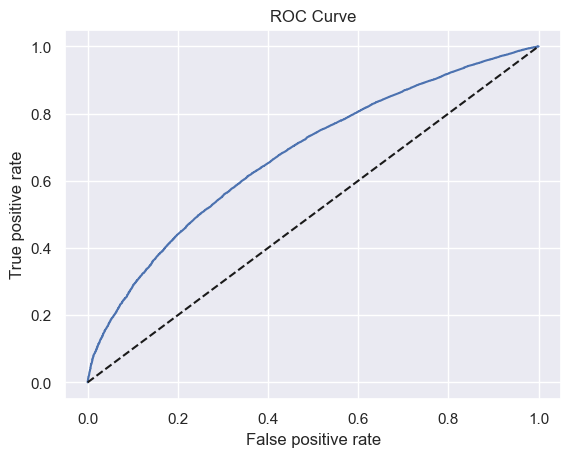

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(fpr,tpr)
plt.plot(fpr, fpr, linestyle='--', color='k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')

In [136]:
auc_roc = roc_auc_score(data_actual_predicted_proba['data_target_test'], data_actual_predicted_proba['y_hat_test_proba'])
auc_roc

0.6769914700869493

*As for the Credit Risk cases, the model evaluation process is conducted by using either **Gini Coefficient** or **Kolmogorov-Smirnov Coefficient**

## Gini and Kolmogorov-Smirnov

In [137]:
data_actual_predicted_proba.head()

data_target_test  y_hat_test_proba  y_hat_test
362514                 1          0.863967           0
288564                 1          0.865194           0
213591                 1          0.908991           1
263083                 1          0.919842           1
165001                 1          0.949311           1

In [138]:
#In order plotting the Gini plot, we need to order the dataframe that contains the target and the probabilities
#estimated in ascending order.

data_actual_predicted_proba = data_actual_predicted_proba.sort_values('y_hat_test_proba').reset_index()

In [139]:
data_actual_predicted_proba.head()

index  data_target_test  y_hat_test_proba  y_hat_test
0   79004                 1          0.527702           0
1  321778                 1          0.532250           0
2   36242                 1          0.532683           0
3  250047                 0          0.533528           0
4  372240                 1          0.533977           0

In [140]:
# What we need?
# 1. the cummulative % of total population
# 2. the cummulative % of good borrowers
# 3. the cummulative % of bad borrowers

data_actual_predicted_proba['Cummulative N Population'] = data_actual_predicted_proba.index+1
data_actual_predicted_proba['Cummulative N Good'] = data_actual_predicted_proba['data_target_test'].cumsum()
data_actual_predicted_proba['Cummulative N Bad'] = data_actual_predicted_proba['Cummulative N Population'] - data_actual_predicted_proba['data_target_test'].cumsum()

In [141]:
data_actual_predicted_proba.tail(20)

index  data_target_test  y_hat_test_proba  y_hat_test  \
93237  260940                 1          0.988324           1   
93238  243684                 1          0.988388           1   
93239  381770                 1          0.988421           1   
93240  362747                 1          0.988499           1   
93241  345563                 1          0.988499           1   
93242  241607                 1          0.988502           1   
93243  326202                 1          0.988502           1   
93244  428914                 1          0.988601           1   
93245  385147                 1          0.988694           1   
93246  285628                 1          0.988777           1   
93247  327421                 1          0.988854           1   
93248  419544                 1          0.988854           1   
93249  180812                 1          0.988854           1   
93250  310684                 1          0.989285           1   
93251  401126                 1          0.989318           1   
93252  245264                 1          0.989513           1   
93253  337568                 1          0.989770           1   
93254  398407                 1          0.989770           1   
93255  258018                 1          0.989876           1   
93256  175131                 1          0.990195           1   

       Cummulative N Population  Cummulative N Good  Cummulative N Bad  
93237                     93238               84211               9027  
93238                     93239               84212               9027  
93239                     93240               84213               9027  
93240                     93241               84214               9027  
93241                     93242               84215               9027  
93242                     93243               84216               9027  
93243                     93244               84217               9027  
93244                     93245               84218               9027  
93245                     93246               84219               9027  
93246                     93247               84220               9027  
93247                     93248               84221               9027  
93248                     93249               84222               9027  
93249                     93250               84223               9027  
93250                     93251               84224               9027  
93251                     93252               84225               9027  
93252                     93253               84226               9027  
93253                     93254               84227               9027  
93254                     93255               84228               9027  
93255                     93256               84229               9027  
93256                     93257               84230               9027

In [142]:
data_actual_predicted_proba['Cummulative N Good'].iloc[-1]

84230

In [143]:
data_actual_predicted_proba['Cummulative % Population'] = data_actual_predicted_proba['Cummulative N Population'] / (data_actual_predicted_proba.shape[0])

data_actual_predicted_proba['Cummulative % Good'] = data_actual_predicted_proba['Cummulative N Good'] / data_actual_predicted_proba['data_target_test'].sum()

data_actual_predicted_proba['Cummulative % Bad'] = data_actual_predicted_proba['Cummulative N Bad'] / (data_actual_predicted_proba.shape[0] - data_actual_predicted_proba['data_target_test'].sum())


In [144]:
data_actual_predicted_proba.head(20)

index  data_target_test  y_hat_test_proba  y_hat_test  \
0    79004                 1          0.527702           0   
1   321778                 1          0.532250           0   
2    36242                 1          0.532683           0   
3   250047                 0          0.533528           0   
4   372240                 1          0.533977           0   
5   432980                 1          0.552336           0   
6    35909                 0          0.556985           0   
7   118863                 1          0.565134           0   
8   278558                 1          0.566567           0   
9    96809                 0          0.567010           0   
10   10876                 0          0.569917           0   
11   73398                 0          0.571206           0   
12  373202                 1          0.574681           0   
13  465514                 1          0.574954           0   
14   59170                 1          0.576339           0   
15  406842                 1          0.580301           0   
16   47426                 1          0.581565           0   
17   18540                 0          0.583380           0   
18  317493                 1          0.586505           0   
19  412484                 1          0.589504           0   

    Cummulative N Population  Cummulative N Good  Cummulative N Bad  \
0                          1                   1                  0   
1                          2                   2                  0   
2                          3                   3                  0   
3                          4                   3                  1   
4                          5                   4                  1   
5                          6                   5                  1   
6                          7                   5                  2   
7                          8                   6                  2   
8                          9                   7                  2   
9                         10                   7                  3   
10                        11                   7                  4   
11                        12                   7                  5   
12                        13                   8                  5   
13                        14                   9                  5   
14                        15                  10                  5   
15                        16                  11                  5   
16                        17                  12                  5   
17                        18                  12                  6   
18                        19                  13                  6   
19                        20                  14                  6   

    Cummulative % Population  Cummulative % Good  Cummulative % Bad  
0                   0.000011            0.000012           0.000000  
1                   0.000021            0.000024           0.000000  
2                   0.000032            0.000036           0.000000  
3                   0.000043            0.000036           0.000111  
4                   0.000054            0.000047           0.000111  
5                   0.000064            0.000059           0.000111  
6                   0.000075            0.000059           0.000222  
7                   0.000086            0.000071           0.000222  
8                   0.000097            0.000083           0.000222  
9                   0.000107            0.000083           0.000332  
10                  0.000118            0.000083           0.000443  
11                  0.000129            0.000083           0.000554  
12                  0.000139            0.000095           0.000554  
13                  0.000150            0.000107           0.000554  
14                  0.000161            0.000119           0.000554  
15                  0.000172            0.000131           0.000554  
16                  

Text(0.5, 1.0, 'Gini')

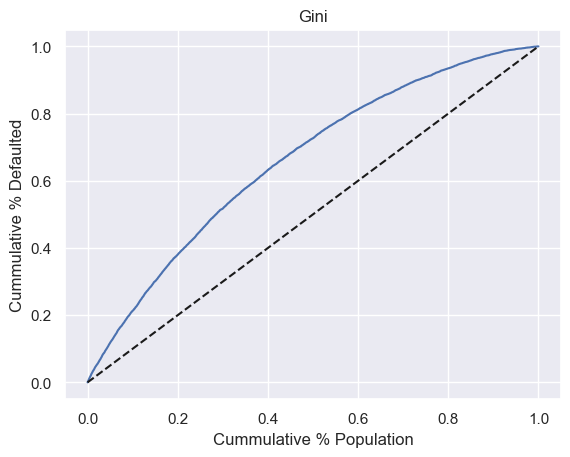

In [145]:
plt.plot(data_actual_predicted_proba['Cummulative % Population'], data_actual_predicted_proba['Cummulative % Bad'])
plt.plot(data_actual_predicted_proba['Cummulative % Population'], data_actual_predicted_proba['Cummulative % Population'], linestyle='--', color='k')
plt.xlabel('Cummulative % Population')
plt.ylabel('Cummulative % Defaulted')
plt.title('Gini')

In [146]:
gini = auc_roc*2-1

In [147]:
gini

0.35398294017389853

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

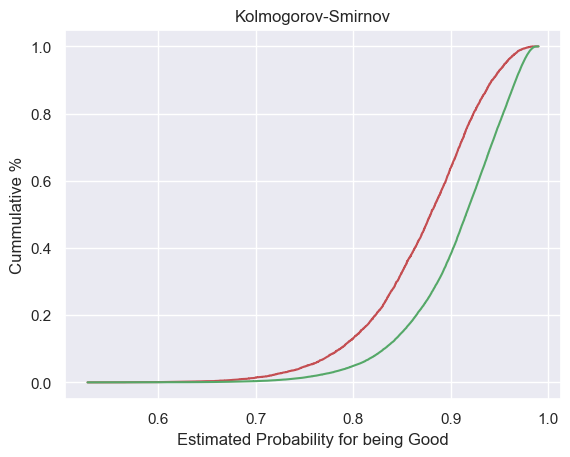

In [148]:
plt.plot(data_actual_predicted_proba['y_hat_test_proba'], data_actual_predicted_proba['Cummulative % Bad'], color='r')
plt.plot(data_actual_predicted_proba['y_hat_test_proba'], data_actual_predicted_proba['Cummulative % Good'], color='g')

plt.xlabel('Estimated Probability for being Good')
plt.ylabel('Cummulative %')
plt.title('Kolmogorov-Smirnov')

In [149]:
KS = max(data_actual_predicted_proba['Cummulative % Bad'] - data_actual_predicted_proba['Cummulative % Good'])
KS

0.2587693158076393

*The two cummulative distribution functions are sufficiently far away from each other and the has satisfactory predictive power*

## Calculating PD of Individuals Accounts

In [150]:
selected_dummy_test.head()

grade:A  grade:B  grade:C  grade:D  grade:E  grade:F  \
362514        0        0        1        0        0        0   
288564        0        0        0        0        1        0   
213591        0        0        1        0        0        0   
263083        0        0        1        0        0        0   
165001        1        0        0        0        0        0   

        ownership:MORTGAGE  ownership:OWN  adrr_state:CA  adrr_state:KY_VA  \
362514                   1              0              1                 0   
288564                   1              0              0                 0   
213591                   1              0              0                 0   
263083                   1              0              0                 0   
165001                   1              0              0                 0   

        adrr_state:NY  adrr_state:NC_UT  adrr_state:MD_NJ_LA_OK_MI_TN  \
362514              0                 0                             0   
288564              0                 0                             0   
213591              0                 0                             0   
263083              0                 0                             1   
165001              0                 0                             0   

        adrr_state:MN_AZ_DE_PA_AR_OH  adrr_state:WA_MA_IN_GA_RI_OR  \
362514                             0                             0   
288564                             0                             1   
213591                             1                             0   
263083                             0                             0   
165001                             1                             0   

        adrr_state:WI_SD_CT  adrr_state:TX  adrr_state:KS_IL_MT  \
362514                    0              0                    0   
288564                    0              0                    0   
213591                    0              0                    0   
263083                    0              0                    0   
165001                    0              0                    0   

        adrr_state:CO_SC_VT_AK  adrr_state:MS_NH_WY_WV_DC_ME_ID  \
362514                       0                                0   
288564                       0                                0   
213591                       0                                0   
263083                       0                                0   
165001                       0                                0   

        purpose:renewable_energy_other_house  \
362514                                     0   
288564                                     0   
213591                                     0   
263083                                     0   
165001                                     0   

        purpose:medical_wedding_vacation  purpose:debt_consolidation  \
362514                                 0                           0   
288564                                 0                           0   
213591                                 0                           1   
263083                                 0                           1   
165001                                 0                           1   

        purpose:home_improvement_major_purchase_car  purpose:credit_card  \
362514                                            1                    0   
288564                                            0                    1   
213591                                            0                    0   
263083                                            0                    0   
165001                                            0                    0   

        ver_status:Source Verified  ver_status:Not Verified  list_status:w  \
362514                           0                        0              0   
288564                           0                        0              1   
213591                           0                        0              0 

In [151]:
y_hat_test_proba

array([0.8639669 , 0.86519366, 0.90899076, ..., 0.96462816, 0.94137768,
       0.96561766])

### Creating a scorecard

In [152]:
reference_feature

['grade:G',
 'home_ownership:RENT_OTHER_NONE_ANY',
 'adrr_state:NE_IA_NV_FL_AL_NM_HI_MO',
 'purpose:small_business_educational_moving',
 'ver_status:Verified',
 'list_status:f',
 'term:36',
 'mths_since_issue_date:<=200',
 'int_rate:<=8',
 'mths_since_earliest_cr_line:<=190',
 'open_acc:<=12',
 'total_acc:<=13',
 'annual_inc:<20k',
 'mths_since_last_delinq:<=33',
 'dti:<=8',
 'mths_since_last_record:<=2']

In [153]:
data_ref_categories = pd.DataFrame(reference_feature, columns=['Feature Name'])
data_ref_categories['Coefficients'] = 0
data_ref_categories['p_values'] = np.nan
data_ref_categories

Feature Name  Coefficients  p_values
0                                     grade:G             0       NaN
1          home_ownership:RENT_OTHER_NONE_ANY             0       NaN
2          adrr_state:NE_IA_NV_FL_AL_NM_HI_MO             0       NaN
3   purpose:small_business_educational_moving             0       NaN
4                         ver_status:Verified             0       NaN
5                               list_status:f             0       NaN
6                                     term:36             0       NaN
7                 mths_since_issue_date:<=200             0       NaN
8                                int_rate:<=8             0       NaN
9           mths_since_earliest_cr_line:<=190             0       NaN
10                              open_acc:<=12             0       NaN
11                             total_acc:<=13             0       NaN
12                            annual_inc:<20k             0       NaN
13                mths_since_last_delinq:<=33             0       NaN
14                                    dti:<=8             0       NaN
15                 mths_since_last_record:<=2             0       NaN

In [154]:
frame = [summary_table, data_ref_categories]
scorecard = pd.concat(frame).reset_index()
scorecard['Original Feature Name'] = scorecard['Feature Name'].str.split(':').str[0]

scorecard

index                                 Feature Name  Coefficients  \
0       0                                    Intercept      1.652745   
1       1                                      grade:A      0.825896   
2       2                                      grade:B      0.848172   
3       3                                      grade:C      0.762474   
4       4                                      grade:D      0.577627   
5       5                                      grade:E      0.395092   
6       6                                      grade:F      0.133544   
7       7                           ownership:MORTGAGE      0.124502   
8       8                                ownership:OWN      0.133540   
9       9                                adrr_state:CA      0.054348   
10     10                             adrr_state:KY_VA      0.051913   
11     11                                adrr_state:NY      0.097173   
12     12                             adrr_state:NC_UT      0.078395   
13     13                 adrr_state:MD_NJ_LA_OK_MI_TN      0.088617   
14     14                 adrr_state:MN_AZ_DE_PA_AR_OH      0.128291   
15     15                 adrr_state:WA_MA_IN_GA_RI_OR      0.151946   
16     16                          adrr_state:WI_SD_CT      0.216326   
17     17                                adrr_state:TX      0.222638   
18     18                          adrr_state:KS_IL_MT      0.260735   
19     19                       adrr_state:CO_SC_VT_AK      0.329628   
20     20              adrr_state:MS_NH_WY_WV_DC_ME_ID      0.475194   
21     21         purpose:renewable_energy_other_house      0.447693   
22     22             purpose:medical_wedding_vacation      0.471671   
23     23                   purpose:debt_consolidation      0.490777   
24     24  purpose:home_improvement_major_purchase_car      0.507781   
25     25                          purpose:credit_card      0.604664   
26     26                   ver_status:Source Verified      0.165975   
27     27                      ver_status:Not Verified      0.130291   
28     28                                list_status:w      0.408323   
29     29                                int_rate:8-10     -0.384698   
30     30                               int_rate:10-14     -0.845610   
31     31                               int_rate:14-19     -1.199428   
32     32                                int_rate:>=19     -1.363087   
33     33                           annual_inc:20k-30k     -0.252516   
34     34                           annual_inc:30k-40k     -0.213089   
35     35                           annual_inc:40k-50k     -0.153540   
36     36                           annual_inc:50k-60k     -0.061285   
37     37                           annual_inc:60k-70k     -0.053787   
38     38                           annual_inc:70k-80k      0.038982   
39     39                           annual_inc:80k-90k      0.092508   
40     40                          annual_inc:90k-100k      0.088660   
41     41                         annual_inc:100k-120k      0.218146   
42     42                         annual_inc:120k-140k      0.221162   
43     43                             annual_inc:>140k      0.342012   
44      0                                      grade:G      0.000000   
45      1           home_ownership:RENT_OTHER_NONE_ANY      0.000000   
46      2           adrr_state:NE_IA_NV_FL_AL_NM_HI_MO      0.000000   
47      3    purpose:small_business_educational_moving      0.000000   
48      4                          ver_status:Verified      0.000000   
49      5                                list_status:f      0.000000   
50      6                                      term:36      0.000000   
51      7                  mths_since_issue_date:<=200      0.000000   
52      8                                 int_rate:<=8      0.000000   
53      9            mths_since_earliest_cr_line:<=190      0.000000   
54     10                                ope

In [155]:
#Create a scorecard
min_score=300
max_score=850

In [156]:
#The minimum credit assessment is reached when a borrower falls into the 'worst' categories for all variables
#The maximum credit assessment is reached when a borrower falls into the 'best' categories for all variables



min_sum_coef = scorecard.groupby('Original Feature Name')['Coefficients'].min().sum()
max_sum_coef = scorecard.groupby('Original Feature Name')['Coefficients'].max().sum()

print(min_sum_coef)
print(max_sum_coef)

0.16164391530501887
4.630625697489027


In [157]:
#var_score = var_coef*( (max_score - min_score) / (max_sum_coef - min_sum_coef) )

scorecard['Score'] = scorecard['Coefficients']*(max_score-min_score)/(max_sum_coef-min_sum_coef)
scorecard['Score'][0] = ((scorecard['Coefficients'][0]-min_sum_coef)/(max_sum_coef-min_sum_coef))*(max_score - min_score) + min_score
scorecard

index                                 Feature Name  Coefficients  \
0       0                                    Intercept      1.652745   
1       1                                      grade:A      0.825896   
2       2                                      grade:B      0.848172   
3       3                                      grade:C      0.762474   
4       4                                      grade:D      0.577627   
5       5                                      grade:E      0.395092   
6       6                                      grade:F      0.133544   
7       7                           ownership:MORTGAGE      0.124502   
8       8                                ownership:OWN      0.133540   
9       9                                adrr_state:CA      0.054348   
10     10                             adrr_state:KY_VA      0.051913   
11     11                                adrr_state:NY      0.097173   
12     12                             adrr_state:NC_UT      0.078395   
13     13                 adrr_state:MD_NJ_LA_OK_MI_TN      0.088617   
14     14                 adrr_state:MN_AZ_DE_PA_AR_OH      0.128291   
15     15                 adrr_state:WA_MA_IN_GA_RI_OR      0.151946   
16     16                          adrr_state:WI_SD_CT      0.216326   
17     17                                adrr_state:TX      0.222638   
18     18                          adrr_state:KS_IL_MT      0.260735   
19     19                       adrr_state:CO_SC_VT_AK      0.329628   
20     20              adrr_state:MS_NH_WY_WV_DC_ME_ID      0.475194   
21     21         purpose:renewable_energy_other_house      0.447693   
22     22             purpose:medical_wedding_vacation      0.471671   
23     23                   purpose:debt_consolidation      0.490777   
24     24  purpose:home_improvement_major_purchase_car      0.507781   
25     25                          purpose:credit_card      0.604664   
26     26                   ver_status:Source Verified      0.165975   
27     27                      ver_status:Not Verified      0.130291   
28     28                                list_status:w      0.408323   
29     29                                int_rate:8-10     -0.384698   
30     30                               int_rate:10-14     -0.845610   
31     31                               int_rate:14-19     -1.199428   
32     32                                int_rate:>=19     -1.363087   
33     33                           annual_inc:20k-30k     -0.252516   
34     34                           annual_inc:30k-40k     -0.213089   
35     35                           annual_inc:40k-50k     -0.153540   
36     36                           annual_inc:50k-60k     -0.061285   
37     37                           annual_inc:60k-70k     -0.053787   
38     38                           annual_inc:70k-80k      0.038982   
39     39                           annual_inc:80k-90k      0.092508   
40     40                          annual_inc:90k-100k      0.088660   
41     41                         annual_inc:100k-120k      0.218146   
42     42                         annual_inc:120k-140k      0.221162   
43     43                             annual_inc:>140k      0.342012   
44      0                                      grade:G      0.000000   
45      1           home_ownership:RENT_OTHER_NONE_ANY      0.000000   
46      2           adrr_state:NE_IA_NV_FL_AL_NM_HI_MO      0.000000   
47      3    purpose:small_business_educational_moving      0.000000   
48      4                          ver_status:Verified      0.000000   
49      5                                list_status:f      0.000000   
50      6                                      term:36      0.000000   
51      7                  mths_since_issue_date:<=200      0.000000   
52      8                                 int_rate:<=8      0.000000   
53      9            mths_since_earliest_cr_line:<=190      0.000000   
54     10                                ope

In [158]:
scorecard['Score Preliminary'] = scorecard['Score'].round()
scorecard

index                                 Feature Name  Coefficients  \
0       0                                    Intercept      1.652745   
1       1                                      grade:A      0.825896   
2       2                                      grade:B      0.848172   
3       3                                      grade:C      0.762474   
4       4                                      grade:D      0.577627   
5       5                                      grade:E      0.395092   
6       6                                      grade:F      0.133544   
7       7                           ownership:MORTGAGE      0.124502   
8       8                                ownership:OWN      0.133540   
9       9                                adrr_state:CA      0.054348   
10     10                             adrr_state:KY_VA      0.051913   
11     11                                adrr_state:NY      0.097173   
12     12                             adrr_state:NC_UT      0.078395   
13     13                 adrr_state:MD_NJ_LA_OK_MI_TN      0.088617   
14     14                 adrr_state:MN_AZ_DE_PA_AR_OH      0.128291   
15     15                 adrr_state:WA_MA_IN_GA_RI_OR      0.151946   
16     16                          adrr_state:WI_SD_CT      0.216326   
17     17                                adrr_state:TX      0.222638   
18     18                          adrr_state:KS_IL_MT      0.260735   
19     19                       adrr_state:CO_SC_VT_AK      0.329628   
20     20              adrr_state:MS_NH_WY_WV_DC_ME_ID      0.475194   
21     21         purpose:renewable_energy_other_house      0.447693   
22     22             purpose:medical_wedding_vacation      0.471671   
23     23                   purpose:debt_consolidation      0.490777   
24     24  purpose:home_improvement_major_purchase_car      0.507781   
25     25                          purpose:credit_card      0.604664   
26     26                   ver_status:Source Verified      0.165975   
27     27                      ver_status:Not Verified      0.130291   
28     28                                list_status:w      0.408323   
29     29                                int_rate:8-10     -0.384698   
30     30                               int_rate:10-14     -0.845610   
31     31                               int_rate:14-19     -1.199428   
32     32                                int_rate:>=19     -1.363087   
33     33                           annual_inc:20k-30k     -0.252516   
34     34                           annual_inc:30k-40k     -0.213089   
35     35                           annual_inc:40k-50k     -0.153540   
36     36                           annual_inc:50k-60k     -0.061285   
37     37                           annual_inc:60k-70k     -0.053787   
38     38                           annual_inc:70k-80k      0.038982   
39     39                           annual_inc:80k-90k      0.092508   
40     40                          annual_inc:90k-100k      0.088660   
41     41                         annual_inc:100k-120k      0.218146   
42     42                         annual_inc:120k-140k      0.221162   
43     43                             annual_inc:>140k      0.342012   
44      0                                      grade:G      0.000000   
45      1           home_ownership:RENT_OTHER_NONE_ANY      0.000000   
46      2           adrr_state:NE_IA_NV_FL_AL_NM_HI_MO      0.000000   
47      3    purpose:small_business_educational_moving      0.000000   
48      4                          ver_status:Verified      0.000000   
49      5                                list_status:f      0.000000   
50      6                                      term:36      0.000000   
51      7                  mths_since_issue_date:<=200      0.000000   
52      8                                 int_rate:<=8      0.000000   
53      9            mths_since_earliest_cr_line:<=190      0.000000   
54     10                                ope

In [159]:
min_sum_score_prelim = scorecard.groupby('Original Feature Name')['Score Preliminary'].min().sum()
max_sum_score_prelim = scorecard.groupby('Original Feature Name')['Score Preliminary'].max().sum()

print(min_sum_score_prelim)
print(max_sum_score_prelim)

300.0
848.0


In [160]:
#if max score is 1 point above the desired max score, it is due to the rounding of the score
#to fix this, we can just substract the max_score with 1. It is the best practice to substract from the variable that was rounded the most

# scorecard['Difference'] = scorecard['Score Preliminary'] - scorecard['Score']
# scorecard.sort_values('Difference', ascending=False)

# #Begin the substraction process
# scorecard['Score Final'] = scorecard['Score Preliminary']
# scorecard['Score Final'][19] = 41

# min_sum_score_final = scorecard.groupby('Original Feature Name')['Score Final'].min().sum()
# max_sum_score_final = scorecard.groupby('Original Feature Name')['Score Final'].max().sum()

# print(min_sum_score_final)
# print(max_sum_score_final)

# scorecard

## Calculating Credit Score

In [161]:
# To calculate the credit score of a borrower, we only have to sum the credit score corresponding to the respective dummy variables categories
dummy_with_ref = [
'grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'ownership:MORTGAGE',
'ownership:OWN',
'adrr_state:NE_IA_NV_FL_AL_NM_HI_MO',
'adrr_state:CA',
'adrr_state:KY_VA',
'adrr_state:NY',
'adrr_state:NC_UT',
'adrr_state:MD_NJ_LA_OK_MI_TN',
'adrr_state:MN_AZ_DE_PA_AR_OH',
'adrr_state:WA_MA_IN_GA_RI_OR',
'adrr_state:WI_SD_CT',
'adrr_state:TX',
'adrr_state:KS_IL_MT',
'adrr_state:CO_SC_VT_AK',
'adrr_state:MS_NH_WY_WV_DC_ME_ID',
'purpose:small_business_educational_moving',
'purpose:renewable_energy_other_house',
'purpose:medical_wedding_vacation',
'purpose:debt_consolidation',
'purpose:home_improvement_major_purchase_car',
'purpose:credit_card',
'ver_status:Verified',
'ver_status:Source Verified',
'ver_status:Not Verified',
'list_status:f',
'list_status:w',
'term:36',
'term:60',
'mths_since_issue_date:<=200',
'mths_since_issue_date:200-240',
'mths_since_issue_date:240-282',
'mths_since_issue_date:282-314',
'mths_since_issue_date:314-334',
'mths_since_issue_date:334-488',
'mths_since_issue_date:>=488',
'int_rate:<=8',
'int_rate:8-10',
'int_rate:10-14',
'int_rate:14-19',
'int_rate:>=19',
'mths_since_earliest_cr_line:<=190',
'mths_since_earliest_cr_line:190-293',
'mths_since_earliest_cr_line:293-344',
'mths_since_earliest_cr_line:344-498',
'mths_since_earliest_cr_line:>=498',
'open_acc:<=12',
'open_acc:12-25',
'open_acc:>=25',
'total_acc:<=13',
'total_acc:13-30',
'total_acc:30-51',
'total_acc:51-66',
'total_acc:>=66',
'annual_inc:<20k',
'annual_inc:20k-30k',
'annual_inc:30k-40k',
'annual_inc:40k-50k',
'annual_inc:50k-60k',
'annual_inc:60k-70k',
'annual_inc:70k-80k',
'annual_inc:80k-90k',
'annual_inc:90k-100k',
'annual_inc:100k-120k',
'annual_inc:120k-140k',
'annual_inc:>140k',
'mths_since_last_delinq:<=33',
'mths_since_last_delinq:33-60',
'mths_since_last_delinq:>60',
'dti:<=8',
'dti:8-15',
'dti:15-20',
'dti:>=21',
'mths_since_last_record:<=2',
'mths_since_last_record:2-27',
'mths_since_last_record:27-60',
'mths_since_last_record:60-88',
'mths_since_last_record:>=88'
]

In [162]:
X_test_with_ref_and_intercept = X_test[dummy_with_ref]

In [163]:
X_test_with_ref_and_intercept.insert(0, 'Intercept', 1)

In [164]:
#make sure to set the order of the X_test as the same as the Feature Name in our scorecard
X_test_with_ref_and_intercept = X_test_with_ref_and_intercept[scorecard['Feature Name'].values]
X_test_with_ref_and_intercept.head()

Intercept  grade:A  grade:B  grade:C  grade:D  grade:E  grade:F  \
362514          1        0        0        1        0        0        0   
288564          1        0        0        0        0        1        0   
213591          1        0        0        1        0        0        0   
263083          1        0        0        1        0        0        0   
165001          1        1        0        0        0        0        0   

        ownership:MORTGAGE  ownership:OWN  adrr_state:CA  adrr_state:KY_VA  \
362514                   1              0              1                 0   
288564                   1              0              0                 0   
213591                   1              0              0                 0   
263083                   1              0              0                 0   
165001                   1              0              0                 0   

        adrr_state:NY  adrr_state:NC_UT  adrr_state:MD_NJ_LA_OK_MI_TN  \
362514              0                 0                             0   
288564              0                 0                             0   
213591              0                 0                             0   
263083              0                 0                             1   
165001              0                 0                             0   

        adrr_state:MN_AZ_DE_PA_AR_OH  adrr_state:WA_MA_IN_GA_RI_OR  \
362514                             0                             0   
288564                             0                             1   
213591                             1                             0   
263083                             0                             0   
165001                             1                             0   

        adrr_state:WI_SD_CT  adrr_state:TX  adrr_state:KS_IL_MT  \
362514                    0              0                    0   
288564                    0              0                    0   
213591                    0              0                    0   
263083                    0              0                    0   
165001                    0              0                    0   

        adrr_state:CO_SC_VT_AK  adrr_state:MS_NH_WY_WV_DC_ME_ID  \
362514                       0                                0   
288564                       0                                0   
213591                       0                                0   
263083                       0                                0   
165001                       0                                0   

        purpose:renewable_energy_other_house  \
362514                                     0   
288564                                     0   
213591                                     0   
263083                                     0   
165001                                     0   

        purpose:medical_wedding_vacation  purpose:debt_consolidation  \
362514                                 0                           0   
288564                                 0                           0   
213591                                 0                           1   
263083                                 0                           1   
165001                                 0                           1   

        purpose:home_improvement_major_purchase_car  purpose:credit_card  \
362514                                            1                    0   
288564                                            0                    1   
213591                                            0                    0   
263083                                            0                    0   
165001                                            0                    0   

        ver_status:Source Verified  ver_status:Not Verified  list_status:w  \
362514                           0                        0              0   
288564                           0                        0              1   
213591   

In [165]:
scorecard_scores = scorecard['Score Preliminary']

In [166]:
X_test_with_ref_and_intercept.shape

(93257, 60)

In [167]:
scorecard_scores.shape

(60,)

In [168]:
#the dimenssion between X_test_with_ref_and_intercept and scorecard_scores need to be the same (The X_Test dimenssion is 2, so we need to reshape the dimenssion of the scorecard_scores to be the same)
scorecard_scores = scorecard_scores.values.reshape(60,1)

In [169]:
y_scores = X_test_with_ref_and_intercept.dot(scorecard_scores)
y_scores.head()

0
362514  507.0
288564  508.0
213591  563.0
263083  579.0
165001  641.0

In [171]:
# Convert Credit Score to PD (Probability of Default)
sum_of_coef_from_score = ((y_scores-min_score)/(max_score - min_score))*(max_sum_coef - min_sum_coef) + min_sum_coef

y_hat_proba_from_score = np.exp(sum_of_coef_from_score) / (np.exp(sum_of_coef_from_score) + 1)
y_hat_proba_from_score.head()

0
362514  0.863375
288564  0.864330
213591  0.908763
263083  0.918985
165001  0.949426

In [173]:
y_hat_test_proba

array([0.8639669 , 0.86519366, 0.90899076, ..., 0.96462816, 0.94137768,
       0.96561766])

*Cut-off rate: used for taking a decision whether to approve a loan application or not*

In [177]:
cutoffs = pd.concat([pd.DataFrame(threshold), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)
cutoffs.columns = ['threshold','fpr','tpr']
cutoffs.head()

threshold  fpr       tpr
0   1.990195  0.0  0.000000
1   0.990195  0.0  0.000012
2   0.989876  0.0  0.000024
3   0.989770  0.0  0.000047
4   0.989285  0.0  0.000083

In [178]:
# Adjusting the first row of the cutoffs
cutoffs['threshold'][0] = 1-1/np.power(10,6)

In [180]:
cutoffs['Score'] = ((np.log(cutoffs['threshold']/(1-cutoffs['threshold']))- min_sum_coef) * ((max_score - min_score)/ (max_sum_coef - min_sum_coef)) + min_score).round()
cutoffs['Score'][0] = max_score
cutoffs.head()

threshold  fpr       tpr  Score
0   0.999999  0.0  0.000000  850.0
1   0.990195  0.0  0.000012  848.0
2   0.989876  0.0  0.000024  844.0
3   0.989770  0.0  0.000047  843.0
4   0.989285  0.0  0.000083  837.0

Total = Number of Approved + Number of Rejected<br>
Approval Rate = Number of Approved / Total<br>
Rejected Rate = Number of Rejected / Total **or** 1 - Approval Rate

In [181]:
data_actual_predicted_proba.head()

index  data_target_test  y_hat_test_proba  y_hat_test  \
0   79004                 1          0.527702           0   
1  321778                 1          0.532250           0   
2   36242                 1          0.532683           0   
3  250047                 0          0.533528           0   
4  372240                 1          0.533977           0   

   Cummulative N Population  Cummulative N Good  Cummulative N Bad  \
0                         1                   1                  0   
1                         2                   2                  0   
2                         3                   3                  0   
3                         4                   3                  1   
4                         5                   4                  1   

   Cummulative % Population  Cummulative % Good  Cummulative % Bad  
0                  0.000011            0.000012           0.000000  
1                  0.000021            0.000024           0.000000  
2                  0.000032            0.000036           0.000000  
3                  0.000043            0.000036           0.000111  
4                  0.000054            0.000047           0.000111

In [184]:
def n_approved(n):
    return np.where(data_actual_predicted_proba['y_hat_test_proba'] >= n, 1, 0).sum()

In [185]:
cutoffs['N Approved'] = cutoffs['threshold'].apply(n_approved)
cutoffs['N Rejected'] = data_actual_predicted_proba['y_hat_test_proba'].shape[0] - cutoffs['N Approved']

cutoffs['Approval Rate'] = cutoffs['N Approved'] / data_actual_predicted_proba['y_hat_test_proba'].shape[0]
cutoffs['Rejected Rate'] = 1 - cutoffs['Approval Rate']

In [204]:
cutoffs.iloc[4000:6200, ]

threshold       fpr       tpr  Score  N Approved  N Rejected  \
4000   0.961702  0.033677  0.140378  677.0       12128       81129   
4001   0.961698  0.033677  0.140401  677.0       12130       81127   
4002   0.961696  0.033677  0.140449  677.0       12134       81123   
4003   0.961695  0.033788  0.140484  677.0       12138       81119   
4004   0.961695  0.033788  0.140532  677.0       12142       81115   
4005   0.961692  0.033788  0.140567  677.0       12145       81112   
4006   0.961689  0.033898  0.140579  677.0       12147       81110   
4007   0.961684  0.033898  0.140603  677.0       12149       81108   
4008   0.961683  0.034009  0.140603  677.0       12150       81107   
4009   0.961683  0.034009  0.140639  677.0       12153       81104   
4010   0.961677  0.034009  0.140734  677.0       12161       81096   
4011   0.961675  0.034009  0.140769  677.0       12164       81093   
4012   0.961675  0.034009  0.140781  677.0       12165       81092   
4013   0.961675  0.034009  0.140805  677.0       12167       81090   
4014   0.961669  0.034009  0.140864  677.0       12172       81085   
4015   0.961668  0.034009  0.140888  677.0       12174       81083   
4016   0.961668  0.034009  0.140924  677.0       12177       81080   
4017   0.961667  0.034009  0.140936  677.0       12178       81079   
4018   0.961666  0.034009  0.140971  677.0       12181       81076   
4019   0.961663  0.034009  0.140995  677.0       12183       81074   
4020   0.961659  0.034009  0.141019  677.0       12185       81072   
4021   0.961657  0.034009  0.141042  677.0       12187       81070   
4022   0.961641  0.034009  0.141066  677.0       12189       81068   
4023   0.961640  0.034009  0.141090  677.0       12191       81066   
4024   0.961640  0.034009  0.141102  677.0       12192       81065   
4025   0.961636  0.034009  0.141161  677.0       12197       81060   
4026   0.961596  0.034009  0.141268  676.0       12206       81051   
4027   0.961594  0.034009  0.141292  676.0       12208       81049   
4028   0.961594  0.034009  0.141304  676.0       12209       81048   
4029   0.961591  0.034009  0.141327  676.0       12211       81046   
4030   0.961590  0.034009  0.141339  676.0       12212       81045   
4031   0.961589  0.034009  0.141375  676.0       12215       81042   
4032   0.961587  0.034009  0.141387  676.0       12216       81041   
4033   0.961585  0.034120  0.141399  676.0       12218       81039   
4034   0.961566  0.034120  0.141458  676.0       12223       81034   
4035   0.961564  0.034120  0.141494  676.0       12226       81031   
4036   0.961562  0.034120  0.141517  676.0       12228       81029   
4037   0.961560  0.034120  0.141565  676.0       12232       81025   
4038   0.961536  0.034120  0.141672  676.0       12241       81016   
4039   0.961536  0.034120  0.141695  676.0       12243       81014   
4040   0.961517  0.034120  0.141767  676.0       12249       81008   
4041   0.961512  0.034120  0.141790  676.0       12251       81006   
4042   0.961510  0.034120  0.141802  676.0       12252       81005   
4043   0.961509  0.034120  0.141826  676.0       12254       81003   
4044   0.961504  0.034120  0.141897  676.0       12260       80997   
4045   0.961499  0.034120  0.141921  676.0       12262       80995   
4046   0.961497  0.034120  0.141957  676.0       12265       80992   
4047   0.961482  0.034120  0.142016  676.0       12270       80987   
4048   0.961479  0.034231  0.142087  676.0       12277       80980   
4049   0.961477  0.034231  0.142123  676.0       12280       80977   
4050   0.961477  0.034231  0.142170  676.0       12284       80973   
4051   0.961475  0.034231  0.142206  676.0       12287       80970   
4052   0.961468  0.034231  0.142253  676.0       12291       80966   
4053   0.961463  0.034231  0.142277  676.0       12293       80964   
4054   0.961456  0.034231  0.142313  676.0       12296       80961   
4055   0.961448  0.034231  0.142336  676.0       12298       80959   
4056   0.961447 

In [188]:
X_test_with_ref_and_intercept.head()

Intercept  grade:A  grade:B  grade:C  grade:D  grade:E  grade:F  \
362514          1        0        0        1        0        0        0   
288564          1        0        0        0        0        1        0   
213591          1        0        0        1        0        0        0   
263083          1        0        0        1        0        0        0   
165001          1        1        0        0        0        0        0   

        ownership:MORTGAGE  ownership:OWN  adrr_state:CA  adrr_state:KY_VA  \
362514                   1              0              1                 0   
288564                   1              0              0                 0   
213591                   1              0              0                 0   
263083                   1              0              0                 0   
165001                   1              0              0                 0   

        adrr_state:NY  adrr_state:NC_UT  adrr_state:MD_NJ_LA_OK_MI_TN  \
362514              0                 0                             0   
288564              0                 0                             0   
213591              0                 0                             0   
263083              0                 0                             1   
165001              0                 0                             0   

        adrr_state:MN_AZ_DE_PA_AR_OH  adrr_state:WA_MA_IN_GA_RI_OR  \
362514                             0                             0   
288564                             0                             1   
213591                             1                             0   
263083                             0                             0   
165001                             1                             0   

        adrr_state:WI_SD_CT  adrr_state:TX  adrr_state:KS_IL_MT  \
362514                    0              0                    0   
288564                    0              0                    0   
213591                    0              0                    0   
263083                    0              0                    0   
165001                    0              0                    0   

        adrr_state:CO_SC_VT_AK  adrr_state:MS_NH_WY_WV_DC_ME_ID  \
362514                       0                                0   
288564                       0                                0   
213591                       0                                0   
263083                       0                                0   
165001                       0                                0   

        purpose:renewable_energy_other_house  \
362514                                     0   
288564                                     0   
213591                                     0   
263083                                     0   
165001                                     0   

        purpose:medical_wedding_vacation  purpose:debt_consolidation  \
362514                                 0                           0   
288564                                 0                           0   
213591                                 0                           1   
263083                                 0                           1   
165001                                 0                           1   

        purpose:home_improvement_major_purchase_car  purpose:credit_card  \
362514                                            1                    0   
288564                                            0                    1   
213591                                            0                    0   
263083                                            0                    0   
165001                                            0                    0   

        ver_status:Source Verified  ver_status:Not Verified  list_status:w  \
362514                           0                        0              0   
288564                           0                        0              1   
213591   

In [189]:
X_test_with_ref_and_intercept.to_csv('X_train_with_ref.csv')

In [191]:
scorecard.to_csv('scorecard.csv')

# LGD Model

**LGD:** the percentage of the exposure that was lost **after** the borrower defaulted. <br>
**EAD:** the amount of exposure **at the moment** the borrower defaulted.

## LGD Variables

In [207]:
loan_data_default = data[data['loan_status'].isin([
'Charged Off','Does not meet the credit policy. Status:Charged Off'
])]

loan_data_default.shape

(43236, 194)

In [209]:
# The independent variables used in LGD and EAD model will be the same as the PD model
loan_data_default.head(2)

Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
1           1  1077430    1314167       2500         2500           2500.0   
8           8  1071795    1306957       5600         5600           5600.0   

         term  int_rate  installment grade sub_grade emp_length  \
1   60 months     15.27        59.83     C        C4   < 1 year   
8   60 months     21.28       152.39     F        F2    4 years   

  home_ownership verification_status issue_d  loan_status pymnt_plan  \
1           RENT     Source Verified  Dec-11  Charged Off          n   
8            OWN     Source Verified  Dec-11  Charged Off          n   

                                                 url         purpose zip_code  \
1  https://www.lendingclub.com/browse/loanDetail....             car    309xx   
8  https://www.lendingclub.com/browse/loanDetail....  small_business    958xx   

  addr_state   dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
1         GA  1.00          0.0           Apr-99             5.0   
8         CA  5.55          0.0           Apr-04             2.0   

   mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
1                     0.0                     0.0       3.0      0.0   
8                     0.0                     0.0      11.0      0.0   

   revol_bal  total_acc initial_list_status  out_prncp  out_prncp_inv  \
1       1687        4.0                   f        0.0            0.0   
8       5210       13.0                   f        0.0            0.0   

   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
1      1008.71          1008.71           456.46         435.17   
8       646.02           646.02           162.02         294.94   

   total_rec_late_fee  recoveries  collection_recovery_fee last_pymnt_d  \
1                 0.0      117.08                     1.11       Apr-13   
8                 0.0      189.06                     2.09       Apr-12   

   last_pymnt_amnt next_pymnt_d last_credit_pull_d  \
1           119.66          NaN             Sep-13   
8           152.39          NaN             Aug-12   

   collections_12_mths_ex_med  mths_since_last_major_derog  policy_code  \
1                         0.0                          0.0            1   
8                         0.0                          0.0            1   

  application_type  acc_now_delinq  tot_coll_amt  emp_length_int  term_int  \
1       INDIVIDUAL             0.0           0.0             0.0        60   
8       INDIVIDUAL             0.0           0.0             4.0        60   

  earliest_cr_line_date issue_d_date last_pymnt_d_date next_pymnt_d_date  \
1            1999-04-01   2011-12-01        2013-04-01               NaN   
8            2004-04-01   2011-12-01        2012-04-01               NaN   

  last_credit_pull_d_date  mths_since_earliest_cr_line  mths_since_issue_date  \
1              2013-09-01                        290.0                  290.0   
8              2012-08-01                        230.0                  230.0   

   grade:A  grade:B  grade:C  grade:D  grade:E  grade:F  grade:G  \
1        0        0        1        0        0        0        0   
8        0        0        0        0        0        1        0   

   sub_grade:A1  sub_grade:A2  sub_grade:A3  sub_grade:A4  sub_grade:A5  \
1             0             0             0             0             0   
8             0             0             0             0             0   

   sub_grade:B1  sub_grade:B2  sub_grade:B3  sub_grade:B4  sub_grade:B5  \
1             0             0             0             0             0   
8             0             0             0             0             0   

   sub_grade:C1  sub_grade:C2  sub_grade:C3  sub_grade:C4  sub_grade:C5  \
1             0             0             0             1             0   
8             0             0             0             0             0   

   sub_grade:D1  sub_grade:D2  sub_grade:D3  sub_grade:

In [210]:
loan_data_default['recovery_rate'] = loan_data_default['recoveries'] / loan_data_default['funded_amnt']
loan_data_default['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [211]:
#The dependent variable for LGD is recovery_rate
#Since the recovery rate should be bounded between 0 and 1, we need to adjust the maximum value of the recovery rate
loan_data_default['recovery_rate'] = np.where(loan_data_default['recovery_rate'] > 1, 1, loan_data_default['recovery_rate'])
loan_data_default['recovery_rate'] = np.where(loan_data_default['recovery_rate'] < 0, 0, loan_data_default['recovery_rate'])

loan_data_default['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

### Splitting Data

In [277]:
X = loan_data_default.drop(columns=['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'CCF'])
y = loan_data_default['recovery_rate_0_1']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [278]:
X_train.head(2)

Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
165859      165859  3108794    3781392      13550        13550   
213563      213563  1344077    1588657       3000         3000   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
165859          13550.0   36 months     18.49       493.21     D        D2   
213563           3000.0   36 months     14.65       103.49     C        C2   

       emp_length home_ownership verification_status issue_d  loan_status  \
165859    8 years           RENT        Not Verified  Feb-13  Charged Off   
213563    5 years           RENT        Not Verified  Jun-12  Charged Off   

       pymnt_plan                                                url  \
165859          n  https://www.lendingclub.com/browse/loanDetail....   
213563          n  https://www.lendingclub.com/browse/loanDetail....   

                   purpose zip_code addr_state    dti  delinq_2yrs  \
165859  debt_consolidation    923xx         CA  26.31          0.0   
213563               other    850xx         AZ  27.21          0.0   

       earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
165859           Jun-03             2.0                     0.0   
213563           Jul-93             3.0                     0.0   

        mths_since_last_record  open_acc  pub_rec  revol_bal  total_acc  \
165859                     0.0      17.0      0.0      10657       34.0   
213563                     0.0      11.0      0.0      12761       13.0   

       initial_list_status  out_prncp  out_prncp_inv  total_pymnt  \
165859                   w        0.0            0.0      6418.63   
213563                   f        0.0            0.0       569.42   

        total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
165859          6418.63          3044.31        1878.89                 0.0   
213563           569.42           271.79         141.25                 0.0   

        recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
165859     1495.43                  14.9543       Dec-13           493.21   
213563      156.38                   1.4100       Oct-12           103.49   

       next_pymnt_d last_credit_pull_d  collections_12_mths_ex_med  \
165859          NaN             May-14                         0.0   
213563          NaN             Mar-13                         0.0   

        mths_since_last_major_derog  policy_code application_type  \
165859                          0.0            1       INDIVIDUAL   
213563                          0.0            1       INDIVIDUAL   

        acc_now_delinq  tot_coll_amt  emp_length_int  term_int  \
165859             0.0           0.0             8.0        36   
213563             0.0           0.0             5.0        36   

       earliest_cr_line_date issue_d_date last_pymnt_d_date next_pymnt_d_date  \
165859            2003-06-01   2013-02-01        2013-12-01               NaN   
213563            1993-07-01   2012-06-01        2012-10-01               NaN   

       last_credit_pull_d_date  mths_since_earliest_cr_line  \
165859              2014-05-01                        240.0   
213563              2013-03-01                        359.0   

        mths_since_issue_date  grade:A  grade:B  grade:C  grade:D  grade:E  \
165859                  240.0        0        0        0        1        0   
213563                  359.0        0        0        1        0        0   

        grade:F  grade:G  sub_grade:A1  sub_grade:A2  sub_grade:A3  \
165859        0        0             0             0             0   
213563        0        0             0             0             0   

        sub_grade:A4  sub_grade:A5  sub_grade:B1  sub_grade:B2  sub_grade:B3  \
165859             0             0             0             0             0   
213563             0             0             0             0             0   

        sub_grade:B4  sub_grade:B5  sub_grade:C1  sub_grade:C2  sub_g

In [279]:
features_all = [
'grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'ownership:ANY',
'ownership:MORTGAGE',
'ownership:NONE',
'ownership:OTHER',
'ownership:OWN',
'ownership:RENT',
'ver_status:Verified',
'ver_status:Source Verified',
'ver_status:Not Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'addr:AK',
'addr:AL',
'addr:AR',
'addr:AZ',
'addr:CA',
'addr:CO',
'addr:CT',
'addr:DC',
'addr:DE',
'addr:FL',
'addr:GA',
'addr:HI',
'addr:IA',
'addr:ID',
'addr:IL',
'addr:IN',
'addr:KS',
'addr:KY',
'addr:LA',
'addr:MA',
'addr:MD',
'addr:ME',
'addr:MI',
'addr:MN',
'addr:MO',
'addr:MS',
'addr:MT',
'addr:NC',
'addr:NE',
'addr:NH',
'addr:NJ',
'addr:NM',
'addr:NV',
'addr:NY',
'addr:OH',
'addr:OK',
'addr:OR',
'addr:PA',
'addr:RI',
'addr:SC',
'addr:SD',
'addr:TN',
'addr:TX',
'addr:UT',
'addr:VA',
'addr:VT',
'addr:WA',
'addr:WI',
'addr:WV',
'addr:WY',
'list_status:f',
'list_status:w',
'term_int',
'mths_since_issue_date',
'int_rate',
'mths_since_earliest_cr_line',
'open_acc',
'total_acc',
'annual_inc',
'mths_since_last_delinq',
'dti',
'mths_since_last_record'
]

features_reference_cat = [
'grade:G',
'ownership:RENT',
'addr:NE',
'purpose:small_business',
'ver_status:Verified',
'list_status:f'
]

In [280]:
X_train = X_train[features_all]

In [281]:
X_train = X_train.drop(features_reference_cat, axis=1)

In [282]:
X_train.head(2)

grade:A  grade:B  grade:C  grade:D  grade:E  grade:F  ownership:ANY  \
165859        0        0        0        1        0        0              0   
213563        0        0        1        0        0        0              0   

        ownership:MORTGAGE  ownership:NONE  ownership:OTHER  ownership:OWN  \
165859                   0               0                0              0   
213563                   0               0                0              0   

        ver_status:Source Verified  ver_status:Not Verified  purpose:car  \
165859                           0                        1            0   
213563                           0                        1            0   

        purpose:credit_card  purpose:debt_consolidation  purpose:educational  \
165859                    0                           1                    0   
213563                    0                           0                    0   

        purpose:home_improvement  purpose:house  purpose:major_purchase  \
165859                         0              0                       0   
213563                         0              0                       0   

        purpose:medical  purpose:moving  purpose:other  \
165859                0               0              0   
213563                0               0              1   

        purpose:renewable_energy  purpose:vacation  purpose:wedding  addr:AK  \
165859                         0                 0                0        0   
213563                         0                 0                0        0   

        addr:AL  addr:AR  addr:AZ  addr:CA  addr:CO  addr:CT  addr:DC  \
165859        0        0        0        1        0        0        0   
213563        0        0        1        0        0        0        0   

        addr:DE  addr:FL  addr:GA  addr:HI  addr:IA  addr:ID  addr:IL  \
165859        0        0        0        0        0        0        0   
213563        0        0        0        0        0        0        0   

        addr:IN  addr:KS  addr:KY  addr:LA  addr:MA  addr:MD  addr:ME  \
165859        0        0        0        0        0        0        0   
213563        0        0        0        0        0        0        0   

        addr:MI  addr:MN  addr:MO  addr:MS  addr:MT  addr:NC  addr:NH  \
165859        0        0        0        0        0        0        0   
213563        0        0        0        0        0        0        0   

        addr:NJ  addr:NM  addr:NV  addr:NY  addr:OH  addr:OK  addr:OR  \
165859        0        0        0        0        0        0        0   
213563        0        0        0        0        0        0        0   

        addr:PA  addr:RI  addr:SC  addr:SD  addr:TN  addr:TX  addr:UT  \
165859        0        0        0        0        0        0        0   
213563        0        0        0        0        0        0        0   

        addr:VA  addr:VT  addr:WA  addr:WI  addr:WV  addr:WY  list_status:w  \
165859        0        0        0        0        0        0              1   
213563        0        0        0        0        0        0              0   

        term_int  mths_since_issue_date  int_rate  \
165859        36                  240.0     18.49   
213563        36                  359.0     14.65   

        mths_since_earliest_cr_line  open_acc  total_acc  annual_inc  \
165859                        240.0      17.0       34.0     38000.0   
213563                        359.0      11.0       13.0     40000.0   

        mths_since_last_delinq    dti  mths_since_last_record  
165859                     0.0  26.31                     0.0  
213563                     0.0  27.21                     0.0

## Estimating LGD Model

In [283]:
# Droping the zero-value column
X_train = X_train.drop(columns=['ownership:ANY','addr:ME'], axis=1)

In [284]:
X_train.describe()

grade:A       grade:B       grade:C       grade:D       grade:E  \
count  34588.000000  34588.000000  34588.000000  34588.000000  34588.000000   
mean       0.059038      0.214323      0.278073      0.229646      0.135741   
std        0.235699      0.410358      0.448056      0.420611      0.342518   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            grade:F  ownership:MORTGAGE  ownership:NONE  ownership:OTHER  \
count  34588.000000        34588.000000    34588.000000     34588.000000   
mean       0.064849            0.442639        0.000202         0.001012   
std        0.246263            0.496706        0.014225         0.031795   
min        0.000000            0.000000        0.000000         0.000000   
25%        0.000000            0.000000        0.000000         0.000000   
50%        0.000000            0.000000        0.000000         0.000000   
75%        0.000000            1.000000        0.000000         0.000000   
max        1.000000            1.000000        1.000000         1.000000   

       ownership:OWN  ver_status:Source Verified  ver_status:Not Verified  \
count   34588.000000                34588.000000             34588.000000   
mean        0.087487                    0.290014                 0.281254   
std         0.282551                    0.453775                 0.449617   
min         0.000000                    0.000000                 0.000000   
25%         0.000000                    0.000000                 0.000000   
50%         0.000000                    0.000000                 0.000000   
75%         0.000000                    1.000000                 1.000000   
max         1.000000                    1.000000                 1.000000   

        purpose:car  purpose:credit_card  purpose:debt_consolidation  \
count  34588.000000         34588.000000                34588.000000   
mean       0.010350             0.173326                    0.602984   
std        0.101211             0.378534                    0.489287   
min        0.000000             0.000000                    0.000000   
25%        0.000000             0.000000                    0.000000   
50%        0.000000             0.000000                    1.000000   
75%        0.000000             0.000000                    1.000000   
max        1.000000             1.000000                    1.000000   

       purpose:educational  purpose:home_improvement  purpose:house  \
count         34588.000000              34588.000000   34588.000000   
mean              0.002168                  0.051000       0.006621   
std               0.046516                  0.220002       0.081100   
min               0.000000                  0.000000       0.000000   
25%               0.000000                  0.000000       0.000000   
50%               0.000000                  0.000000       0.000000   
75%               0.000000                  0.000000       0.000000   
max               1.000000                  1.000000       1.000000   

       purpose:major_purchase  purpose:medical  purpose:moving  purpose:other  \
count            34588.000000     34588.000000    34588.000000   34588.000000   
mean                 0.019400         0.012230        0.009541       0.066699   
std                  0.137927         0.109911        0.097212       0.249504   
min                  0.000000         0.000000        0.000000       0.000000   
25%                  0.000000         0.000000        0.000000       0.000000   
50%                  0.000000         0.000000        0.000000       0.000000   
75%                  0.000000         0.000000        0.000000   

In [285]:
reg_lgd = LogisticRegression_with_p_values()
reg_lgd.fit(X_train, y_train)

In [286]:
feature_name = X_train.columns.values

In [287]:
summary_table = pd.DataFrame(columns=['Feature Name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd.coef_)

#Let's insert the intercept score at the first row
summary_table.index = summary_table.index+1
summary_table.loc[0] = ['Intercept', reg_lgd.intercept_[0]]

#Sorting the summary table by the index
summary_table = summary_table.sort_index()
p_values = reg_lgd.p_values

#Since we only have the p_value for our independent variable, therefore we can just add NaN value at the intercept rows 
p_values = np.append(np.nan, np.array(p_values))

summary_table['p_values'] = p_values
summary_table

Feature Name  Coefficients      p_values
0                     Intercept  1.939761e-04           NaN
1                       grade:A -1.457965e-05  9.999053e-01
2                       grade:B -7.663145e-05  9.993593e-01
3                       grade:C -2.293743e-04  9.980136e-01
4                       grade:D  1.560526e-04  9.985527e-01
5                       grade:E  9.237023e-05  9.991493e-01
6                       grade:F  2.220742e-04  9.980640e-01
7            ownership:MORTGAGE -8.172399e-05  9.974927e-01
8                ownership:NONE  2.375287e-06  9.999975e-01
9               ownership:OTHER  5.462751e-06  9.999872e-01
10                ownership:OWN  2.561284e-06  9.999503e-01
11   ver_status:Source Verified -4.000250e-04  9.880898e-01
12      ver_status:Not Verified  1.276824e-04  9.965995e-01
13                  purpose:car  4.804773e-05  9.997141e-01
14          purpose:credit_card -2.503758e-04  9.967101e-01
15   purpose:debt_consolidation -1.879886e-04  9.968454e-01
16          purpose:educational  1.301042e-05  9.999600e-01
17     purpose:home_improvement  4.203093e-05  9.995394e-01
18                purpose:house  3.651180e-05  9.997936e-01
19       purpose:major_purchase  7.359388e-05  9.993666e-01
20              purpose:medical  9.104852e-06  9.999360e-01
21               purpose:moving  1.590224e-05  9.998971e-01
22                purpose:other  1.604136e-04  9.975746e-01
23     purpose:renewable_energy  9.472045e-06  9.999769e-01
24             purpose:vacation  1.598358e-05  9.999007e-01
25              purpose:wedding  3.952559e-05  9.997747e-01
26                      addr:AK  1.098374e-06  9.999955e-01
27                      addr:AL -2.232845e-05  9.998205e-01
28                      addr:AR -1.365344e-05  9.999131e-01
29                      addr:AZ  2.797245e-06  9.999677e-01
30                      addr:CA  1.963253e-04           NaN
31                      addr:CO -2.944927e-05  9.997200e-01
32                      addr:CT -5.240378e-05  9.996096e-01
33                      addr:DC  4.849153e-06  9.999848e-01
34                      addr:DE -2.269976e-06  9.999914e-01
35                      addr:FL  2.193094e-04  9.956163e-01
36                      addr:GA -2.805029e-05  9.997382e-01
37                      addr:HI  1.673559e-05  9.999066e-01
38                      addr:IA -1.128627e-07  9.999999e-01
39                      addr:ID -6.336510e-07  9.999998e-01
40                      addr:IL -2.715237e-05  9.995956e-01
41                      addr:IN -3.507859e-05  9.995673e-01
42                      addr:KS  5.661262e-06  9.999645e-01
43                      addr:KY -1.189074e-05  9.999178e-01
44                      addr:LA  2.363865e-05  9.998162e-01
45                      addr:MA  7.675085e-05  9.993421e-01
46                      addr:MD -3.121257e-06  9.999660e-01
47                      addr:MI  2.823123e-06  9.999663e-01
48                      addr:MN -5.686693e-05  9.994196e-01
49                      addr:MO  3.058706e-06  9.999761e-01
50                      addr:MS -1.087603e-05  9.999623e-01
51                      addr:MT  1.509022e-06  9.999949e-01
52                      addr:NC  6.763813e-05  9.990896e-01
53                      addr:NH  9.070188e-06  9.999595e-01
54                      addr:NJ  1.536920e-07           NaN
55                      addr:NM -7.409063e-06  9.999517e-01
56                      addr:NV  1.377811e-05  9.998677e-01
57                      addr:NY -2.148239e-04  9.899538e-01
58                      addr:OH -1.773320e-05  9.997440e-01
59                      addr:OK -6.789503e-06  9.999536e-01
60                      addr:OR -3.034916e-05  9.997594e-01
61                      addr:PA  6.792579e-06  9.999006e-01
62                      addr:RI  1.645635e-05  9.999246e-01
63                      addr:SC  3.853972e-05  9.996531e-01
64                      addr:SD  4.580022e-07  9.999989e-01
65                      addr:TN -4.689113e-05  9.996467e-01

## Testing LGD Model

In [288]:
X_test = X_test[features_all]

In [289]:
X_test = X_test.drop(features_reference_cat, axis=1)

In [290]:
X_test = X_test.drop(columns=['ownership:ANY','addr:ME'], axis=1)

In [291]:
y_hat_test_lgd = reg_lgd.model.predict(X_test)
y_hat_test_proba_lgd = reg_lgd.model.predict_proba(X_test)

In [292]:
y_hat_test_proba_lgd

array([[0.46469528, 0.53530472],
       [0.40040403, 0.59959597],
       [0.45468271, 0.54531729],
       ...,
       [0.54213983, 0.45786017],
       [0.394845  , 0.605155  ],
       [0.40933898, 0.59066102]])

In [293]:
# Retrieve the recovery rate proba with values > 0
y_hat_test_proba_lgd = y_hat_test_proba_lgd[: ][:,1]

In [294]:
y_hat_test_proba_lgd

array([0.53530472, 0.59959597, 0.54531729, ..., 0.45786017, 0.605155  ,
       0.59066102])

## EAD Variables

In [212]:
# CCF = Credit Conversion Factor
# CCF = 0 (all is paid) | CCF = 1 (nothing was been paid)
loan_data_default['CCF'] = (loan_data_default['funded_amnt'] - loan_data_default['total_rec_prncp'])/loan_data_default['funded_amnt']
loan_data_default['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [213]:
loan_data_default.to_csv('loan_data_default.csv')

## Exploring Dependent Variables

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

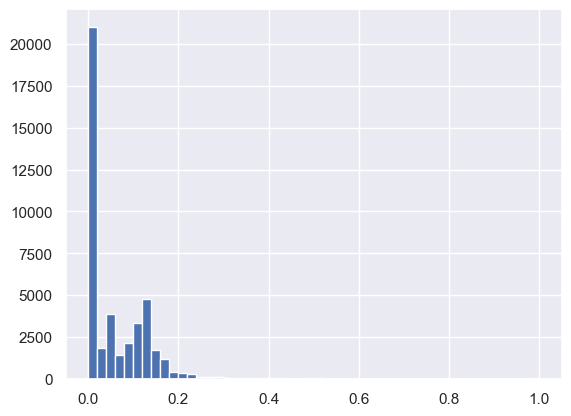

In [214]:
plt.hist(loan_data_default['recovery_rate'], bins=50)

(array([  20.,   60.,   29.,   97.,   70.,   84.,  150.,   78.,  124.,
         170.,  152.,  208.,  199.,  228.,  242.,  276.,  300.,  335.,
         339.,  376.,  412.,  421.,  505.,  505.,  575.,  583.,  614.,
         735.,  756.,  812.,  840.,  942.,  959., 1137., 1217., 1418.,
        1431., 1580., 1732., 1850., 2003., 2151., 2123., 2376., 2447.,
        2693., 2366., 2115., 1527.,  874.]),
 array([4.3800000e-04, 2.0429240e-02, 4.0420480e-02, 6.0411720e-02,
        8.0402960e-02, 1.0039420e-01, 1.2038544e-01, 1.4037668e-01,
        1.6036792e-01, 1.8035916e-01, 2.0035040e-01, 2.2034164e-01,
        2.4033288e-01, 2.6032412e-01, 2.8031536e-01, 3.0030660e-01,
        3.2029784e-01, 3.4028908e-01, 3.6028032e-01, 3.8027156e-01,
        4.0026280e-01, 4.2025404e-01, 4.4024528e-01, 4.6023652e-01,
        4.8022776e-01, 5.0021900e-01, 5.2021024e-01, 5.4020148e-01,
        5.6019272e-01, 5.8018396e-01, 6.0017520e-01, 6.2016644e-01,
        6.4015768e-01, 6.6014892e-01, 6.8014016e-01, 7.0

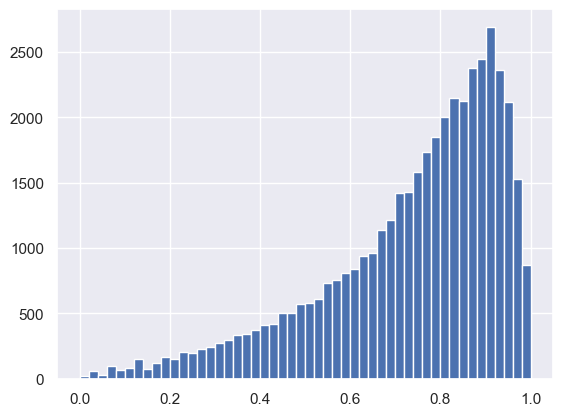

In [215]:
plt.hist(loan_data_default['CCF'], bins=50)

In [216]:
loan_data_default['recovery_rate_0_1'] = np.where(loan_data_default['recovery_rate'] == 0, 0, 1)